## Prediction and interpretation of banking marketing with Machine Learning





I propose a machine learning approach to predict the success of telemarketing calls for selling bank long-term deposits. A Portuguese retail bank was addressed, with data collected from 2008 to 2013. I analyzed a large set of 56 features related with bank client, product and social-economic attributes. The dataset did not contain duplicate or missing values, however there were several categorical variables that needed to be converted. These were both ordinal and nominal.
 I also compared three ML models: logistic regression, decision trees (DTs), XGBoost. Each model was tested in two different ways to see if the results improved. 

The objective of the analysis was to predict whether or not the bank's consumers would accept a new product offered by the bank.


In [152]:
import pandas as pd, numpy as np, seaborn as sns, warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, f1_score, recall_score, accuracy_score, precision_score,\
                            auc, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

In [2]:
def metrics_score(y_test, y_pred):
    print('The accuracy score is: ', accuracy_score(y_test, y_pred))
    print('The precision score is: ', precision_score(y_test, y_pred))
    print('The r2 score is: ', r2_score(y_test, y_pred))
    print('The f1 score is: ', f1_score(y_test, y_pred))

In [3]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 

In [4]:
df = pd.read_csv('bank.csv')

In [5]:
df.size

189754

In [6]:
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [7]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object

In [8]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
columns = df.columns.to_list()
df[columns].nunique()

age            76
job            12
marital         3
education       4
default         2
balance      3805
housing         2
loan            2
contact         3
day            31
month          12
duration     1428
campaign       36
pdays         472
previous       34
poutcome        4
deposit         2
dtype: int64

In [11]:
df['deposit'].value_counts()

deposit
no     5873
yes    5289
Name: count, dtype: int64

In [12]:
df['education'].unique()

array(['secondary', 'tertiary', 'primary', 'unknown'], dtype=object)

In [13]:
df['education'] = df['education'].replace({'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3})

<Axes: xlabel='deposit', ylabel='count'>

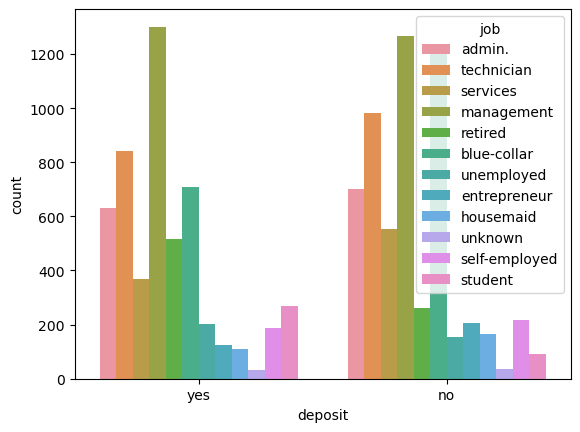

In [14]:
sns.countplot(x=df['deposit'], hue=df['job'])

In [15]:
df['poutcome'].unique()

array(['unknown', 'other', 'failure', 'success'], dtype=object)

<Axes: xlabel='deposit', ylabel='count'>

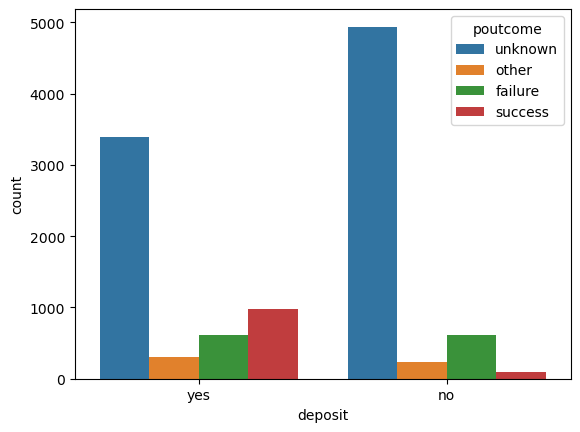

In [16]:
sns.countplot(x=df['deposit'], hue=df['poutcome'])

In [17]:
df['contact'].unique()

array(['unknown', 'cellular', 'telephone'], dtype=object)

<Axes: xlabel='deposit', ylabel='count'>

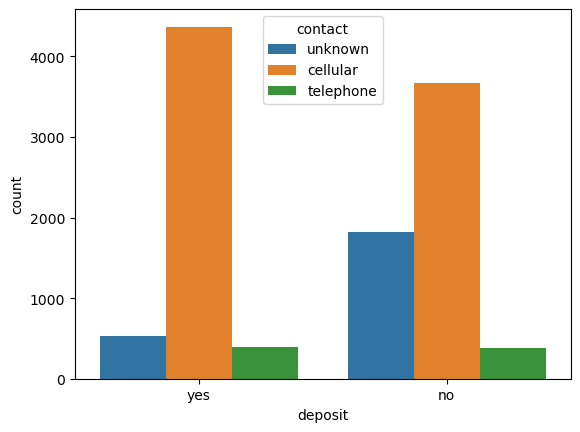

In [18]:
sns.countplot(x=df['deposit'], hue=df['contact'])

In [19]:
df['housing'].unique()

array(['yes', 'no'], dtype=object)

In [20]:
df = pd.get_dummies(data=df, columns=['marital', 'job', 'contact', 'poutcome'], dtype=(int))

In [21]:
df.dtypes

age                   int64
education             int64
default              object
balance               int64
housing              object
loan                 object
day                   int64
month                object
duration              int64
campaign              int64
pdays                 int64
previous              int64
deposit              object
marital_divorced      int64
marital_married       int64
marital_single        int64
job_admin.            int64
job_blue-collar       int64
job_entrepreneur      int64
job_housemaid         int64
job_management        int64
job_retired           int64
job_self-employed     int64
job_services          int64
job_student           int64
job_technician        int64
job_unemployed        int64
job_unknown           int64
contact_cellular      int64
contact_telephone     int64
contact_unknown       int64
poutcome_failure      int64
poutcome_other        int64
poutcome_success      int64
poutcome_unknown      int64
dtype: object

In [22]:
df['default'].unique()

array(['no', 'yes'], dtype=object)

<Axes: xlabel='deposit', ylabel='count'>

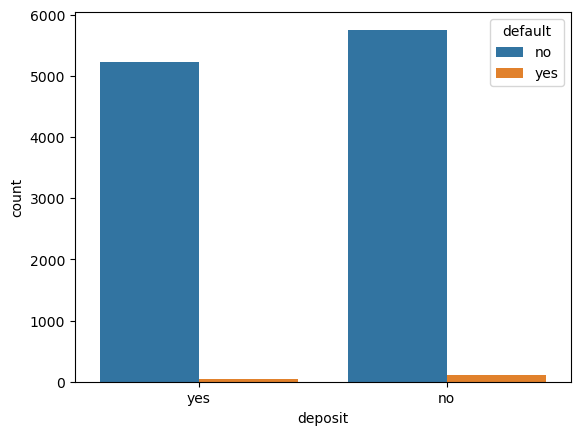

In [23]:
sns.countplot(x=df['deposit'], hue=df['default'])

In [24]:
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)


In [25]:
df['housing'] = df['housing'].apply(lambda x: 1 if x == 1 else 0)

In [26]:
df['housing'].unique()

array([0])

In [27]:
df['loan'].unique()

array(['no', 'yes'], dtype=object)

In [28]:
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

In [29]:
df['loan'].value_counts()

loan
0    9702
1    1460
Name: count, dtype: int64

In [30]:
df['deposit'].unique()

array(['yes', 'no'], dtype=object)

In [31]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [32]:
df = pd.get_dummies(data=df, columns=['month'], dtype=(int))

In [33]:
df.head()

age  education  default  balance  housing  loan  day  duration  campaign  \
0   59          2        0     2343        0     0    5      1042         1   
1   56          2        0       45        0     0    5      1467         1   
2   41          2        0     1270        0     0    5      1389         1   
3   55          2        0     2476        0     0    5       579         1   
4   54          3        0      184        0     0    5       673         2   

   pdays  ...  month_dec  month_feb  month_jan  month_jul  month_jun  \
0     -1  ...          0          0          0          0          0   
1     -1  ...          0          0          0          0          0   
2     -1  ...          0          0          0          0          0   
3     -1  ...          0          0          0          0          0   
4     -1  ...          0          0          0          0          0   

   month_mar  month_may  month_nov  month_oct  month_sep  
0          0          1          0          0          0  
1          0          1          0          0          0  
2          0          1          0          0          0  
3          0          1          0          0          0  
4          0          1          0          0          0  

[5 rows x 46 columns]

In [34]:
df.dtypes

age                  int64
education            int64
default              int64
balance              int64
housing              int64
loan                 int64
day                  int64
duration             int64
campaign             int64
pdays                int64
previous             int64
deposit              int64
marital_divorced     int64
marital_married      int64
marital_single       int64
job_admin.           int64
job_blue-collar      int64
job_entrepreneur     int64
job_housemaid        int64
job_management       int64
job_retired          int64
job_self-employed    int64
job_services         int64
job_student          int64
job_technician       int64
job_unemployed       int64
job_unknown          int64
contact_cellular     int64
contact_telephone    int64
contact_unknown      int64
poutcome_failure     int64
poutcome_other       int64
poutcome_success     int64
poutcome_unknown     int64
month_apr            int64
month_aug            int64
month_dec            int64
m

In [35]:
round(df.corr(),2)

age  education  default  balance  housing  loan   day  \
age                1.00      -0.20    -0.01     0.11      NaN -0.03 -0.00   
education         -0.20       1.00    -0.02     0.03      NaN -0.02  0.00   
default           -0.01      -0.02     1.00    -0.06      NaN  0.08  0.02   
balance            0.11       0.03    -0.06     1.00      NaN -0.08  0.01   
housing             NaN        NaN      NaN      NaN      NaN   NaN   NaN   
loan              -0.03      -0.02     0.08    -0.08      NaN  1.00  0.02   
day               -0.00       0.00     0.02     0.01      NaN  0.02  1.00   
duration           0.00      -0.00    -0.01     0.02      NaN -0.00 -0.02   
campaign          -0.01      -0.02     0.03    -0.01      NaN  0.03  0.14   
pdays              0.00       0.03    -0.04     0.02      NaN -0.03 -0.08   
previous           0.02       0.03    -0.04     0.03      NaN -0.02 -0.06   
deposit            0.03       0.08    -0.04     0.08      NaN -0.11 -0.06   
marital_divorced   0.19      -0.02     0.02    -0.02      NaN  0.03  0.00   
marital_married    0.32      -0.12    -0.01     0.03      NaN  0.04  0.00   
marital_single    -0.47       0.14    -0.01    -0.01      NaN -0.07 -0.00   
job_admin.        -0.06      -0.03    -0.02    -0.04      NaN  0.05 -0.01   
job_blue-collar   -0.07      -0.31     0.02    -0.05      NaN  0.06 -0.02   
job_entrepreneur   0.02       0.02     0.02     0.01      NaN  0.04 -0.00   
job_housemaid      0.08      -0.11     0.02    -0.01      NaN -0.03  0.01   
job_management    -0.05       0.45     0.00     0.04      NaN -0.05  0.01   
job_retired        0.56      -0.14    -0.02     0.08      NaN -0.05 -0.00   
job_self-employed -0.02       0.08     0.01     0.02      NaN  0.00  0.01   
job_services      -0.08      -0.09    -0.02    -0.04      NaN  0.03  0.00   
job_student       -0.23      -0.07    -0.02    -0.00      NaN -0.07 -0.01   
job_technician    -0.08       0.06     0.00     0.00      NaN  0.01  0.03   
job_unemployed    -0.00      -0.02     0.01    -0.01      NaN -0.04 -0.00   
job_unknown        0.04      -0.12    -0.00     0.01      NaN -0.02 -0.00   
contact_cellular  -0.09       0.16    -0.03     0.01      NaN -0.00 -0.01   
contact_telephone  0.21      -0.10    -0.02     0.06      NaN -0.02  0.01   
contact_unknown   -0.04      -0.11     0.04    -0.05      NaN  0.01  0.00   
poutcome_failure  -0.01       0.02    -0.02     0.00      NaN  0.01 -0.07   
poutcome_other    -0.02       0.02    -0.02     0.03      NaN -0.02 -0.01   
poutcome_success   0.06       0.05    -0.04     0.05      NaN -0.08 -0.04   
poutcome_unknown  -0.03      -0.06     0.05    -0.05      NaN  0.06  0.08   
month_apr         -0.02       0.01    -0.02     0.02      NaN -0.04  0.11   
month_aug          0.05       0.08    -0.00     0.01      NaN -0.06 -0.01   
month_dec          0.04      -0.00    -0.01     0.04      NaN -0.03 -0.01   
month_feb          0.02       0.03    -0.02     0.00      NaN -0.01 -0.23   
month_jan          0.02      -0.01     0.00    -0.02      NaN  0.00  0.21   
month_jul         -0.00      -0.05     0.05    -0.06      NaN  0.16  0.13   
month_jun          0.01      -0.03     0.02     0.01      NaN -0.02 -0.18   
month_mar          0.03       0.05    -0.02     0.03      NaN -0.04 -0.04   
month_may         -0.12      -0.08    -0.00    -0.06      NaN  0.01 -0.01   
month_nov          0.02       0.03    -0.00     0.08      NaN  0.01  0.06   
month_oct          0.07       0.01    -0.02     0.03      NaN -0.03  0.08   
month_sep          0.04       0.02    -0.02     0.02      NaN -0.05 -0.07   

                   duration  campaign  pdays  ...  month_dec  month_feb  \
age                    0.00     -0.01   0.00  ...       0.04       0.02   
education             -0.00     -0.02   0.03  ...      -0.00       0.03   
default               -0.01      0.03  -0.04  ...      -0.01      -0.02   
balance                0.02     -0.01   0.02  ...       0.04       0.00   
housing                 N

### Logistic Regression - 1

In [36]:
LR = LogisticRegression(random_state=0)

In [37]:
X = df.drop(columns='deposit')
y = df['deposit']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0, stratify=y)

In [39]:
param_values = {'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}

In [40]:
search = GridSearchCV(LR, param_grid=param_values, cv=3, n_jobs=-1)

In [41]:
search.fit(X_train, y_train)
y_pred = search.predict(X_test)
search.score(X_train, y_train)

0.8263151158325868

In [42]:
search.score(X_test, y_test)

0.8136757240967453

In [43]:
f1_score(y_test, y_pred)

0.7980582524271844

In [44]:
metrics_score(y_test, y_pred)

The accuracy score is:  0.8136757240967453
The precision score is:  0.8203592814371258
The r2 score is:  0.25266227370941696
The f1 score is:  0.7980582524271844


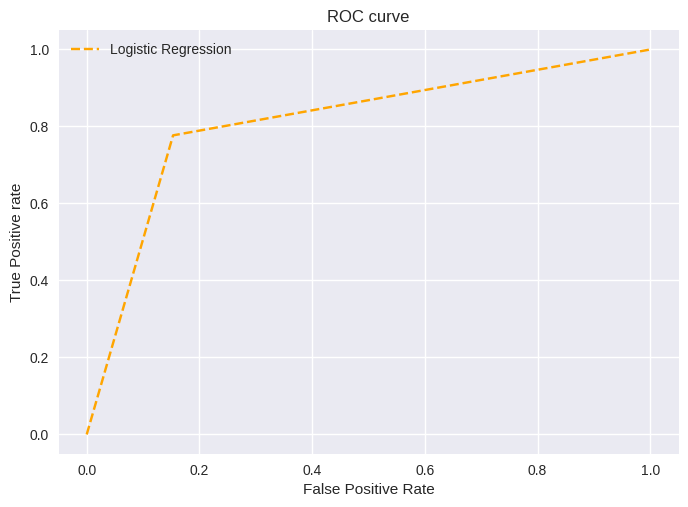

In [45]:
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred, pos_label=1)
auc_score1 = roc_auc_score(y_test, y_pred)

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### Logistic Regression - 2

In [46]:
LR = LogisticRegression()
std = StandardScaler()
pca = PCA(n_components=5)

In [47]:
pipe = Pipeline(steps=[('std', std),
                       ('pca', pca),
                           ('LR', LR)])

In [48]:
n_components = list(range(1,X.shape[1]+1,1))

In [49]:
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2', 'elasticnet']

In [50]:
param_values = dict(pca__n_components=n_components,
                    LR__C=C,
                      LR__penalty=penalty)

In [53]:
search = GridSearchCV(pipe, param_grid=param_values, n_jobs=-1, verbose=3, cv=5)

In [54]:
search.fit(X_train, y_train)
y_pred = search.predict(X_test)
search.score(X_train, y_train)

Fitting 5 folds for each of 6750 candidates, totalling 33750 fits
[CV 3/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=4;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=13;, score=nan total time

[CV 5/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=4;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=5;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=17;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0001, LR__penalty=l1, pca__n_compon

[CV 2/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=4;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=11;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=12;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=15;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0001, LR__penalty=l1, pca__n_compo

[CV 3/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=5;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0001, LR__penalty=l1, pca__n_components=22;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0001, LR__penalty=l1, pca__n_comp

[CV 5/5] END LR__C=0.0001, LR__penalty=elasticnet, pca__n_components=40;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.0001, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0001, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0001456348

[CV 4/5] END LR__C=0.0001, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.0s
[CV 5/5] END LR__C=0.0001, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0001, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0001, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.0s
[CV 4/5] END LR__C=0.0001, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.0s
[CV 5/5] END LR__C=0.0001, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.0s
[CV 4/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=4;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.00014563484775012445, LR__penal

[CV 1/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=15;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=15;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=15;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=28;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.00014563484775012445, LR__penalty=l1, pca__n_components=28;, score=nan total time=   0.1s
[

[CV 5/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=17;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.2s
[CV 2/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00014563484775012445, LR__p

[CV 1/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=36;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.0s
[CV 3/5] END LR__C=0.00014563484775012445, LR__p

[CV 2/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.2s
[CV 2/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.2s
[CV 3/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.00014563484775012445, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.2s
[CV 1/5] END LR__C=0.00014563484775012445, LR__p

[CV 3/5] END LR__C=0.00021209508879201905, LR__penalty=l2, pca__n_components=36;, score=0.768 total time=   0.1s
[CV 4/5] END LR__C=0.00021209508879201905, LR__penalty=l2, pca__n_components=36;, score=0.774 total time=   0.1s
[CV 5/5] END LR__C=0.00021209508879201905, LR__penalty=l2, pca__n_components=36;, score=0.777 total time=   0.1s
[CV 1/5] END LR__C=0.00021209508879201905, LR__penalty=l2, pca__n_components=37;, score=0.768 total time=   0.1s
[CV 5/5] END LR__C=0.00021209508879201905, LR__penalty=l2, pca__n_components=38;, score=0.778 total time=   0.1s
[CV 1/5] END LR__C=0.00021209508879201905, LR__penalty=l2, pca__n_components=39;, score=0.765 total time=   0.1s
[CV 2/5] END LR__C=0.00021209508879201905, LR__penalty=l2, pca__n_components=39;, score=0.758 total time=   0.1s
[CV 3/5] END LR__C=0.00021209508879201905, LR__penalty=l2, pca__n_components=39;, score=0.768 total time=   0.1s
[CV 3/5] END LR__C=0.00021209508879201905, LR__penalty=l2, pca__n_components=44;, score=0.768 to

[CV 3/5] END LR__C=0.00021209508879201905, LR__penalty=l2, pca__n_components=35;, score=0.766 total time=   0.2s
[CV 1/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.00021209508879201905, LR__penalty=elasti

[CV 4/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=16;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.2s
[CV 3/5] END LR__C=0.00021209508879201905, LR__pe

[CV 3/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00021209508879201905, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.0s
[CV 4/5] END LR__C=0.00021209508879201905, LR__p

[CV 3/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=19;, score=0.724 total time=   0.1s
[CV 4/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=19;, score=0.716 total time=   0.1s
[CV 3/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=25;, score=0.754 total time=   0.1s
[CV 4/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=25;, score=0.754 total time=   0.1s
[CV 5/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=25;, score=0.743 total time=   0.1s
[CV 1/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=26;, score=0.756 total time=   0.1s
[CV 5/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=31;, score=0.777 total time=   0.1s
[CV 1/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=32;, score=0.768 total time=   0.1s
[CV 2/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=32;, score=0.753 to

[CV 4/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=22;, score=0.732 total time=   0.1s
[CV 5/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=22;, score=0.734 total time=   0.1s
[CV 3/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=29;, score=0.770 total time=   0.2s
[CV 4/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=29;, score=0.783 total time=   0.1s
[CV 5/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=29;, score=0.773 total time=   0.1s
[CV 1/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=30;, score=0.766 total time=   0.1s
[CV 5/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=35;, score=0.778 total time=   0.1s
[CV 1/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=36;, score=0.773 total time=   0.1s
[CV 2/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=36;, score=0.758 to

[CV 3/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=41;, score=0.781 total time=   0.1s
[CV 4/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=41;, score=0.784 total time=   0.1s
[CV 5/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=41;, score=0.782 total time=   0.1s
[CV 1/5] END LR__C=0.00030888435964774815, LR__penalty=l2, pca__n_components=42;, score=0.775 total time=   0.1s
[CV 5/5] END LR__C=0.00030888435964774815, LR__penalty=elasticnet, pca__n_components=2;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.00030888435964774815, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.00030888435964774815, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.00030888435964774815, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.00030888435964774815, LR__penalty=elasticnet, pca__n_co

[CV 2/5] END LR__C=0.0004498432668969444, LR__penalty=l1, pca__n_components=38;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0004498432668969444, LR__penalty=l1, pca__n_components=38;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.0004498432668969444, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0004498432668969444, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.0s
[CV 4/5] END LR__C=0.0004498432668969444, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0004498432668969444, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=3;, score=0.628 total time=   0.1s
[CV 3/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=3;, score=0.615 total time=   0.1s
[CV 4/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=3;, score=0.625 total time=   0.1s
[CV 5/5

[CV 1/5] END LR__C=0.0004498432668969444, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0004498432668969444, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=1;, score=0.618 total time=   0.1s
[CV 2/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=1;, score=0.623 total time=   0.1s
[CV 3/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=1;, score=0.607 total time=   0.1s
[CV 1/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=8;, score=0.671 total time=   0.1s
[CV 2/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=8;, score=0.682 total time=   0.1s
[CV 3/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=8;, score=0.661 total time=   0.1s
[CV 4/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=8;, score=0.692 total time=   0.1s
[CV

[CV 4/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=12;, score=0.675 total time=   0.1s
[CV 3/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=18;, score=0.740 total time=   0.1s
[CV 4/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=18;, score=0.724 total time=   0.1s
[CV 5/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=18;, score=0.734 total time=   0.1s
[CV 1/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=19;, score=0.710 total time=   0.1s
[CV 5/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=24;, score=0.741 total time=   0.1s
[CV 1/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=25;, score=0.722 total time=   0.2s
[CV 2/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=25;, score=0.738 total time=   0.1s
[CV 3/5] END LR__C=0.0004498432668969444, LR__penalty=l2, pca__n_components=25;, score=0.756 total time=

[CV 4/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=12;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=12;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=18;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=19;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=19;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=19;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=25;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=25;, score=nan total time=   0.1s
[CV 4/5] E

[CV 3/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=35;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.0s
[CV 5/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=5;, score=0.653 total time=   0.1s
[CV 2/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=5;, score=0.664 total time=   0.1s
[CV 3/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=5;, score=0.658 total time=   0.1s
[CV 4/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=5;, score=0.656 total time=   0.1s
[CV 1/

[CV 2/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.0s
[CV 4/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.0s
[CV 5/5] END LR__C=0.0006551285568595509, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=6;, score=0.665 total time=   0.1s
[CV 5/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=6;, score=0.681 total time=   0.1s
[CV 1/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=7;, score=0.653 total time=   0.1s
[CV 2/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=7;, score=0.657 total time=   0.1s
[CV 1/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=13;, score=0.683 total time=   0.1s
[CV 

[CV 4/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=2;, score=0.627 total time=   0.1s
[CV 5/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=2;, score=0.636 total time=   0.1s
[CV 1/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=3;, score=0.617 total time=   0.1s
[CV 2/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=3;, score=0.628 total time=   0.1s
[CV 5/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=9;, score=0.688 total time=   0.1s
[CV 1/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=10;, score=0.674 total time=   0.1s
[CV 2/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=10;, score=0.692 total time=   0.1s
[CV 3/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=10;, score=0.681 total time=   0.1s
[CV 1/5] END LR__C=0.0006551285568595509, LR__penalty=l2, pca__n_components=17;, score=0.721 total time=   0.

[CV 5/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=17;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=17;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=29;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=29;, score=nan total time=   0.1s
[CV 5/5] E

[CV 2/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=27;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=27;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=27;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=27;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.3s
[CV 4/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=34;, score=nan total time=   0.1s
[CV 5/5] E

[CV 5/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=24;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=24;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=24;, score=nan total time=   0.2s
[CV 1/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.2s
[CV 2/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.2s
[CV 3/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0009540954763499944, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 2/5] E

[CV 4/5] END LR__C=0.0009540954763499944, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0009540954763499944, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0009540954763499944, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0009540954763499944, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0009540954763499944, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0009540954763499944, LR__penalty=elasticnet, pca__n_components=33;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0009540954763499944, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.2s
[CV 2/5] END LR__C=0.0009540954763499944, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0009540954763499944, LR__penalty=el

[CV 4/5] END LR__C=0.0009540954763499944, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.0s
[CV 4/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 3/5] E

[CV 3/5] END LR__C=0.0009540954763499944, LR__penalty=elasticnet, pca__n_components=45;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0009540954763499944, LR__penalty=elasticnet, pca__n_components=45;, score=nan total time=   0.0s
[CV 3/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=12;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=12;, score=nan total time=   0.2s
[CV 3/5] END LR__C=0.0013894954943731374, LR__penalty=l1, pca__n_components=12;, score=nan total time=   0.1

[CV 5/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=1;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0013894954943731374, LR__penalty=elastic

[CV 5/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=4;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=11;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=11;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0013894954943731374, LR__penalty=elas

[CV 3/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=26;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=27;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=27;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0013894954943731374, LR__penalty=elasticnet, pca__n_components=27;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0013894954943731374, LR__penalty=el

[CV 4/5] END LR__C=0.0020235896477251557, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0020235896477251557, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0020235896477251557, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0020235896477251557, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0020235896477251557, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0020235896477251557, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0020235896477251557, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0020235896477251557, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0020235896477251557, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 3/5] END LR__C

[CV 5/5] END LR__C=0.0020235896477251557, LR__penalty=l2, pca__n_components=30;, score=0.790 total time=   0.2s
[CV 1/5] END LR__C=0.0020235896477251557, LR__penalty=l2, pca__n_components=31;, score=0.807 total time=   0.1s
[CV 5/5] END LR__C=0.0020235896477251557, LR__penalty=l2, pca__n_components=36;, score=0.814 total time=   0.1s
[CV 1/5] END LR__C=0.0020235896477251557, LR__penalty=l2, pca__n_components=37;, score=0.807 total time=   0.1s
[CV 2/5] END LR__C=0.0020235896477251557, LR__penalty=l2, pca__n_components=37;, score=0.798 total time=   0.1s
[CV 3/5] END LR__C=0.0020235896477251557, LR__penalty=l2, pca__n_components=37;, score=0.807 total time=   0.1s
[CV 3/5] END LR__C=0.0020235896477251557, LR__penalty=l2, pca__n_components=42;, score=0.807 total time=   0.1s
[CV 4/5] END LR__C=0.0020235896477251557, LR__penalty=l2, pca__n_components=42;, score=0.815 total time=   0.1s
[CV 5/5] END LR__C=0.0020235896477251557, LR__penalty=l2, pca__n_components=42;, score=0.817 total time=

[CV 4/5] END LR__C=0.0020235896477251557, LR__penalty=l2, pca__n_components=45;, score=0.815 total time=   0.1s
[CV 5/5] END LR__C=0.0020235896477251557, LR__penalty=l2, pca__n_components=45;, score=0.817 total time=   0.1s
[CV 1/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=1;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=1;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_c

[CV 3/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=8;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0020235896477251557, LR__penalty=ela

[CV 1/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=44;, score=nan total time=   0.0s
[CV 5/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=44;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=45;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.0020235896477251557, LR__penalty=elasticnet, pca__n_components=45;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.0029470517025518097, LR__penalty=l1

[CV 3/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=9;, score=0.667 total time=   0.1s
[CV 4/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=9;, score=0.688 total time=   0.1s
[CV 4/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=14;, score=0.716 total time=   0.1s
[CV 5/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=14;, score=0.722 total time=   0.1s
[CV 1/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=15;, score=0.685 total time=   0.1s
[CV 2/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=15;, score=0.711 total time=   0.1s
[CV 1/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=21;, score=0.734 total time=   0.1s
[CV 2/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=21;, score=0.738 total time=   0.1s
[CV 3/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=21;, score=0.740 total time=  

[CV 4/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=22;, score=0.755 total time=   0.1s
[CV 5/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=22;, score=0.750 total time=   0.1s
[CV 1/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=23;, score=0.741 total time=   0.1s
[CV 2/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=23;, score=0.747 total time=   0.2s
[CV 1/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=29;, score=0.798 total time=   0.2s
[CV 2/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=29;, score=0.778 total time=   0.2s
[CV 3/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=29;, score=0.795 total time=   0.1s
[CV 4/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=29;, score=0.814 total time=   0.1s
[CV 3/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=35;, score=0.800 total time=

[CV 5/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=33;, score=0.814 total time=   0.2s
[CV 1/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=34;, score=0.811 total time=   0.2s
[CV 2/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=34;, score=0.797 total time=   0.1s
[CV 3/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=34;, score=0.802 total time=   0.1s
[CV 2/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=44;, score=0.799 total time=   0.1s
[CV 3/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=44;, score=0.809 total time=   0.1s
[CV 4/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=44;, score=0.819 total time=   0.1s
[CV 5/5] END LR__C=0.0029470517025518097, LR__penalty=l2, pca__n_components=44;, score=0.821 total time=   0.1s
[CV 1/5] END LR__C=0.0029470517025518097, LR__penalty=elasticnet, pca__n_components=8;, score=nan total 

[CV 2/5] END LR__C=0.0029470517025518097, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0029470517025518097, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0029470517025518097, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0029470517025518097, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0029470517025518097, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0029470517025518097, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0029470517025518097, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0029470517025518097, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.2s
[CV 2/5] END LR__C=0.0029470517025518097, LR__penalty=el

[CV 4/5] END LR__C=0.004291934260128779, LR__penalty=l1, pca__n_components=35;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.004291934260128779, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.004291934260128779, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.004291934260128779, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.004291934260128779, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=5;, score=0.653 total time=   0.1s
[CV 3/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=5;, score=0.657 total time=   0.1s
[CV 4/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=5;, score=0.661 total time=   0.1s
[CV 5/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=5;, score=0.679 total time=   0.1s
[CV 1/5] END LR

[CV 1/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=2;, score=0.623 total time=   0.1s
[CV 2/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=2;, score=0.631 total time=   0.1s
[CV 3/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=2;, score=0.615 total time=   0.1s
[CV 4/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=2;, score=0.633 total time=   0.1s
[CV 4/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=7;, score=0.670 total time=   0.1s
[CV 5/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=7;, score=0.673 total time=   0.1s
[CV 1/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=8;, score=0.656 total time=   0.1s
[CV 2/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=8;, score=0.667 total time=   0.1s
[CV 4/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=15;, score=0.698 total time=   0.1s
[CV 5/5] 

[CV 2/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=6;, score=0.663 total time=   0.1s
[CV 3/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=6;, score=0.653 total time=   0.1s
[CV 4/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=6;, score=0.660 total time=   0.1s
[CV 4/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=11;, score=0.681 total time=   0.1s
[CV 5/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=11;, score=0.697 total time=   0.1s
[CV 1/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=12;, score=0.683 total time=   0.1s
[CV 2/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=12;, score=0.687 total time=   0.1s
[CV 2/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=17;, score=0.726 total time=   0.1s
[CV 3/5] END LR__C=0.004291934260128779, LR__penalty=l2, pca__n_components=17;, score=0.751 total time=   0.1s
[CV 

[CV 1/5] END LR__C=0.004291934260128779, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.004291934260128779, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.004291934260128779, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.004291934260128779, LR__penalty=elasticnet, pca__n_components=13;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.004291934260128779, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.004291934260128779, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.004291934260128779, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.004291934260128779, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.004291934260128779, LR__penalty=elasticnet, pc

[CV 3/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=17;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.2s
[CV 1/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.2s
[CV 1/5] E

[CV 4/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.2s
[CV 5/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.2s
[CV 1/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=34;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=34;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=41;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=41;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=42;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=42;, score=nan total time=   0.0s
[CV 5/5] END LR__C=0.0062505519252739694, LR__penalty=l2, pca__n_components=3;, score=0.633 total time=   0.2s
[CV 1/5] 

[CV 3/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=35;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=35;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=35;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 3/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 4/5] END LR__C=0.0062505519252739694, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 3/5] END LR__C=0.0062505519252739694, LR__penalty=l2, pca__n_components=5;, score=0.660 total time=   0.1s
[CV 4/5] END LR__C=0.0062505519252739694, LR__penalty=l2, pca__n_components=5;, score=0.663 total time=   0.1s
[CV 5/5]

[CV 3/5] END LR__C=0.0062505519252739694, LR__penalty=elasticnet, pca__n_components=16;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0062505519252739694, LR__penalty=elasticnet, pca__n_components=16;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0062505519252739694, LR__penalty=elasticnet, pca__n_components=16;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0062505519252739694, LR__penalty=elasticnet, pca__n_components=17;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.0062505519252739694, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0062505519252739694, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0062505519252739694, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0062505519252739694, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.0062505519252739694, LR__penalty=el

[CV 4/5] END LR__C=0.0062505519252739694, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0062505519252739694, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 3/

[CV 4/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=18;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=18;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=19;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=19;, score=nan total time=   0.2s
[CV 4/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=27;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=27;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.009102981779915217, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.1s
[CV 2/5] END LR__C=

[CV 3/5] END LR__C=0.009102981779915217, LR__penalty=l2, pca__n_components=11;, score=0.700 total time=   0.2s
[CV 4/5] END LR__C=0.009102981779915217, LR__penalty=l2, pca__n_components=11;, score=0.685 total time=   0.1s
[CV 5/5] END LR__C=0.009102981779915217, LR__penalty=l2, pca__n_components=11;, score=0.697 total time=   0.1s
[CV 3/5] END LR__C=0.009102981779915217, LR__penalty=l2, pca__n_components=18;, score=0.723 total time=   0.2s
[CV 4/5] END LR__C=0.009102981779915217, LR__penalty=l2, pca__n_components=18;, score=0.744 total time=   0.1s
[CV 5/5] END LR__C=0.009102981779915217, LR__penalty=l2, pca__n_components=18;, score=0.739 total time=   0.2s
[CV 1/5] END LR__C=0.009102981779915217, LR__penalty=l2, pca__n_components=19;, score=0.733 total time=   0.2s
[CV 3/5] END LR__C=0.009102981779915217, LR__penalty=l2, pca__n_components=22;, score=0.747 total time=   0.1s
[CV 4/5] END LR__C=0.009102981779915217, LR__penalty=l2, pca__n_components=22;, score=0.755 total time=   0.2s
[

[CV 5/5] END LR__C=0.009102981779915217, LR__penalty=elasticnet, pca__n_components=26;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.009102981779915217, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.009102981779915217, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.009102981779915217, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.009102981779915217, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.009102981779915217, LR__penalty=elasticnet, pca__n_components=43;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.009102981779915217, LR__penalty=elasticnet, pca__n_components=43;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.009102981779915217, LR__penalty=elasticnet, pca__n_components=43;, score=nan total time=   0.0s
[CV 4/5] END LR__C=0.009102981779915217, LR__penalty=elasticnet,

[CV 3/5] END LR__C=0.009102981779915217, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.009102981779915217, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.009102981779915217, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.009102981779915217, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=14;, score=nan total time

[CV 3/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=41;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.013257113655901081, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.1s
[CV 4/5] END LR__C=

[CV 4/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca

[CV 3/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=27;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet,

[CV 5/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.013257113655901081, LR__penalty=elasticnet,

[CV 1/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=36;, score=0.814 total time=   0.1s
[CV 2/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=36;, score=0.804 total time=   0.1s
[CV 1/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=42;, score=0.816 total time=   0.2s
[CV 2/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=42;, score=0.807 total time=   0.1s
[CV 3/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=42;, score=0.821 total time=   0.1s
[CV 4/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=42;, score=0.832 total time=   0.1s
[CV 3/5] END LR__C=0.019306977288832496, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.019306977288832496, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.019306977288832496, LR__penalty=elasticnet, pca__n_components=3;, score=nan total

[CV 3/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=36;, score=0.806 total time=   0.1s
[CV 4/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=36;, score=0.829 total time=   0.2s
[CV 5/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=36;, score=0.824 total time=   0.1s
[CV 1/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=37;, score=0.818 total time=   0.2s
[CV 5/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=42;, score=0.828 total time=   0.1s
[CV 1/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=43;, score=0.816 total time=   0.1s
[CV 2/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=43;, score=0.807 total time=   0.1s
[CV 3/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=43;, score=0.821 total time=   0.1s
[CV 1/5] END LR__C=0.019306977288832496, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0

[CV 4/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=45;, score=0.832 total time=   0.1s
[CV 5/5] END LR__C=0.019306977288832496, LR__penalty=l2, pca__n_components=45;, score=0.828 total time=   0.1s
[CV 1/5] END LR__C=0.019306977288832496, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.019306977288832496, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.019306977288832496, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.019306977288832496, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.019306977288832496, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.019306977288832496, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.019306977288832496, LR__penalty=elasticnet, pca__n_componen

[CV 3/5] END LR__C=0.02811768697974228, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.02811768697974228, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.02811768697974228, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.02811768697974228, LR__penalty=l1, pca__n_components=11;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.02811768697974228, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.02811768697974228, LR__penalty=l1, pca__n_components=17;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.02811768697974228, LR__penalty=l1, pca__n_components=17;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.02811768697974228, LR__penalty=l1, pca__n_components=17;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.02811768697974228, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.0281176

[CV 3/5] END LR__C=0.02811768697974228, LR__penalty=l2, pca__n_components=16;, score=0.735 total time=   0.1s
[CV 2/5] END LR__C=0.02811768697974228, LR__penalty=l2, pca__n_components=22;, score=0.765 total time=   0.1s
[CV 3/5] END LR__C=0.02811768697974228, LR__penalty=l2, pca__n_components=22;, score=0.761 total time=   0.1s
[CV 4/5] END LR__C=0.02811768697974228, LR__penalty=l2, pca__n_components=22;, score=0.764 total time=   0.1s
[CV 5/5] END LR__C=0.02811768697974228, LR__penalty=l2, pca__n_components=22;, score=0.754 total time=   0.1s
[CV 5/5] END LR__C=0.02811768697974228, LR__penalty=l2, pca__n_components=27;, score=0.781 total time=   0.1s
[CV 1/5] END LR__C=0.02811768697974228, LR__penalty=l2, pca__n_components=28;, score=0.797 total time=   0.1s
[CV 2/5] END LR__C=0.02811768697974228, LR__penalty=l2, pca__n_components=28;, score=0.768 total time=   0.1s
[CV 3/5] END LR__C=0.02811768697974228, LR__penalty=l2, pca__n_components=28;, score=0.785 total time=   0.1s
[CV 3/5] E

[CV 2/5] END LR__C=0.02811768697974228, LR__penalty=l2, pca__n_components=44;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=0.02811768697974228, LR__penalty=l2, pca__n_components=44;, score=0.822 total time=   0.1s
[CV 1/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=11;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=11;, s

[CV 3/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.2s
[CV 2/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=43;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_components=43;, score=nan total time=   0.0s
[CV 3/5] END LR__C=0.02811768697974228, LR__penalty=elasticnet, pca__n_c

[CV 5/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=4;, score=0.645 total time=   0.1s
[CV 1/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=5;, score=0.649 total time=   0.1s
[CV 2/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=5;, score=0.660 total time=   0.1s
[CV 3/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=5;, score=0.666 total time=   0.1s
[CV 3/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=10;, score=0.690 total time=   0.1s
[CV 4/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=10;, score=0.684 total time=   0.1s
[CV 5/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=10;, score=0.704 total time=   0.1s
[CV 1/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=11;, score=0.687 total time=   0.1s
[CV 5/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=16;, score=0.720 total time=   0.1s
[CV 1

[CV 2/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=1;, score=0.631 total time=   0.1s
[CV 3/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=1;, score=0.614 total time=   0.1s
[CV 2/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=7;, score=0.672 total time=   0.1s
[CV 3/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=7;, score=0.668 total time=   0.1s
[CV 4/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=7;, score=0.666 total time=   0.1s
[CV 5/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=7;, score=0.683 total time=   0.1s
[CV 4/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=13;, score=0.695 total time=   0.1s
[CV 5/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=13;, score=0.732 total time=   0.1s
[CV 1/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=14;, score=0.684 total time=   0.1s
[CV 2/5


[CV 2/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=18;, score=0.747 total time=   0.1s
[CV 1/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=24;, score=0.747 total time=   0.1s
[CV 2/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=24;, score=0.754 total time=   0.1s
[CV 3/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=24;, score=0.771 total time=   0.1s
[CV 4/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=24;, score=0.772 total time=   0.1s
[CV 3/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=30;, score=0.802 total time=   0.1s
[CV 4/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=30;, score=0.816 total time=   0.1s
[CV 5/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=30;, score=0.798 total time=   0.1s
[CV 1/5] END LR__C=0.040949150623804234, LR__penalty=l2, pca__n_components=31;, score=0.807 total time=   0.1s


[CV 4/5] END LR__C=0.040949150623804234, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.040949150623804234, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.040949150623804234, LR__penalty=elasticnet, pca__n_components=13;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.040949150623804234, LR__penalty=elasticnet, pca__n_components=13;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.040949150623804234, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.040949150623804234, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.040949150623804234, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.040949150623804234, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.040949150623804234, LR__penalty=elasticnet,

[CV 4/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=24;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=24;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=35;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.0596362

[CV 2/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=34;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=34;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=34;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=42;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.05963623316594643, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=4;, score=0.642 total time=   0.1s
[CV 3/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=4;, score=0.651 total time=   0.2s
[CV 4/5] END LR__C=0.05963

[CV 4/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=11;, score=0.699 total time=   0.1s
[CV 5/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=11;, score=0.686 total time=   0.1s
[CV 1/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=12;, score=0.681 total time=   0.1s
[CV 1/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=17;, score=0.739 total time=   0.1s
[CV 2/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=17;, score=0.737 total time=   0.1s
[CV 3/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=17;, score=0.749 total time=   0.1s
[CV 4/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=17;, score=0.734 total time=   0.2s
[CV 2/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=24;, score=0.757 total time=   0.2s
[CV 3/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=24;, score=0.774 total time=   0.2s
[CV 4/5] E

[CV 4/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=38;, score=0.833 total time=   0.1s
[CV 5/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=38;, score=0.833 total time=   0.1s
[CV 1/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=39;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=39;, score=0.808 total time=   0.1s
[CV 1/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=45;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=45;, score=0.808 total time=   0.1s
[CV 3/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=45;, score=0.821 total time=   0.1s
[CV 4/5] END LR__C=0.05963623316594643, LR__penalty=l2, pca__n_components=45;, score=0.834 total time=   0.1s
[CV 2/5] END LR__C=0.05963623316594643, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 3

[CV 4/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=15;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=15;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=15;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=15;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.2s
[CV 4/5] END LR__C=0.08685113737

[CV 5/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=17;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=18;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=24;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=24;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=24;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=28;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=28;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=29;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.0868511

[CV 1/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=38;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=38;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=38;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=38;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 5/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.08685113737513521, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.0868511

[CV 4/5] END LR__C=0.08685113737513521, LR__penalty=l2, pca__n_components=29;, score=0.819 total time=   0.2s
[CV 5/5] END LR__C=0.08685113737513521, LR__penalty=l2, pca__n_components=29;, score=0.794 total time=   0.1s
[CV 4/5] END LR__C=0.08685113737513521, LR__penalty=l2, pca__n_components=35;, score=0.833 total time=   0.2s
[CV 5/5] END LR__C=0.08685113737513521, LR__penalty=l2, pca__n_components=35;, score=0.827 total time=   0.2s
[CV 1/5] END LR__C=0.08685113737513521, LR__penalty=l2, pca__n_components=36;, score=0.815 total time=   0.1s
[CV 2/5] END LR__C=0.08685113737513521, LR__penalty=l2, pca__n_components=36;, score=0.806 total time=   0.1s
[CV 4/5] END LR__C=0.08685113737513521, LR__penalty=l2, pca__n_components=43;, score=0.835 total time=   0.1s
[CV 5/5] END LR__C=0.08685113737513521, LR__penalty=l2, pca__n_components=43;, score=0.830 total time=   0.1s
[CV 1/5] END LR__C=0.08685113737513521, LR__penalty=l2, pca__n_components=44;, score=0.817 total time=   0.1s
[CV 2/5] E

[CV 3/5] END LR__C=0.08685113737513521, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.08685113737513521, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.08685113737513521, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.08685113737513521, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.08685113737513521, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.0s
[CV 3/5] END LR__C=0.08685113737513521, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=3;, score=nan to

[CV 2/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.2s
[CV 2/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.1264855216

[CV 3/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.12648552168552957, LR__penalty=l1, pca__n_components=27;, score=nan total time=   0.2s
[CV 5/5] END LR__C=0.1264855

[CV 3/5] END LR__C=0.12648552168552957, LR__penalty=l2, pca__n_components=4;, score=0.651 total time=   0.1s
[CV 2/5] END LR__C=0.12648552168552957, LR__penalty=l2, pca__n_components=10;, score=0.689 total time=   0.1s
[CV 3/5] END LR__C=0.12648552168552957, LR__penalty=l2, pca__n_components=10;, score=0.688 total time=   0.1s
[CV 4/5] END LR__C=0.12648552168552957, LR__penalty=l2, pca__n_components=10;, score=0.679 total time=   0.1s
[CV 5/5] END LR__C=0.12648552168552957, LR__penalty=l2, pca__n_components=10;, score=0.700 total time=   0.1s
[CV 3/5] END LR__C=0.12648552168552957, LR__penalty=l2, pca__n_components=17;, score=0.736 total time=   0.1s
[CV 4/5] END LR__C=0.12648552168552957, LR__penalty=l2, pca__n_components=17;, score=0.740 total time=   0.1s
[CV 5/5] END LR__C=0.12648552168552957, LR__penalty=l2, pca__n_components=17;, score=0.745 total time=   0.1s
[CV 1/5] END LR__C=0.12648552168552957, LR__penalty=l2, pca__n_components=18;, score=0.722 total time=   0.1s
[CV 1/5] EN

[CV 1/5] END LR__C=0.12648552168552957, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.12648552168552957, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.12648552168552957, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.12648552168552957, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.12648552168552957, LR__penalty=elasticnet, pca__n_components=27;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.12648552168552957, LR__penalty=elasticnet, pca__n_components=27;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.12648552168552957, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.12648552168552957, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.12648552168552957, LR__penalty=elasticnet, pca__n_c

[CV 1/5] END LR__C=0.12648552168552957, LR__penalty=elasticnet, pca__n_components=40;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.12648552168552957, LR__penalty=elasticnet, pca__n_components=40;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 1/5] END LR__C=

[CV 3/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=11;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=11;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=11;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=12;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=18;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=18;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=19;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.18420699693267145, LR__penalty=l1, pca__n_components=19;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.18420699

[CV 5/5] END LR__C=0.18420699693267145, LR__penalty=l2, pca__n_components=37;, score=0.834 total time=   0.1s
[CV 1/5] END LR__C=0.18420699693267145, LR__penalty=l2, pca__n_components=38;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=0.18420699693267145, LR__penalty=l2, pca__n_components=38;, score=0.808 total time=   0.1s
[CV 1/5] END LR__C=0.18420699693267145, LR__penalty=l2, pca__n_components=44;, score=0.818 total time=   0.1s
[CV 2/5] END LR__C=0.18420699693267145, LR__penalty=l2, pca__n_components=44;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=0.18420699693267145, LR__penalty=l2, pca__n_components=44;, score=0.822 total time=   0.1s
[CV 4/5] END LR__C=0.18420699693267145, LR__penalty=l2, pca__n_components=44;, score=0.835 total time=   0.1s
[CV 2/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s


[CV 1/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=19;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=19;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=19;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=19;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=24;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=24;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=25;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=25;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_c

[CV 4/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=40;, score=nan total time=   0.0s
[CV 5/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=40;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.18420699693267145, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.2682695795279725, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.2682695795279725, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.2682695795279725, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.2682695795279725, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.2682695795279725, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 4/

[CV 5/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=29;, score=0.794 total time=   0.1s
[CV 1/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=30;, score=0.807 total time=   0.1s
[CV 2/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=30;, score=0.784 total time=   0.1s
[CV 3/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=30;, score=0.800 total time=   0.1s
[CV 2/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=36;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=36;, score=0.808 total time=   0.1s
[CV 4/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=36;, score=0.834 total time=   0.1s
[CV 5/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=36;, score=0.827 total time=   0.1s
[CV 2/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=40;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=

[CV 3/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=25;, score=0.778 total time=   0.1s
[CV 4/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=25;, score=0.782 total time=   0.1s
[CV 2/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=32;, score=0.779 total time=   0.2s
[CV 3/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=32;, score=0.806 total time=   0.2s
[CV 4/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=32;, score=0.814 total time=   0.2s
[CV 5/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=32;, score=0.814 total time=   0.1s
[CV 4/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=38;, score=0.833 total time=   0.1s
[CV 5/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=38;, score=0.835 total time=   0.1s
[CV 1/5] END LR__C=0.2682695795279725, LR__penalty=l2, pca__n_components=39;, score=0.818 total time=   0.1s
[CV 2/5] END LR__C=

[CV 2/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components

[CV 4/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.2682695795279725, LR__penalty=elasticnet, pca__n_components

[CV 5/5] END LR__C=0.3906939937054613, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.3906939937054613, LR__penalty=l1, pca__n_components=41;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.3906939937054613, LR__penalty=l1, pca__n_components=41;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.3906939937054613, LR__penalty=l2, pca__n_components=2;, score=0.622 total time=   0.1s
[CV 2/5] END LR__C=0.3906939937054613, LR__penalty=l2, pca__n_components=2;, score=0.632 total time=   0.1s
[CV 3/5] END LR__C=0.3906939937054613, LR__penalty=l2, pca__n_components=2;, score=0.615 total time=   0.1s
[CV 4/5] END LR__C=0.3906939937054613, LR__penalty=l2, pca__n_components=2;, score=0.633 total time=   0.1s
[CV 3/5] END LR__C=0.3906939937054613, LR__penalty=l2, pca__n_components=8;, score=0.691 total time=   0.1s
[CV 4/5] END LR__C=0.3906939937054613, LR__penalty=l2, pca__n_components=8;, score=0.683 total time=   0.1s
[CV 5/5] END LR__C=0.3906939937

[CV 3/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=16;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components

[CV 3/5] END LR__C=0.3906939937054613, LR__penalty=l2, pca__n_components=42;, score=0.822 total time=   0.1s
[CV 4/5] END LR__C=0.3906939937054613, LR__penalty=l2, pca__n_components=42;, score=0.835 total time=   0.1s
[CV 4/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=2;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=2;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=9;, score=nan tot

[CV 4/5] END LR__C=0.3906939937054613, LR__penalty=l2, pca__n_components=41;, score=0.835 total time=   0.1s
[CV 5/5] END LR__C=0.3906939937054613, LR__penalty=l2, pca__n_components=41;, score=0.830 total time=   0.1s
[CV 5/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.3906939937054613, LR__penalty=elasticnet, pca__n_components=11;, score=nan 

[CV 1/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=27;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=32;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 4/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 5/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.5689866029018293

[CV 5/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s[CV 1/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=34;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=34;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.0s
[CV 3/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.0s
[CV 5/5] END LR__C=0.5689866029018293, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.0s
[CV 4/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=4;, score=0.625 total time=   0.1s
[CV 5/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=4;, score=0.641 total time=   0.1s
[CV 1/5] END LR__C=0.568986602901829

[CV 4/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=14;, score=0.698 total time=   0.1s
[CV 5/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=14;, score=0.702 total time=   0.1s
[CV 4/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=20;, score=0.740 total time=   0.1s
[CV 5/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=20;, score=0.744 total time=   0.1s
[CV 1/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=21;, score=0.731 total time=   0.1s
[CV 2/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=21;, score=0.757 total time=   0.1s
[CV 1/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=27;, score=0.788 total time=   0.1s
[CV 2/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=27;, score=0.770 total time=   0.1s
[CV 3/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=27;, score=0.781 total time=   0.1s
[CV 4/5] END LR__C=

[CV 1/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=29;, score=0.798 total time=   0.1s
[CV 2/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=29;, score=0.777 total time=   0.1s
[CV 5/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=35;, score=0.827 total time=   0.1s
[CV 1/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=36;, score=0.815 total time=   0.1s
[CV 2/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=36;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=36;, score=0.808 total time=   0.1s
[CV 4/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=40;, score=0.835 total time=   0.1s
[CV 5/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=40;, score=0.830 total time=   0.1s
[CV 1/5] END LR__C=0.5689866029018293, LR__penalty=l2, pca__n_components=41;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=

[CV 3/5] END LR__C=0.5689866029018293, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.5689866029018293, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.5689866029018293, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.5689866029018293, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.5689866029018293, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.5689866029018293, LR__penalty=elasticnet, pca__n_components=16;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.5689866029018293, LR__penalty=elasticnet, pca__n_components=16;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.5689866029018293, LR__penalty=elasticnet, pca__n_components=16;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.5689866029018293, LR__penalty=elasticnet, pca__n_components=17;,


[CV 5/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=22;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=22;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=22;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=28;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=28;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=28;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=28;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.1s
[CV 1/5] END LR__C=0.828642772854684

[CV 5/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=32;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=38;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=38;, score=nan total time=   0.0s
[CV 1/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 2/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 4/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 5/5] END LR__C=0.8286427728546842, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 4/5] END LR__C=0.8286427728546842

[CV 3/5] END LR__C=0.8286427728546842, LR__penalty=l2, pca__n_components=18;, score=0.750 total time=   0.1s
[CV 4/5] END LR__C=0.8286427728546842, LR__penalty=l2, pca__n_components=18;, score=0.723 total time=   0.1s
[CV 5/5] END LR__C=0.8286427728546842, LR__penalty=l2, pca__n_components=18;, score=0.725 total time=   0.2s
[CV 1/5] END LR__C=0.8286427728546842, LR__penalty=l2, pca__n_components=19;, score=0.742 total time=   0.2s
[CV 4/5] END LR__C=0.8286427728546842, LR__penalty=l2, pca__n_components=25;, score=0.777 total time=   0.2s
[CV 5/5] END LR__C=0.8286427728546842, LR__penalty=l2, pca__n_components=25;, score=0.763 total time=   0.1s
[CV 1/5] END LR__C=0.8286427728546842, LR__penalty=l2, pca__n_components=26;, score=0.790 total time=   0.1s
[CV 2/5] END LR__C=0.8286427728546842, LR__penalty=l2, pca__n_components=26;, score=0.768 total time=   0.1s
[CV 1/5] END LR__C=0.8286427728546842, LR__penalty=l2, pca__n_components=32;, score=0.806 total time=   0.2s
[CV 2/5] END LR__C=

[CV 1/5] END LR__C=0.8286427728546842, LR__penalty=l2, pca__n_components=45;, score=0.816 total time=   0.1s
[CV 2/5] END LR__C=0.8286427728546842, LR__penalty=l2, pca__n_components=45;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=0.8286427728546842, LR__penalty=l2, pca__n_components=45;, score=0.822 total time=   0.1s
[CV 1/5] END LR__C=0.8286427728546842, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 2/5] END LR__C=0.8286427728546842, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 3/5] END LR__C=0.8286427728546842, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.8286427728546842, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 4/5] END LR__C=0.8286427728546842, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 5/5] END LR__C=0.8286427728546842, LR__penalty=elasticnet, pca__n_components=12;, score=nan total 

[CV 3/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 3/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=15;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=15;, score=nan total time=   0.1s
[CV 3/5] END LR__C=1.2067926406393288, LR__

[CV 1/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 3/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 3/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1.2067926406393288, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1.2067926406393288, 

[CV 3/5] END LR__C=1.2067926406393288, LR__penalty=l2, pca__n_components=19;, score=0.745 total time=   0.2s
[CV 4/5] END LR__C=1.2067926406393288, LR__penalty=l2, pca__n_components=19;, score=0.743 total time=   0.2s
[CV 5/5] END LR__C=1.2067926406393288, LR__penalty=l2, pca__n_components=19;, score=0.747 total time=   0.2s
[CV 1/5] END LR__C=1.2067926406393288, LR__penalty=l2, pca__n_components=20;, score=0.716 total time=   0.2s
[CV 3/5] END LR__C=1.2067926406393288, LR__penalty=l2, pca__n_components=27;, score=0.779 total time=   0.3s
[CV 4/5] END LR__C=1.2067926406393288, LR__penalty=l2, pca__n_components=27;, score=0.794 total time=   0.2s
[CV 5/5] END LR__C=1.2067926406393288, LR__penalty=l2, pca__n_components=27;, score=0.783 total time=   0.2s
[CV 1/5] END LR__C=1.2067926406393288, LR__penalty=l2, pca__n_components=28;, score=0.797 total time=   0.2s
[CV 4/5] END LR__C=1.2067926406393288, LR__penalty=l2, pca__n_components=34;, score=0.835 total time=   0.2s
[CV 5/5] END LR__C=

[CV 5/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=13;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.2s
[CV 2/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.2s
[CV 5/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.2s
[CV 2/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components

[CV 1/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.1s
[CV 3/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.1s
[CV 3/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components=39;, score=nan total time=   0.0s
[CV 3/5] END LR__C=1.2067926406393288, LR__penalty=elasticnet, pca__n_components

[CV 1/5] END LR__C=1.7575106248547894, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1.7575106248547894, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1.7575106248547894, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 3/5] END LR__C=1.7575106248547894, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.7575106248547894, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1.7575106248547894, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 3/5] END LR__C=1.7575106248547894, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.7575106248547894, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1.7575106248547894, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1.7575106248547894, 

[CV 3/5] END LR__C=1.7575106248547894, LR__penalty=l2, pca__n_components=25;, score=0.777 total time=   0.1s
[CV 4/5] END LR__C=1.7575106248547894, LR__penalty=l2, pca__n_components=25;, score=0.780 total time=   0.2s
[CV 5/5] END LR__C=1.7575106248547894, LR__penalty=l2, pca__n_components=25;, score=0.765 total time=   0.1s
[CV 4/5] END LR__C=1.7575106248547894, LR__penalty=l2, pca__n_components=31;, score=0.817 total time=   0.1s
[CV 5/5] END LR__C=1.7575106248547894, LR__penalty=l2, pca__n_components=31;, score=0.797 total time=   0.2s
[CV 1/5] END LR__C=1.7575106248547894, LR__penalty=l2, pca__n_components=32;, score=0.806 total time=   0.2s
[CV 2/5] END LR__C=1.7575106248547894, LR__penalty=l2, pca__n_components=32;, score=0.779 total time=   0.2s
[CV 5/5] END LR__C=1.7575106248547894, LR__penalty=l2, pca__n_components=38;, score=0.835 total time=   0.1s
[CV 1/5] END LR__C=1.7575106248547894, LR__penalty=l2, pca__n_components=39;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=

[CV 1/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=19;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=19;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=25;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=26;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=26;, score=nan total time=   0.2s
[CV 3/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=26;, score=nan total time=   0.2s
[CV 3/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components

[CV 4/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.2s
[CV 1/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.0s
[CV 5/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.0s
[CV 1/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components

[CV 5/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.0s
[CV 1/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.0s
[CV 3/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.0s
[CV 2/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=44;, score=nan total time=   0.1s
[CV 3/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=44;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=44;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1.7575106248547894, LR__penalty=elasticnet, pca__n_components=44;, score=nan total time=   0.0s
[CV 2/5] END LR__C=2.559547922699533, LR__penalty=l1, pca__n_components=7;, scor

[CV 2/5] END LR__C=2.559547922699533, LR__penalty=l2, pca__n_components=22;, score=0.752 total time=   0.1s
[CV 3/5] END LR__C=2.559547922699533, LR__penalty=l2, pca__n_components=22;, score=0.763 total time=   0.1s
[CV 4/5] END LR__C=2.559547922699533, LR__penalty=l2, pca__n_components=22;, score=0.747 total time=   0.1s
[CV 5/5] END LR__C=2.559547922699533, LR__penalty=l2, pca__n_components=22;, score=0.753 total time=   0.1s
[CV 5/5] END LR__C=2.559547922699533, LR__penalty=l2, pca__n_components=27;, score=0.782 total time=   0.1s
[CV 1/5] END LR__C=2.559547922699533, LR__penalty=l2, pca__n_components=28;, score=0.797 total time=   0.1s
[CV 2/5] END LR__C=2.559547922699533, LR__penalty=l2, pca__n_components=28;, score=0.766 total time=   0.1s
[CV 3/5] END LR__C=2.559547922699533, LR__penalty=l2, pca__n_components=28;, score=0.786 total time=   0.1s
[CV 3/5] END LR__C=2.559547922699533, LR__penalty=l2, pca__n_components=33;, score=0.806 total time=   0.2s
[CV 4/5] END LR__C=2.5595479

[CV 4/5] END LR__C=2.559547922699533, LR__penalty=l2, pca__n_components=41;, score=0.835 total time=   0.1s
[CV 5/5] END LR__C=2.559547922699533, LR__penalty=l2, pca__n_components=41;, score=0.830 total time=   0.1s
[CV 1/5] END LR__C=2.559547922699533, LR__penalty=l2, pca__n_components=42;, score=0.817 total time=   0.1s
[CV 5/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=2;, score=nan total time=   0.1s
[CV 1/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 2/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 3/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 1/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 2/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0

[CV 5/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 1/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.2s
[CV 5/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=26;, score=nan total time=   0.2s
[CV 1/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=27;, score=nan total time=   0.1s
[CV 2/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=27;, score=nan total time=   0.1s
[CV 3/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=27;, score=nan total time=   0.1s
[CV 2/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=33;, score=nan total time=   0.1s
[CV 3/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=33;, score=nan total time=   0.2s
[CV 4/5] END LR__C=2.559547922699533, LR__penalty=elasticnet, pca__n_components=33;, sco

[CV 5/5] END LR__C=3.727593720314938, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 5/5] END LR__C=3.727593720314938, LR__penalty=l1, pca__n_components=25;, score=nan total time=   0.1s
[CV 1/5] END LR__C=3.727593720314938, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 2/5] END LR__C=3.727593720314938, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 3/5] END LR__C=3.727593720314938, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 4/5] END LR__C=3.727593720314938, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 5/5] END LR__C=3.727593720314938, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 1/5] END LR__C=3.727593720314938, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.1s
[CV 2/5] END LR__C=3.727593720314938, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.1s
[CV 2/5] END LR__C=3.727593720314938, LR__pena

[CV 2/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=10;, score=0.688 total time=   0.1s
[CV 1/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=16;, score=0.720 total time=   0.1s
[CV 2/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=16;, score=0.727 total time=   0.1s
[CV 3/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=16;, score=0.738 total time=   0.1s
[CV 4/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=16;, score=0.730 total time=   0.1s
[CV 3/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=22;, score=0.749 total time=   0.1s
[CV 4/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=22;, score=0.768 total time=   0.1s
[CV 5/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=22;, score=0.746 total time=   0.1s
[CV 1/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=23;, score=0.735 total time=   0.1s
[CV 5/5] END LR__C=3.7275937

[CV 1/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=27;, score=0.788 total time=   0.1s
[CV 5/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=32;, score=0.816 total time=   0.1s
[CV 1/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=33;, score=0.814 total time=   0.1s
[CV 2/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=33;, score=0.806 total time=   0.1s
[CV 3/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=33;, score=0.806 total time=   0.1s
[CV 2/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=39;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=39;, score=0.821 total time=   0.1s
[CV 4/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=39;, score=0.835 total time=   0.1s
[CV 5/5] END LR__C=3.727593720314938, LR__penalty=l2, pca__n_components=39;, score=0.830 total time=   0.1s
[CV 4/5] END LR__C=3.7275937

[CV 4/5] END LR__C=3.727593720314938, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 5/5] END LR__C=3.727593720314938, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 1/5] END LR__C=3.727593720314938, LR__penalty=elasticnet, pca__n_components=30;, score=nan total time=   0.1s
[CV 5/5] END LR__C=3.727593720314938, LR__penalty=elasticnet, pca__n_components=35;, score=nan total time=   0.1s
[CV 1/5] END LR__C=3.727593720314938, LR__penalty=elasticnet, pca__n_components=36;, score=nan total time=   0.1s
[CV 2/5] END LR__C=3.727593720314938, LR__penalty=elasticnet, pca__n_components=36;, score=nan total time=   0.0s
[CV 3/5] END LR__C=3.727593720314938, LR__penalty=elasticnet, pca__n_components=36;, score=nan total time=   0.0s
[CV 3/5] END LR__C=3.727593720314938, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.0s
[CV 4/5] END LR__C=3.727593720314938, LR__penalty=elasticnet, pca__n_components=41;, sco

[CV 4/5] END LR__C=5.428675439323859, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.1s
[CV 5/5] END LR__C=5.428675439323859, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.1s
[CV 1/5] END LR__C=5.428675439323859, LR__penalty=l1, pca__n_components=32;, score=nan total time=   0.1s
[CV 2/5] END LR__C=5.428675439323859, LR__penalty=l1, pca__n_components=32;, score=nan total time=   0.1s
[CV 5/5] END LR__C=5.428675439323859, LR__penalty=l1, pca__n_components=38;, score=nan total time=   0.1s
[CV 1/5] END LR__C=5.428675439323859, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 2/5] END LR__C=5.428675439323859, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 3/5] END LR__C=5.428675439323859, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 3/5] END LR__C=5.428675439323859, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 4/5] END LR__C=5.428675439323859, LR__pena

[CV 2/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=6;, score=0.656 total time=   0.1s
[CV 3/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=6;, score=0.651 total time=   0.1s
[CV 2/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=12;, score=0.695 total time=   0.1s
[CV 3/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=12;, score=0.690 total time=   0.1s
[CV 4/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=12;, score=0.697 total time=   0.1s
[CV 5/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=12;, score=0.698 total time=   0.1s
[CV 4/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=18;, score=0.727 total time=   0.1s
[CV 5/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=18;, score=0.725 total time=   0.1s
[CV 1/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=19;, score=0.727 total time=   0.1s
[CV 2/5] END LR__C=5.428675439

[CV 1/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=14;, score=0.699 total time=   0.1s
[CV 2/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=14;, score=0.712 total time=   0.1s
[CV 3/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=14;, score=0.708 total time=   0.1s
[CV 2/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=20;, score=0.745 total time=   0.1s
[CV 3/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=20;, score=0.743 total time=   0.1s
[CV 4/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=20;, score=0.753 total time=   0.1s
[CV 5/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=20;, score=0.745 total time=   0.1s
[CV 4/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=26;, score=0.796 total time=   0.1s
[CV 5/5] END LR__C=5.428675439323859, LR__penalty=l2, pca__n_components=26;, score=0.778 total time=   0.1s
[CV 1/5] END LR__C=5.4286754

[CV 4/5] END LR__C=5.428675439323859, LR__penalty=elasticnet, pca__n_components=13;, score=nan total time=   0.1s
[CV 5/5] END LR__C=5.428675439323859, LR__penalty=elasticnet, pca__n_components=13;, score=nan total time=   0.1s
[CV 1/5] END LR__C=5.428675439323859, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 2/5] END LR__C=5.428675439323859, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 1/5] END LR__C=5.428675439323859, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 2/5] END LR__C=5.428675439323859, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 3/5] END LR__C=5.428675439323859, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 4/5] END LR__C=5.428675439323859, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 3/5] END LR__C=5.428675439323859, LR__penalty=elasticnet, pca__n_components=26;, sco

[CV 1/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 2/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 1/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=19;, score=nan total time=   0.1s
[CV 2/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=19;, score=nan total time=   0.1s
[CV 3/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=19;, score=nan total time=   0.1s
[CV 4/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=19;, score=nan total time=   0.1s
[CV 3/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=25;, score=nan total time=   0.1s
[CV 4/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=25;, score=nan total time=   0.1s
[CV 5/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=25;, score=nan total time=   0.1s
[CV 1/5] END LR__C=7.9060432109076855

[CV 4/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=36;, score=nan total time=   0.1s
[CV 5/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=36;, score=nan total time=   0.1s
[CV 1/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.0s
[CV 2/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.0s
[CV 1/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.1s
[CV 2/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 3/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 4/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 5/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.0s
[CV 1/5] END LR__C=7.9060432109076855

[CV 2/5] END LR__C=7.9060432109076855, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.0s
[CV 1/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=6;, score=0.665 total time=   0.1s
[CV 2/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=6;, score=0.660 total time=   0.1s
[CV 3/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=6;, score=0.653 total time=   0.1s
[CV 4/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=6;, score=0.668 total time=   0.1s
[CV 3/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=12;, score=0.682 total time=   0.1s
[CV 4/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=12;, score=0.680 total time=   0.1s
[CV 5/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=12;, score=0.706 total time=   0.1s
[CV 1/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=13;, score=0.676 total time=   0.1s
[CV 5/5] END LR__C=7.9060

[CV 2/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=35;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=35;, score=0.807 total time=   0.1s
[CV 4/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=43;, score=0.835 total time=   0.1s
[CV 5/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=43;, score=0.830 total time=   0.1s
[CV 1/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=44;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=7.9060432109076855, LR__penalty=l2, pca__n_components=44;, score=0.809 total time=   0.1s
[CV 1/5] END LR__C=7.9060432109076855, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 2/5] END LR__C=7.9060432109076855, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 3/5] END LR__C=7.9060432109076855, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 

[CV 5/5] END LR__C=7.9060432109076855, LR__penalty=elasticnet, pca__n_components=45;, score=nan total time=   0.0s
[CV 1/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 2/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 3/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 2/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 3/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 4/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 5/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 5/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=12;, score=nan total time=   0.1s
[CV 1/5] END LR__C=11.51395399326445

[CV 3/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 4/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 3/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 4/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 5/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 1/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=15;, score=nan total time=   0.1s
[CV 5/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 1/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.1s
[CV 2/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.1s
[CV 3/5] END LR__C=11.513953993264458, 

[CV 1/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=29;, score=nan total time=   0.1s
[CV 2/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=29;, score=nan total time=   0.1s
[CV 3/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=29;, score=nan total time=   0.1s
[CV 2/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=35;, score=nan total time=   0.1s
[CV 3/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=35;, score=nan total time=   0.1s
[CV 4/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=35;, score=nan total time=   0.1s
[CV 5/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=35;, score=nan total time=   0.1s
[CV 4/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.0s
[CV 5/5] END LR__C=11.513953993264458, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.0s
[CV 1/5] END LR__C=11.513953993264458

[CV 3/5] END LR__C=11.513953993264458, LR__penalty=l2, pca__n_components=17;, score=0.740 total time=   0.1s
[CV 4/5] END LR__C=11.513953993264458, LR__penalty=l2, pca__n_components=17;, score=0.746 total time=   0.1s
[CV 5/5] END LR__C=11.513953993264458, LR__penalty=l2, pca__n_components=17;, score=0.730 total time=   0.1s
[CV 1/5] END LR__C=11.513953993264458, LR__penalty=l2, pca__n_components=18;, score=0.711 total time=   0.1s
[CV 4/5] END LR__C=11.513953993264458, LR__penalty=l2, pca__n_components=24;, score=0.775 total time=   0.1s
[CV 5/5] END LR__C=11.513953993264458, LR__penalty=l2, pca__n_components=24;, score=0.758 total time=   0.1s
[CV 1/5] END LR__C=11.513953993264458, LR__penalty=l2, pca__n_components=25;, score=0.746 total time=   0.1s
[CV 2/5] END LR__C=11.513953993264458, LR__penalty=l2, pca__n_components=25;, score=0.763 total time=   0.1s
[CV 1/5] END LR__C=11.513953993264458, LR__penalty=l2, pca__n_components=31;, score=0.809 total time=   0.1s
[CV 2/5] END LR__C=

[CV 4/5] END LR__C=11.513953993264458, LR__penalty=elasticnet, pca__n_components=25;, score=nan total time=   0.1s
[CV 5/5] END LR__C=11.513953993264458, LR__penalty=elasticnet, pca__n_components=25;, score=nan total time=   0.1s
[CV 4/5] END LR__C=11.513953993264458, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 5/5] END LR__C=11.513953993264458, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 1/5] END LR__C=11.513953993264458, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.1s
[CV 2/5] END LR__C=11.513953993264458, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.1s
[CV 1/5] END LR__C=11.513953993264458, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.0s
[CV 2/5] END LR__C=11.513953993264458, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.0s
[CV 3/5] END LR__C=11.513953993264458, LR__penalty=elasticnet, pca__n_components

[CV 2/5] END LR__C=11.513953993264458, LR__penalty=elasticnet, pca__n_components=45;, score=nan total time=   0.0s
[CV 3/5] END LR__C=11.513953993264458, LR__penalty=elasticnet, pca__n_components=45;, score=nan total time=   0.0s
[CV 4/5] END LR__C=11.513953993264458, LR__penalty=elasticnet, pca__n_components=45;, score=nan total time=   0.0s
[CV 5/5] END LR__C=11.513953993264458, LR__penalty=elasticnet, pca__n_components=45;, score=nan total time=   0.0s
[CV 4/5] END LR__C=16.768329368110066, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 5/5] END LR__C=16.768329368110066, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 1/5] END LR__C=16.768329368110066, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 2/5] END LR__C=16.768329368110066, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 1/5] END LR__C=16.768329368110066, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 2/5] 

[CV 3/5] END LR__C=16.768329368110066, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.0s
[CV 4/5] END LR__C=16.768329368110066, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.1s
[CV 2/5] END LR__C=16.768329368110066, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.0s
[CV 3/5] END LR__C=16.768329368110066, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.0s
[CV 4/5] END LR__C=16.768329368110066, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.0s
[CV 5/5] END LR__C=16.768329368110066, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.0s
[CV 4/5] END LR__C=16.768329368110066, LR__penalty=l2, pca__n_components=1;, score=0.623 total time=   0.1s
[CV 5/5] END LR__C=16.768329368110066, LR__penalty=l2, pca__n_components=1;, score=0.640 total time=   0.1s
[CV 1/5] END LR__C=16.768329368110066, LR__penalty=l2, pca__n_components=2;, score=0.621 total time=   0.1s
[CV 2/5] END LR__C=16.768329368110

[CV 1/5] END LR__C=16.768329368110066, LR__penalty=l2, pca__n_components=39;, score=0.817 total time=   0.1s
[CV 1/5] END LR__C=16.768329368110066, LR__penalty=l2, pca__n_components=44;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=16.768329368110066, LR__penalty=l2, pca__n_components=44;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=16.768329368110066, LR__penalty=l2, pca__n_components=44;, score=0.821 total time=   0.1s
[CV 4/5] END LR__C=16.768329368110066, LR__penalty=l2, pca__n_components=44;, score=0.835 total time=   0.1s
[CV 3/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 4/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 5/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 1/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s

[CV 1/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=11;, score=nan total time=   0.1s
[CV 2/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=11;, score=nan total time=   0.1s
[CV 3/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=11;, score=nan total time=   0.1s
[CV 4/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=11;, score=nan total time=   0.1s
[CV 3/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=17;, score=nan total time=   0.1s
[CV 4/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=17;, score=nan total time=   0.1s
[CV 5/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=17;, score=nan total time=   0.1s
[CV 1/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 1/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components

[CV 5/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=36;, score=nan total time=   0.1s
[CV 1/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.1s
[CV 2/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.0s
[CV 4/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=40;, score=nan total time=   0.0s
[CV 5/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=40;, score=nan total time=   0.0s
[CV 1/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.0s
[CV 2/5] END LR__C=16.768329368110066, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.0s
[CV 2/5] END LR__C=24.420530945486497, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 3/5] END LR__C=24.420530945486497, LR__penalty=l1, pca__n_components=1;, score=nan to

[CV 3/5] END LR__C=24.420530945486497, LR__penalty=l1, pca__n_components=32;, score=nan total time=   0.1s
[CV 4/5] END LR__C=24.420530945486497, LR__penalty=l1, pca__n_components=32;, score=nan total time=   0.1s
[CV 5/5] END LR__C=24.420530945486497, LR__penalty=l1, pca__n_components=32;, score=nan total time=   0.1s
[CV 1/5] END LR__C=24.420530945486497, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.1s
[CV 5/5] END LR__C=24.420530945486497, LR__penalty=l1, pca__n_components=38;, score=nan total time=   0.0s
[CV 1/5] END LR__C=24.420530945486497, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 2/5] END LR__C=24.420530945486497, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 3/5] END LR__C=24.420530945486497, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 5/5] END LR__C=24.420530945486497, LR__penalty=l1, pca__n_components=42;, score=nan total time=   0.0s
[CV 1/5] END LR__C=24.420530945486497

[CV 2/5] END LR__C=24.420530945486497, LR__penalty=l2, pca__n_components=30;, score=0.784 total time=   0.2s
[CV 3/5] END LR__C=24.420530945486497, LR__penalty=l2, pca__n_components=30;, score=0.801 total time=   0.2s
[CV 1/5] END LR__C=24.420530945486497, LR__penalty=l2, pca__n_components=37;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=24.420530945486497, LR__penalty=l2, pca__n_components=37;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=24.420530945486497, LR__penalty=l2, pca__n_components=37;, score=0.824 total time=   0.2s
[CV 4/5] END LR__C=24.420530945486497, LR__penalty=l2, pca__n_components=37;, score=0.834 total time=   0.1s
[CV 3/5] END LR__C=24.420530945486497, LR__penalty=l2, pca__n_components=43;, score=0.821 total time=   0.1s
[CV 4/5] END LR__C=24.420530945486497, LR__penalty=l2, pca__n_components=43;, score=0.835 total time=   0.1s
[CV 5/5] END LR__C=24.420530945486497, LR__penalty=l2, pca__n_components=43;, score=0.830 total time=   0.1s
[CV 1/5] END LR__C=

[CV 3/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=11;, score=nan total time=   0.1s
[CV 4/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=11;, score=nan total time=   0.1s
[CV 5/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=11;, score=nan total time=   0.1s
[CV 4/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=17;, score=nan total time=   0.1s
[CV 5/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=17;, score=nan total time=   0.1s
[CV 1/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 2/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 2/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.2s
[CV 3/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components

[CV 4/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=25;, score=nan total time=   0.2s
[CV 5/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=25;, score=nan total time=   0.2s
[CV 1/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=26;, score=nan total time=   0.1s
[CV 2/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=26;, score=nan total time=   0.1s
[CV 4/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.2s
[CV 5/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 1/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=30;, score=nan total time=   0.1s
[CV 2/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components=30;, score=nan total time=   0.1s
[CV 2/5] END LR__C=24.420530945486497, LR__penalty=elasticnet, pca__n_components

[CV 1/5] END LR__C=35.564803062231285, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 2/5] END LR__C=35.564803062231285, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 5/5] END LR__C=35.564803062231285, LR__penalty=l1, pca__n_components=19;, score=nan total time=   0.1s
[CV 1/5] END LR__C=35.564803062231285, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 2/5] END LR__C=35.564803062231285, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.2s
[CV 3/5] END LR__C=35.564803062231285, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 2/5] END LR__C=35.564803062231285, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.2s
[CV 3/5] END LR__C=35.564803062231285, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 4/5] END LR__C=35.564803062231285, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 5/5] END LR__C=35.564803062231285

[CV 3/5] END LR__C=35.564803062231285, LR__penalty=l2, pca__n_components=12;, score=0.690 total time=   0.1s
[CV 4/5] END LR__C=35.564803062231285, LR__penalty=l2, pca__n_components=12;, score=0.675 total time=   0.1s
[CV 5/5] END LR__C=35.564803062231285, LR__penalty=l2, pca__n_components=12;, score=0.697 total time=   0.1s
[CV 1/5] END LR__C=35.564803062231285, LR__penalty=l2, pca__n_components=13;, score=0.687 total time=   0.1s
[CV 5/5] END LR__C=35.564803062231285, LR__penalty=l2, pca__n_components=18;, score=0.737 total time=   0.1s
[CV 1/5] END LR__C=35.564803062231285, LR__penalty=l2, pca__n_components=19;, score=0.750 total time=   0.1s
[CV 2/5] END LR__C=35.564803062231285, LR__penalty=l2, pca__n_components=19;, score=0.743 total time=   0.1s
[CV 3/5] END LR__C=35.564803062231285, LR__penalty=l2, pca__n_components=19;, score=0.754 total time=   0.1s
[CV 2/5] END LR__C=35.564803062231285, LR__penalty=l2, pca__n_components=25;, score=0.761 total time=   0.1s
[CV 3/5] END LR__C=

[CV 3/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=1;, score=nan total time=   0.1s
[CV 4/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=1;, score=nan total time=   0.1s
[CV 4/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 5/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 1/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 2/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 1/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=13;, score=nan total time=   0.1s
[CV 2/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=13;, score=nan total time=   0.1s
[CV 3/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=13;, 

[CV 2/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 3/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 2/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 3/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 4/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 5/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 4/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=26;, score=nan total time=   0.1s
[CV 5/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components=26;, score=nan total time=   0.1s
[CV 1/5] END LR__C=35.564803062231285, LR__penalty=elasticnet, pca__n_components

[CV 5/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=4;, score=nan total time=   0.1s
[CV 1/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=5;, score=nan total time=   0.1s
[CV 2/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=5;, score=nan total time=   0.1s
[CV 3/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=5;, score=nan total time=   0.1s
[CV 4/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 5/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 1/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 2/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 1/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 2/5] END LR__C=51.79474679231202, LR__penalty=l1

[CV 1/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=38;, score=nan total time=   0.0s
[CV 2/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=38;, score=nan total time=   0.0s
[CV 3/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=42;, score=nan total time=   0.1s
[CV 4/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=42;, score=nan total time=   0.1s
[CV 5/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=42;, score=nan total time=   0.0s
[CV 1/5] END LR__C=51.79474679231202, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.1s
[CV 2/5] END LR__C=51.79474679231202, LR__penalty=l2, pca__n_components=2;, score=0.632 total time=   0.1s
[CV 3/5] END LR__C=51.79474679231202, LR__penalty=l2, pca__n_components=2;, score=0.615 total time=   0.2s
[CV 4/5] END LR__C=51.79474679231202, LR__penalty=l2, pca__n_components=2;, score=0.633 total time=   0.1s
[CV 5/5] END LR__C=51.79474679231202, LR__p

[CV 2/5] END LR__C=51.79474679231202, LR__penalty=l2, pca__n_components=30;, score=0.784 total time=   0.2s
[CV 3/5] END LR__C=51.79474679231202, LR__penalty=l2, pca__n_components=30;, score=0.801 total time=   0.1s
[CV 4/5] END LR__C=51.79474679231202, LR__penalty=l2, pca__n_components=30;, score=0.817 total time=   0.2s
[CV 5/5] END LR__C=51.79474679231202, LR__penalty=l2, pca__n_components=30;, score=0.797 total time=   0.2s
[CV 4/5] END LR__C=51.79474679231202, LR__penalty=l2, pca__n_components=36;, score=0.834 total time=   0.1s
[CV 5/5] END LR__C=51.79474679231202, LR__penalty=l2, pca__n_components=36;, score=0.827 total time=   0.1s
[CV 1/5] END LR__C=51.79474679231202, LR__penalty=l2, pca__n_components=37;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=51.79474679231202, LR__penalty=l2, pca__n_components=37;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=51.79474679231202, LR__penalty=l2, pca__n_components=41;, score=0.821 total time=   0.1s
[CV 4/5] END LR__C=51.794746

[CV 5/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 1/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=8;, score=nan total time=   0.1s
[CV 2/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=8;, score=nan total time=   0.1s
[CV 1/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 2/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 3/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 4/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 2/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 3/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=21;, score=

[CV 1/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 1/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.2s
[CV 2/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.1s
[CV 3/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.1s
[CV 4/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.1s
[CV 3/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=44;, score=nan total time=   0.1s
[CV 4/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=44;, score=nan total time=   0.1s
[CV 5/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=44;, score=nan total time=   0.1s
[CV 1/5] END LR__C=51.79474679231202, LR__penalty=elasticnet, pca__n_components=45;, sco

[CV 2/5] END LR__C=75.43120063354607, LR__penalty=l1, pca__n_components=24;, score=nan total time=   0.1s
[CV 3/5] END LR__C=75.43120063354607, LR__penalty=l1, pca__n_components=24;, score=nan total time=   0.1s
[CV 4/5] END LR__C=75.43120063354607, LR__penalty=l1, pca__n_components=24;, score=nan total time=   0.1s
[CV 5/5] END LR__C=75.43120063354607, LR__penalty=l1, pca__n_components=24;, score=nan total time=   0.1s
[CV 4/5] END LR__C=75.43120063354607, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 5/5] END LR__C=75.43120063354607, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.2s
[CV 1/5] END LR__C=75.43120063354607, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.1s
[CV 2/5] END LR__C=75.43120063354607, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.1s
[CV 2/5] END LR__C=75.43120063354607, LR__penalty=l1, pca__n_components=36;, score=nan total time=   0.0s
[CV 3/5] END LR__C=75.43120063354607, LR__pena

[CV 2/5] END LR__C=75.43120063354607, LR__penalty=l2, pca__n_components=9;, score=0.685 total time=   0.1s
[CV 3/5] END LR__C=75.43120063354607, LR__penalty=l2, pca__n_components=9;, score=0.702 total time=   0.1s
[CV 2/5] END LR__C=75.43120063354607, LR__penalty=l2, pca__n_components=15;, score=0.695 total time=   0.1s
[CV 3/5] END LR__C=75.43120063354607, LR__penalty=l2, pca__n_components=15;, score=0.722 total time=   0.1s
[CV 4/5] END LR__C=75.43120063354607, LR__penalty=l2, pca__n_components=15;, score=0.729 total time=   0.1s
[CV 5/5] END LR__C=75.43120063354607, LR__penalty=l2, pca__n_components=15;, score=0.726 total time=   0.1s
[CV 4/5] END LR__C=75.43120063354607, LR__penalty=l2, pca__n_components=21;, score=0.757 total time=   0.2s
[CV 5/5] END LR__C=75.43120063354607, LR__penalty=l2, pca__n_components=21;, score=0.749 total time=   0.1s
[CV 1/5] END LR__C=75.43120063354607, LR__penalty=l2, pca__n_components=22;, score=0.738 total time=   0.1s
[CV 2/5] END LR__C=75.43120063

[CV 3/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=1;, score=nan total time=   0.1s
[CV 4/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=1;, score=nan total time=   0.1s
[CV 5/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=1;, score=nan total time=   0.1s
[CV 1/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=2;, score=nan total time=   0.1s
[CV 3/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 4/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 5/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.1s
[CV 1/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 5/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=11;, score=nan t

[CV 4/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=25;, score=nan total time=   0.1s
[CV 5/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=25;, score=nan total time=   0.1s
[CV 1/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=26;, score=nan total time=   0.2s
[CV 5/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 1/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.2s
[CV 2/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.2s
[CV 3/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.1s
[CV 2/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.0s
[CV 3/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=42;, sco

[CV 5/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=41;, score=nan total time=   0.1s
[CV 1/5] END LR__C=75.43120063354607, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.1s
[CV 3/5] END LR__C=109.85411419875572, LR__penalty=l1, pca__n_components=4;, score=nan total time=   0.2s
[CV 4/5] END LR__C=109.85411419875572, LR__penalty=l1, pca__n_components=4;, score=nan total time=   0.2s
[CV 5/5] END LR__C=109.85411419875572, LR__penalty=l1, pca__n_components=4;, score=nan total time=   0.1s
[CV 1/5] END LR__C=109.85411419875572, LR__penalty=l1, pca__n_components=5;, score=nan total time=   0.1s
[CV 3/5] END LR__C=109.85411419875572, LR__penalty=l1, pca__n_components=12;, score=nan total time=   0.1s
[CV 4/5] END LR__C=109.85411419875572, LR__penalty=l1, pca__n_components=12;, score=nan total time=   0.1s
[CV 5/5] END LR__C=109.85411419875572, LR__penalty=l1, pca__n_components=12;, score=nan total time=   0.1s
[CV 1/5] END LR__C=109.8541

[CV 4/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=16;, score=0.718 total time=   0.1s
[CV 5/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=16;, score=0.728 total time=   0.1s
[CV 4/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=22;, score=0.748 total time=   0.1s
[CV 5/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=22;, score=0.748 total time=   0.1s
[CV 1/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=23;, score=0.737 total time=   0.2s
[CV 2/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=23;, score=0.754 total time=   0.1s
[CV 1/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=29;, score=0.799 total time=   0.1s
[CV 2/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=29;, score=0.777 total time=   0.1s
[CV 3/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=29;, score=0.798 total time=   0.2s
[CV 4/5] END LR__C=

[CV 2/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=31;, score=0.781 total time=   0.2s
[CV 1/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=37;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=37;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=37;, score=0.824 total time=   0.1s
[CV 4/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=37;, score=0.834 total time=   0.1s
[CV 4/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=42;, score=0.835 total time=   0.1s
[CV 5/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=42;, score=0.830 total time=   0.1s
[CV 1/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=43;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=109.85411419875572, LR__penalty=l2, pca__n_components=43;, score=0.809 total time=   0.1s
[CV 2/5] END LR__C=

[CV 1/5] END LR__C=109.85411419875572, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 2/5] END LR__C=109.85411419875572, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 3/5] END LR__C=109.85411419875572, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 2/5] END LR__C=109.85411419875572, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 3/5] END LR__C=109.85411419875572, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 4/5] END LR__C=109.85411419875572, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 5/5] END LR__C=109.85411419875572, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 5/5] END LR__C=109.85411419875572, LR__penalty=elasticnet, pca__n_components=20;, score=nan total time=   0.1s
[CV 1/5] END LR__C=109.85411419875572, LR__penalty=elasticnet, pca__n_components=21

[CV 3/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 4/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 5/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 1/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 1/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 2/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 3/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 4/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 2/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.2s
[CV 3/5] END LR__C=159.98587196060572, LR__pe

[CV 5/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.2s
[CV 1/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=22;, score=nan total time=   0.1s
[CV 4/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=28;, score=nan total time=   0.2s
[CV 5/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=28;, score=nan total time=   0.2s
[CV 1/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=29;, score=nan total time=   0.3s
[CV 2/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=29;, score=nan total time=   0.2s
[CV 3/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.0s
[CV 4/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.1s
[CV 5/5] END LR__C=159.98587196060572, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.1s
[CV 1/5] END LR__C=159.98587196060572

[CV 2/5] END LR__C=159.98587196060572, LR__penalty=l2, pca__n_components=30;, score=0.784 total time=   0.2s
[CV 3/5] END LR__C=159.98587196060572, LR__penalty=l2, pca__n_components=30;, score=0.801 total time=   0.1s
[CV 4/5] END LR__C=159.98587196060572, LR__penalty=l2, pca__n_components=30;, score=0.817 total time=   0.2s
[CV 4/5] END LR__C=159.98587196060572, LR__penalty=l2, pca__n_components=35;, score=0.833 total time=   0.2s
[CV 5/5] END LR__C=159.98587196060572, LR__penalty=l2, pca__n_components=35;, score=0.827 total time=   0.1s
[CV 1/5] END LR__C=159.98587196060572, LR__penalty=l2, pca__n_components=36;, score=0.814 total time=   0.1s
[CV 2/5] END LR__C=159.98587196060572, LR__penalty=l2, pca__n_components=36;, score=0.809 total time=   0.1s
[CV 2/5] END LR__C=159.98587196060572, LR__penalty=l2, pca__n_components=41;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=159.98587196060572, LR__penalty=l2, pca__n_components=41;, score=0.821 total time=   0.1s
[CV 4/5] END LR__C=

[CV 1/5] END LR__C=159.98587196060572, LR__penalty=l2, pca__n_components=45;, score=0.817 total time=   0.2s
[CV 2/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=8;, score=nan total time=   0.1s
[CV 3/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=8;, score=nan total time=   0.1s
[CV 4/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=8;, score=nan total time=   0.1s
[CV 5/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=8;, score=nan total time=   0.1s
[CV 4/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 5/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 1/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 2/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=15;, scor

[CV 3/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=36;, score=nan total time=   0.1s
[CV 4/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=36;, score=nan total time=   0.0s
[CV 5/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=36;, score=nan total time=   0.0s
[CV 4/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.0s
[CV 5/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.0s
[CV 1/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=39;, score=nan total time=   0.0s
[CV 2/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=39;, score=nan total time=   0.1s
[CV 3/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components=43;, score=nan total time=   0.1s
[CV 4/5] END LR__C=159.98587196060572, LR__penalty=elasticnet, pca__n_components

[CV 4/5] END LR__C=232.99518105153672, LR__penalty=l1, pca__n_components=18;, score=nan total time=   0.1s
[CV 5/5] END LR__C=232.99518105153672, LR__penalty=l1, pca__n_components=18;, score=nan total time=   0.1s
[CV 1/5] END LR__C=232.99518105153672, LR__penalty=l1, pca__n_components=19;, score=nan total time=   0.1s
[CV 5/5] END LR__C=232.99518105153672, LR__penalty=l1, pca__n_components=24;, score=nan total time=   0.2s
[CV 1/5] END LR__C=232.99518105153672, LR__penalty=l1, pca__n_components=25;, score=nan total time=   0.1s
[CV 2/5] END LR__C=232.99518105153672, LR__penalty=l1, pca__n_components=25;, score=nan total time=   0.1s
[CV 3/5] END LR__C=232.99518105153672, LR__penalty=l1, pca__n_components=25;, score=nan total time=   0.1s
[CV 1/5] END LR__C=232.99518105153672, LR__penalty=l1, pca__n_components=32;, score=nan total time=   0.2s
[CV 2/5] END LR__C=232.99518105153672, LR__penalty=l1, pca__n_components=32;, score=nan total time=   0.1s
[CV 3/5] END LR__C=232.99518105153672

[CV 2/5] END LR__C=232.99518105153672, LR__penalty=l2, pca__n_components=17;, score=0.734 total time=   0.1s
[CV 5/5] END LR__C=232.99518105153672, LR__penalty=l2, pca__n_components=23;, score=0.753 total time=   0.2s
[CV 1/5] END LR__C=232.99518105153672, LR__penalty=l2, pca__n_components=24;, score=0.747 total time=   0.1s
[CV 2/5] END LR__C=232.99518105153672, LR__penalty=l2, pca__n_components=24;, score=0.761 total time=   0.1s
[CV 3/5] END LR__C=232.99518105153672, LR__penalty=l2, pca__n_components=24;, score=0.774 total time=   0.1s
[CV 4/5] END LR__C=232.99518105153672, LR__penalty=l2, pca__n_components=28;, score=0.795 total time=   0.2s
[CV 5/5] END LR__C=232.99518105153672, LR__penalty=l2, pca__n_components=28;, score=0.798 total time=   0.2s
[CV 1/5] END LR__C=232.99518105153672, LR__penalty=l2, pca__n_components=29;, score=0.799 total time=   0.1s
[CV 2/5] END LR__C=232.99518105153672, LR__penalty=l2, pca__n_components=29;, score=0.777 total time=   0.1s
[CV 4/5] END LR__C=

[CV 1/5] END LR__C=232.99518105153672, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 2/5] END LR__C=232.99518105153672, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 3/5] END LR__C=232.99518105153672, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 4/5] END LR__C=232.99518105153672, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 3/5] END LR__C=232.99518105153672, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 4/5] END LR__C=232.99518105153672, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 5/5] END LR__C=232.99518105153672, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 1/5] END LR__C=232.99518105153672, LR__penalty=elasticnet, pca__n_components=13;, score=nan total time=   0.1s
[CV 5/5] END LR__C=232.99518105153672, LR__penalty=elasticnet, pca__n_components=18;

[CV 1/5] END LR__C=232.99518105153672, LR__penalty=elasticnet, pca__n_components=44;, score=nan total time=   0.0s
[CV 2/5] END LR__C=232.99518105153672, LR__penalty=elasticnet, pca__n_components=44;, score=nan total time=   0.0s
[CV 1/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=5;, score=nan total time=   0.1s
[CV 2/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=5;, score=nan total time=   0.1s
[CV 3/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=5;, score=nan total time=   0.1s
[CV 4/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=5;, score=nan total time=   0.1s
[CV 3/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=11;, score=nan total time=   0.1s
[CV 4/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=11;, score=nan total time=   0.1s
[CV 5/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=11;, score=nan total time=   0.1s
[CV 1/5] END LR__C=339.322177189

[CV 4/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 5/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 1/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=27;, score=nan total time=   0.1s
[CV 2/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=27;, score=nan total time=   0.1s
[CV 1/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.2s
[CV 2/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.1s
[CV 3/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.1s
[CV 4/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.1s
[CV 2/5] END LR__C=339.3221771895323, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.1s
[CV 3/5] END LR__C=339.3221771895323, LR__pena

[CV 1/5] END LR__C=339.3221771895323, LR__penalty=l2, pca__n_components=11;, score=0.699 total time=   0.1s
[CV 5/5] END LR__C=339.3221771895323, LR__penalty=l2, pca__n_components=16;, score=0.732 total time=   0.1s
[CV 1/5] END LR__C=339.3221771895323, LR__penalty=l2, pca__n_components=17;, score=0.738 total time=   0.1s
[CV 2/5] END LR__C=339.3221771895323, LR__penalty=l2, pca__n_components=17;, score=0.738 total time=   0.1s
[CV 3/5] END LR__C=339.3221771895323, LR__penalty=l2, pca__n_components=17;, score=0.737 total time=   0.1s
[CV 2/5] END LR__C=339.3221771895323, LR__penalty=l2, pca__n_components=23;, score=0.756 total time=   0.1s
[CV 3/5] END LR__C=339.3221771895323, LR__penalty=l2, pca__n_components=23;, score=0.764 total time=   0.1s
[CV 4/5] END LR__C=339.3221771895323, LR__penalty=l2, pca__n_components=23;, score=0.770 total time=   0.1s
[CV 5/5] END LR__C=339.3221771895323, LR__penalty=l2, pca__n_components=23;, score=0.748 total time=   0.1s
[CV 5/5] END LR__C=339.32217

[CV 5/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 1/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=4;, score=nan total time=   0.1s
[CV 2/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=4;, score=nan total time=   0.1s
[CV 3/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=4;, score=nan total time=   0.1s
[CV 2/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 3/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 4/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 5/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 4/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=16;, score=n

[CV 5/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=24;, score=nan total time=   0.1s
[CV 1/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=25;, score=nan total time=   0.1s
[CV 2/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=25;, score=nan total time=   0.1s
[CV 1/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 2/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 3/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 4/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 2/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.1s
[CV 3/5] END LR__C=339.3221771895323, LR__penalty=elasticnet, pca__n_components=38;, sco

[CV 2/5] END LR__C=494.1713361323828, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 3/5] END LR__C=494.1713361323828, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 2/5] END LR__C=494.1713361323828, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 3/5] END LR__C=494.1713361323828, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 4/5] END LR__C=494.1713361323828, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 5/5] END LR__C=494.1713361323828, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 4/5] END LR__C=494.1713361323828, LR__penalty=l1, pca__n_components=15;, score=nan total time=   0.1s
[CV 5/5] END LR__C=494.1713361323828, LR__penalty=l1, pca__n_components=15;, score=nan total time=   0.1s
[CV 1/5] END LR__C=494.1713361323828, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 2/5] END LR__C=494.1713361323828, LR__penalty=l1

[CV 4/5] END LR__C=494.1713361323828, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.0s
[CV 5/5] END LR__C=494.1713361323828, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.0s
[CV 4/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=6;, score=0.659 total time=   0.1s
[CV 5/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=6;, score=0.683 total time=   0.1s
[CV 1/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=7;, score=0.651 total time=   0.1s
[CV 2/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=7;, score=0.660 total time=   0.1s
[CV 1/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=13;, score=0.709 total time=   0.1s
[CV 2/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=13;, score=0.706 total time=   0.1s
[CV 3/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=13;, score=0.699 total time=   0.1s
[CV 4/5] END LR__C=494.1713361323828

[CV 2/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=26;, score=0.766 total time=   0.1s
[CV 3/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=26;, score=0.774 total time=   0.1s
[CV 2/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=32;, score=0.779 total time=   0.1s
[CV 3/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=32;, score=0.806 total time=   0.2s
[CV 4/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=32;, score=0.815 total time=   0.2s
[CV 5/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=32;, score=0.816 total time=   0.2s
[CV 4/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=38;, score=0.834 total time=   0.1s
[CV 5/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=38;, score=0.835 total time=   0.1s
[CV 1/5] END LR__C=494.1713361323828, LR__penalty=l2, pca__n_components=39;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=494.17133

[CV 1/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=17;, score=nan total time=   0.1s
[CV 2/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=17;, score=nan total time=   0.1s
[CV 3/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=17;, score=nan total time=   0.1s
[CV 2/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.1s
[CV 3/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.1s
[CV 4/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.1s
[CV 5/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.1s
[CV 4/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 5/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=29;, sco

[CV 3/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 4/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 5/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=31;, score=nan total time=   0.1s
[CV 4/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.1s
[CV 5/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.0s
[CV 1/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.0s
[CV 2/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.0s
[CV 2/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=43;, score=nan total time=   0.1s
[CV 3/5] END LR__C=494.1713361323828, LR__penalty=elasticnet, pca__n_components=43;, sco

[CV 3/5] END LR__C=719.6856730011514, LR__penalty=l1, pca__n_components=29;, score=nan total time=   0.1s
[CV 4/5] END LR__C=719.6856730011514, LR__penalty=l1, pca__n_components=29;, score=nan total time=   0.1s
[CV 5/5] END LR__C=719.6856730011514, LR__penalty=l1, pca__n_components=29;, score=nan total time=   0.1s
[CV 1/5] END LR__C=719.6856730011514, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 5/5] END LR__C=719.6856730011514, LR__penalty=l1, pca__n_components=35;, score=nan total time=   0.1s
[CV 1/5] END LR__C=719.6856730011514, LR__penalty=l1, pca__n_components=36;, score=nan total time=   0.0s
[CV 2/5] END LR__C=719.6856730011514, LR__penalty=l1, pca__n_components=36;, score=nan total time=   0.0s
[CV 3/5] END LR__C=719.6856730011514, LR__penalty=l1, pca__n_components=36;, score=nan total time=   0.0s
[CV 5/5] END LR__C=719.6856730011514, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 1/5] END LR__C=719.6856730011514, LR__pena

[CV 3/5] END LR__C=719.6856730011514, LR__penalty=l2, pca__n_components=12;, score=0.705 total time=   0.1s
[CV 4/5] END LR__C=719.6856730011514, LR__penalty=l2, pca__n_components=12;, score=0.675 total time=   0.1s
[CV 5/5] END LR__C=719.6856730011514, LR__penalty=l2, pca__n_components=12;, score=0.701 total time=   0.1s
[CV 1/5] END LR__C=719.6856730011514, LR__penalty=l2, pca__n_components=13;, score=0.686 total time=   0.1s
[CV 1/5] END LR__C=719.6856730011514, LR__penalty=l2, pca__n_components=18;, score=0.716 total time=   0.1s
[CV 2/5] END LR__C=719.6856730011514, LR__penalty=l2, pca__n_components=18;, score=0.734 total time=   0.1s
[CV 3/5] END LR__C=719.6856730011514, LR__penalty=l2, pca__n_components=18;, score=0.753 total time=   0.1s
[CV 4/5] END LR__C=719.6856730011514, LR__penalty=l2, pca__n_components=18;, score=0.743 total time=   0.1s
[CV 3/5] END LR__C=719.6856730011514, LR__penalty=l2, pca__n_components=24;, score=0.766 total time=   0.1s
[CV 4/5] END LR__C=719.68567

[CV 3/5] END LR__C=719.6856730011514, LR__penalty=l2, pca__n_components=40;, score=0.821 total time=   0.1s
[CV 4/5] END LR__C=719.6856730011514, LR__penalty=l2, pca__n_components=40;, score=0.835 total time=   0.1s
[CV 5/5] END LR__C=719.6856730011514, LR__penalty=l2, pca__n_components=40;, score=0.830 total time=   0.1s
[CV 1/5] END LR__C=719.6856730011514, LR__penalty=l2, pca__n_components=41;, score=0.817 total time=   0.1s
[CV 5/5] END LR__C=719.6856730011514, LR__penalty=elasticnet, pca__n_components=1;, score=nan total time=   0.1s
[CV 1/5] END LR__C=719.6856730011514, LR__penalty=elasticnet, pca__n_components=2;, score=nan total time=   0.1s
[CV 2/5] END LR__C=719.6856730011514, LR__penalty=elasticnet, pca__n_components=2;, score=nan total time=   0.1s
[CV 3/5] END LR__C=719.6856730011514, LR__penalty=elasticnet, pca__n_components=2;, score=nan total time=   0.1s
[CV 2/5] END LR__C=719.6856730011514, LR__penalty=elasticnet, pca__n_components=8;, score=nan total time=   0.1s
[CV

[CV 4/5] END LR__C=719.6856730011514, LR__penalty=elasticnet, pca__n_components=45;, score=nan total time=   0.0s
[CV 3/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=12;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 3/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=13;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1048.1131341546

[CV 4/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=36;, score=nan total time=   0.0s
[CV 2/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=36;, score=nan total time=   0.0s
[CV 3/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=36;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=36;, score=nan total time=   0.0s
[CV 2/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 3/5] END LR__C=1048.1131341546852, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 4/5] END LR__C=1048.1131341546852

[CV 2/5] END LR__C=1048.1131341546852, LR__penalty=l2, pca__n_components=24;, score=0.749 total time=   0.1s
[CV 3/5] END LR__C=1048.1131341546852, LR__penalty=l2, pca__n_components=24;, score=0.772 total time=   0.1s
[CV 2/5] END LR__C=1048.1131341546852, LR__penalty=l2, pca__n_components=30;, score=0.784 total time=   0.1s
[CV 3/5] END LR__C=1048.1131341546852, LR__penalty=l2, pca__n_components=30;, score=0.801 total time=   0.1s
[CV 4/5] END LR__C=1048.1131341546852, LR__penalty=l2, pca__n_components=30;, score=0.817 total time=   0.1s
[CV 5/5] END LR__C=1048.1131341546852, LR__penalty=l2, pca__n_components=30;, score=0.797 total time=   0.1s
[CV 4/5] END LR__C=1048.1131341546852, LR__penalty=l2, pca__n_components=36;, score=0.834 total time=   0.1s
[CV 5/5] END LR__C=1048.1131341546852, LR__penalty=l2, pca__n_components=36;, score=0.827 total time=   0.1s
[CV 1/5] END LR__C=1048.1131341546852, LR__penalty=l2, pca__n_components=37;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=

[CV 1/5] END LR__C=1048.1131341546852, LR__penalty=l2, pca__n_components=45;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=1048.1131341546852, LR__penalty=l2, pca__n_components=45;, score=0.809 total time=   0.1s
[CV 4/5] END LR__C=1048.1131341546852, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1048.1131341546852, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1048.1131341546852, LR__penalty=elasticnet, pca__n_components=8;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1048.1131341546852, LR__penalty=elasticnet, pca__n_components=8;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1048.1131341546852, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1048.1131341546852, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 3/5] END LR__C=1048.1131341546852, LR__penalty=elasticnet, pca__n_components=14;, score=nan 

[CV 5/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 3/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=2;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 3/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=8;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1526.4179671752302, LR__pe

[CV 4/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 5/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=30;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=31;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.1s
[CV 2/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.0s
[CV 3/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.0s
[CV 4/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.0s
[CV 1/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=41;, score=nan total time=   0.0s
[CV 2/5] END LR__C=1526.4179671752302

[CV 4/5] END LR__C=1526.4179671752302, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.0s
[CV 3/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=6;, score=0.668 total time=   0.1s
[CV 4/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=6;, score=0.659 total time=   0.1s
[CV 5/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=6;, score=0.677 total time=   0.1s
[CV 1/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=7;, score=0.660 total time=   0.1s
[CV 5/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=12;, score=0.703 total time=   0.1s
[CV 1/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=13;, score=0.690 total time=   0.1s
[CV 2/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=13;, score=0.689 total time=   0.1s
[CV 3/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=13;, score=0.724 total time=   0.1s
[CV 3/5] END LR__C=1526.4

[CV 5/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=28;, score=0.798 total time=   0.1s
[CV 1/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=29;, score=0.799 total time=   0.1s
[CV 2/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=29;, score=0.777 total time=   0.1s
[CV 3/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=29;, score=0.798 total time=   0.1s
[CV 1/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=36;, score=0.814 total time=   0.1s
[CV 2/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=36;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=36;, score=0.808 total time=   0.1s
[CV 4/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=36;, score=0.834 total time=   0.1s
[CV 1/5] END LR__C=1526.4179671752302, LR__penalty=l2, pca__n_components=40;, score=0.817 total time=   0.1s
[CV 2/5] END LR__C=

[CV 4/5] END LR__C=1526.4179671752302, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.0s
[CV 5/5] END LR__C=1526.4179671752302, LR__penalty=elasticnet, pca__n_components=37;, score=nan total time=   0.1s
[CV 1/5] END LR__C=1526.4179671752302, LR__penalty=elasticnet, pca__n_components=38;, score=nan total time=   0.0s
[CV 2/5] END LR__C=1526.4179671752302, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.0s
[CV 3/5] END LR__C=1526.4179671752302, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.1s
[CV 4/5] END LR__C=1526.4179671752302, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.0s
[CV 5/5] END LR__C=1526.4179671752302, LR__penalty=elasticnet, pca__n_components=42;, score=nan total time=   0.0s
[CV 4/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 5/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=3;, score=nan tota

[CV 3/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 4/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=14;, score=nan total time=   0.1s
[CV 3/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 4/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 5/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=20;, score=nan total time=   0.1s
[CV 1/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=21;, score=nan total time=   0.1s
[CV 5/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 1/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=27;, score=nan total time=   0.1s
[CV 2/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=27;, score=nan total time=   0.1s
[CV 3/5] END LR__C=2222.996482526191, LR__pena

[CV 5/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=36;, score=nan total time=   0.1s
[CV 1/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=37;, score=nan total time=   0.1s
[CV 4/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.1s
[CV 5/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.1s
[CV 1/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.1s
[CV 2/5] END LR__C=2222.996482526191, LR__penalty=l1, pca__n_components=40;, score=nan total time=   0.0s
[CV 2/5] END LR__C=2222.996482526191, LR__penalty=l2, pca__n_components=4;, score=0.640 total time=   0.1s
[CV 3/5] END LR__C=2222.996482526191, LR__penalty=l2, pca__n_components=4;, score=0.655 total time=   0.1s
[CV 4/5] END LR__C=2222.996482526191, LR__penalty=l2, pca__n_components=4;, score=0.626 total time=   0.1s
[CV 5/5] END LR__C=2222.996482526191, LR__p

[CV 3/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=4;, score=nan total time=   0.1s
[CV 4/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=4;, score=nan total time=   0.1s
[CV 1/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 2/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 3/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 4/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=12;, score=nan total time=   0.1s
[CV 3/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 4/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 5/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=18;, score

[CV 5/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 1/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 2/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 1/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 2/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 3/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 4/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 3/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.1s
[CV 4/5] END LR__C=2222.996482526191, LR__penalty=elasticnet, pca__n_components=34;, sco

[CV 2/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 3/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 4/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 5/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 4/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 5/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 1/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=17;, score=nan total time=   0.1s
[CV 2/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=17;, score=nan total time=   0.1s
[CV 1/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=23;, score=nan total time=   0.1s
[CV 2/5] END LR__C=3237.45754281764, LR__penalty=l1, pc

[CV 2/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 3/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 4/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 5/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=26;, score=nan total time=   0.1s
[CV 4/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=32;, score=nan total time=   0.1s
[CV 5/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=32;, score=nan total time=   0.1s
[CV 1/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.1s
[CV 2/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=33;, score=nan total time=   0.1s
[CV 1/5] END LR__C=3237.45754281764, LR__penalty=l1, pca__n_components=39;, score=nan total time=   0.0s
[CV 2/5] END LR__C=3237.45754281764, LR__penalty=l1, pc

[CV 2/5] END LR__C=3237.45754281764, LR__penalty=l2, pca__n_components=38;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=3237.45754281764, LR__penalty=l2, pca__n_components=38;, score=0.823 total time=   0.1s
[CV 4/5] END LR__C=3237.45754281764, LR__penalty=l2, pca__n_components=38;, score=0.834 total time=   0.1s
[CV 3/5] END LR__C=3237.45754281764, LR__penalty=l2, pca__n_components=44;, score=0.821 total time=   0.1s
[CV 4/5] END LR__C=3237.45754281764, LR__penalty=l2, pca__n_components=44;, score=0.835 total time=   0.1s
[CV 5/5] END LR__C=3237.45754281764, LR__penalty=l2, pca__n_components=44;, score=0.830 total time=   0.1s
[CV 1/5] END LR__C=3237.45754281764, LR__penalty=l2, pca__n_components=45;, score=0.817 total time=   0.3s
[CV 5/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=5;, score=nan total time=   0.2s
[CV 1/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=6;, score=nan total time=   0.1s
[CV 2/5] END LR__C=3237.457

[CV 3/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.1s
[CV 4/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.1s
[CV 5/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=23;, score=nan total time=   0.1s
[CV 1/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=24;, score=nan total time=   0.1s
[CV 5/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 1/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=30;, score=nan total time=   0.1s
[CV 2/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=30;, score=nan total time=   0.1s
[CV 3/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=30;, score=nan total time=   0.1s
[CV 3/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=35;, score=nan to

[CV 4/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 5/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=15;, score=nan total time=   0.1s
[CV 1/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=16;, score=nan total time=   0.1s
[CV 5/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.1s
[CV 1/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 2/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 3/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=22;, score=nan total time=   0.1s
[CV 3/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=27;, score=nan total time=   0.2s
[CV 4/5] END LR__C=3237.45754281764, LR__penalty=elasticnet, pca__n_components=27;, score=nan to

[CV 5/5] END LR__C=4714.8663634573895, LR__penalty=l1, pca__n_components=3;, score=nan total time=   0.1s
[CV 4/5] END LR__C=4714.8663634573895, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 5/5] END LR__C=4714.8663634573895, LR__penalty=l1, pca__n_components=9;, score=nan total time=   0.1s
[CV 1/5] END LR__C=4714.8663634573895, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 2/5] END LR__C=4714.8663634573895, LR__penalty=l1, pca__n_components=10;, score=nan total time=   0.1s
[CV 1/5] END LR__C=4714.8663634573895, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.2s
[CV 2/5] END LR__C=4714.8663634573895, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.2s
[CV 3/5] END LR__C=4714.8663634573895, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 4/5] END LR__C=4714.8663634573895, LR__penalty=l1, pca__n_components=16;, score=nan total time=   0.1s
[CV 4/5] END LR__C=4714.8663634573895, L

[CV 2/5] END LR__C=4714.8663634573895, LR__penalty=l2, pca__n_components=31;, score=0.781 total time=   0.1s
[CV 3/5] END LR__C=4714.8663634573895, LR__penalty=l2, pca__n_components=31;, score=0.802 total time=   0.1s
[CV 4/5] END LR__C=4714.8663634573895, LR__penalty=l2, pca__n_components=31;, score=0.817 total time=   0.1s
[CV 3/5] END LR__C=4714.8663634573895, LR__penalty=l2, pca__n_components=37;, score=0.824 total time=   0.1s
[CV 4/5] END LR__C=4714.8663634573895, LR__penalty=l2, pca__n_components=37;, score=0.834 total time=   0.1s
[CV 5/5] END LR__C=4714.8663634573895, LR__penalty=l2, pca__n_components=37;, score=0.833 total time=   0.1s
[CV 1/5] END LR__C=4714.8663634573895, LR__penalty=l2, pca__n_components=38;, score=0.817 total time=   0.1s
[CV 3/5] END LR__C=4714.8663634573895, LR__penalty=l2, pca__n_components=41;, score=0.821 total time=   0.1s
[CV 4/5] END LR__C=4714.8663634573895, LR__penalty=l2, pca__n_components=41;, score=0.835 total time=   0.1s
[CV 5/5] END LR__C=

[CV 2/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=4;, score=nan total time=   0.1s
[CV 1/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 2/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 3/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 4/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 5/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=18;, score=nan total time=   0.1s
[CV 1/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=19;, score=nan total time=   0.2s
[CV 2/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=19;, score=nan total time=   0.2s
[CV 3/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=

[CV 4/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.2s
[CV 5/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.2s
[CV 1/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=29;, score=nan total time=   0.1s
[CV 1/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.1s
[CV 2/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.1s
[CV 3/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.1s
[CV 4/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=34;, score=nan total time=   0.1s
[CV 3/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=40;, score=nan total time=   0.1s
[CV 4/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components

[CV 4/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.2s
[CV 5/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=21;, score=nan total time=   0.3s
[CV 4/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=27;, score=nan total time=   0.2s
[CV 5/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=27;, score=nan total time=   0.2s
[CV 1/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.2s
[CV 2/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=28;, score=nan total time=   0.1s
[CV 3/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.1s
[CV 4/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components=32;, score=nan total time=   0.2s
[CV 5/5] END LR__C=4714.8663634573895, LR__penalty=elasticnet, pca__n_components

[CV 4/5] END LR__C=6866.488450042998, LR__penalty=l1, pca__n_components=45;, score=nan total time=   0.1s
[CV 3/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=6;, score=0.660 total time=   0.1s
[CV 4/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=6;, score=0.665 total time=   0.1s
[CV 5/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=6;, score=0.674 total time=   0.1s
[CV 1/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=7;, score=0.665 total time=   0.1s
[CV 5/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=12;, score=0.716 total time=   0.2s
[CV 1/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=13;, score=0.685 total time=   0.1s
[CV 2/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=13;, score=0.699 total time=   0.1s
[CV 3/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=13;, score=0.711 total time=   0.2s
[CV 2/5] END LR__C=6866.4884500429

[CV 5/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=29;, score=0.794 total time=   0.2s
[CV 1/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=30;, score=0.808 total time=   0.2s
[CV 2/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=30;, score=0.784 total time=   0.1s
[CV 2/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=35;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=35;, score=0.807 total time=   0.2s
[CV 4/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=35;, score=0.833 total time=   0.2s
[CV 5/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=35;, score=0.827 total time=   0.2s
[CV 3/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=42;, score=0.821 total time=   0.1s
[CV 4/5] END LR__C=6866.488450042998, LR__penalty=l2, pca__n_components=42;, score=0.835 total time=   0.1s
[CV 5/5] END LR__C=6866.4884

[CV 2/5] END LR__C=6866.488450042998, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 3/5] END LR__C=6866.488450042998, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 4/5] END LR__C=6866.488450042998, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 3/5] END LR__C=6866.488450042998, LR__penalty=elasticnet, pca__n_components=13;, score=nan total time=   0.1s
[CV 4/5] END LR__C=6866.488450042998, LR__penalty=elasticnet, pca__n_components=13;, score=nan total time=   0.1s
[CV 5/5] END LR__C=6866.488450042998, LR__penalty=elasticnet, pca__n_components=13;, score=nan total time=   0.1s
[CV 1/5] END LR__C=6866.488450042998, LR__penalty=elasticnet, pca__n_components=14;, score=nan total time=   0.1s
[CV 1/5] END LR__C=6866.488450042998, LR__penalty=elasticnet, pca__n_components=19;, score=nan total time=   0.1s
[CV 2/5] END LR__C=6866.488450042998, LR__penalty=elasticnet, pca__n_components=19;, score=

[CV 4/5] END LR__C=6866.488450042998, LR__penalty=elasticnet, pca__n_components=39;, score=nan total time=   0.1s
[CV 3/5] END LR__C=6866.488450042998, LR__penalty=elasticnet, pca__n_components=45;, score=nan total time=   0.1s
[CV 4/5] END LR__C=6866.488450042998, LR__penalty=elasticnet, pca__n_components=45;, score=nan total time=   0.0s
[CV 5/5] END LR__C=6866.488450042998, LR__penalty=elasticnet, pca__n_components=45;, score=nan total time=   0.0s
[CV 1/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=1;, score=nan total time=   0.1s
[CV 5/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=6;, score=nan total time=   0.1s
[CV 1/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 2/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 3/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=7;, score=nan total time=   0.1s
[CV 2/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=13;, sc

0.8273390503007807

In [55]:
search.score(X_test, y_test)

0.8136757240967453

In [56]:
metrics_score(y_test, y_pred)

The accuracy score is:  0.8136757240967453
The precision score is:  0.8203592814371258
The r2 score is:  0.25266227370941696
The f1 score is:  0.7980582524271844


In [57]:
fpr2, tpr2, thresh2 = roc_curve(y_test, y_pred, pos_label=1)
auc_score1 = roc_auc_score(y_test, y_pred)

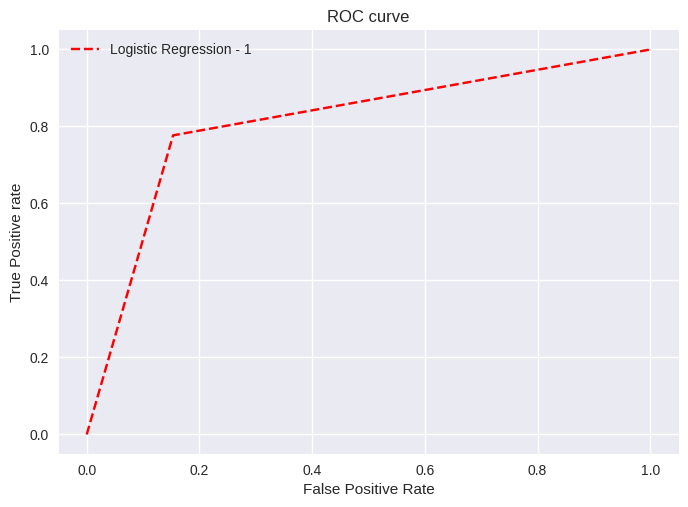

In [60]:
# plot roc curves
plt.plot(fpr2, tpr2, linestyle='--',color='red', label='Logistic Regression - 1')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### Random Forest - 1

In [61]:
RF = RandomForestClassifier(random_state=0)

In [62]:
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}


In [63]:
best = GridSearchCV(RF, param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=3, cv=5)
best.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV 2/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=28;, score=nan total time=   0.1s
[CV 1/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=34;, score=nan total time=   0.1s
[CV 2/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=34;, score=nan total time=   0.1s
[CV 3/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=34;, score=nan total time=   0.1s
[CV 4/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=34;, score=nan total time=   0.1s
[CV 4/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.0s
[CV 5/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=43;, score=nan total time=   0.0s
[CV 1/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.0s
[CV 2/5] END LR__C=10000.0, LR__penalty=l1, pca__n_components=44;, score=nan total time=   0.1s
[CV 1/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=5;, score=

[CV 3/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=18;, score=0.748 total time=   0.1s
[CV 3/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=23;, score=0.756 total time=   0.2s
[CV 4/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=23;, score=0.757 total time=   0.1s
[CV 5/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=23;, score=0.753 total time=   0.1s
[CV 1/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=24;, score=0.749 total time=   0.1s
[CV 5/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=29;, score=0.794 total time=   0.1s
[CV 1/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=30;, score=0.808 total time=   0.1s
[CV 2/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=30;, score=0.784 total time=   0.1s
[CV 3/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=30;, score=0.801 total time=   0.1s
[CV 2/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=36;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=1

[CV 2/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=44;, score=0.809 total time=   0.1s
[CV 3/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=44;, score=0.821 total time=   0.1s
[CV 4/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=44;, score=0.835 total time=   0.1s
[CV 5/5] END LR__C=10000.0, LR__penalty=l2, pca__n_components=44;, score=0.830 total time=   0.1s
[CV 2/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 3/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 4/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 5/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=7;, score=nan total time=   0.1s
[CV 4/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=13;, score=nan total time=   0.1s
[CV 5/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=13;, score=nan total t

[CV 1/5] END max_depth=1, max_features=sqrt, n_estimators=15;, score=0.709 total time=   0.1s
[CV 3/5] END max_depth=1, max_features=sqrt, n_estimators=37;, score=0.612 total time=   0.1s
[CV 4/5] END max_depth=1, max_features=sqrt, n_estimators=37;, score=0.645 total time=   0.1s
[CV 5/5] END max_depth=1, max_features=sqrt, n_estimators=37;, score=0.640 total time=   0.1s
[CV 1/5] END max_depth=1, max_features=sqrt, n_estimators=39;, score=0.660 total time=   0.1s
[CV 2/5] END max_depth=1, max_features=sqrt, n_estimators=39;, score=0.644 total time=   0.2s
[CV 3/5] END max_depth=1, max_features=sqrt, n_estimators=39;, score=0.617 total time=   0.2s
[CV 4/5] END max_depth=1, max_features=sqrt, n_estimators=39;, score=0.649 total time=   0.2s
[CV 5/5] END max_depth=1, max_features=sqrt, n_estimators=39;, score=0.655 total time=   0.1s
[CV 5/5] END max_depth=3, max_features=auto, n_estimators=1;, score=nan total time=   0.0s
[CV 1/5] END max_depth=3, max_features=auto, n_estimators=3;, s

[CV 3/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 4/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 5/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=3;, score=nan total time=   0.1s
[CV 4/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 5/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=9;, score=nan total time=   0.1s
[CV 1/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 2/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=10;, score=nan total time=   0.1s
[CV 5/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=16;, score=nan total time=   0.1s
[CV 1/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components=17;, score=nan total time=   0.1s
[CV 2/5] END LR__C=10000.0, LR__penalty=elasticnet, pca__n_components

[CV 5/5] END max_depth=3, max_features=log2, n_estimators=23;, score=0.787 total time=   0.1s
[CV 2/5] END max_depth=5, max_features=auto, n_estimators=23;, score=nan total time=   0.0s
[CV 3/5] END max_depth=5, max_features=auto, n_estimators=23;, score=nan total time=   0.0s
[CV 4/5] END max_depth=5, max_features=auto, n_estimators=23;, score=nan total time=   0.0s
[CV 5/5] END max_depth=5, max_features=auto, n_estimators=23;, score=nan total time=   0.0s
[CV 1/5] END max_depth=5, max_features=auto, n_estimators=25;, score=nan total time=   0.0s
[CV 2/5] END max_depth=5, max_features=auto, n_estimators=25;, score=nan total time=   0.0s
[CV 3/5] END max_depth=5, max_features=auto, n_estimators=25;, score=nan total time=   0.0s
[CV 4/5] END max_depth=5, max_features=auto, n_estimators=25;, score=nan total time=   0.0s
[CV 1/5] END max_depth=5, max_features=auto, n_estimators=33;, score=nan total time=   0.0s
[CV 2/5] END max_depth=5, max_features=auto, n_estimators=33;, score=nan total

[CV 1/5] END max_depth=7, max_features=auto, n_estimators=17;, score=nan total time=   0.0s
[CV 2/5] END max_depth=7, max_features=auto, n_estimators=17;, score=nan total time=   0.0s
[CV 3/5] END max_depth=7, max_features=auto, n_estimators=17;, score=nan total time=   0.0s
[CV 4/5] END max_depth=7, max_features=auto, n_estimators=17;, score=nan total time=   0.0s
[CV 5/5] END max_depth=7, max_features=auto, n_estimators=17;, score=nan total time=   0.0s
[CV 1/5] END max_depth=7, max_features=auto, n_estimators=19;, score=nan total time=   0.0s
[CV 2/5] END max_depth=7, max_features=auto, n_estimators=19;, score=nan total time=   0.0s
[CV 3/5] END max_depth=7, max_features=auto, n_estimators=19;, score=nan total time=   0.0s
[CV 4/5] END max_depth=7, max_features=auto, n_estimators=19;, score=nan total time=   0.0s
[CV 5/5] END max_depth=7, max_features=auto, n_estimators=19;, score=nan total time=   0.0s
[CV 1/5] END max_depth=7, max_features=auto, n_estimators=21;, score=nan total t

[CV 3/5] END max_depth=3, max_features=log2, n_estimators=25;, score=0.752 total time=   0.1s
[CV 4/5] END max_depth=3, max_features=log2, n_estimators=25;, score=0.790 total time=   0.1s
[CV 5/5] END max_depth=3, max_features=log2, n_estimators=25;, score=0.784 total time=   0.1s
[CV 1/5] END max_depth=3, max_features=log2, n_estimators=27;, score=0.746 total time=   0.1s
[CV 2/5] END max_depth=3, max_features=log2, n_estimators=27;, score=0.749 total time=   0.1s
[CV 3/5] END max_depth=3, max_features=log2, n_estimators=27;, score=0.755 total time=   0.1s
[CV 4/5] END max_depth=5, max_features=sqrt, n_estimators=11;, score=0.811 total time=   0.1s
[CV 5/5] END max_depth=5, max_features=sqrt, n_estimators=11;, score=0.802 total time=   0.1s
[CV 1/5] END max_depth=5, max_features=sqrt, n_estimators=13;, score=0.775 total time=   0.1s
[CV 2/5] END max_depth=5, max_features=sqrt, n_estimators=13;, score=0.796 total time=   0.1s
[CV 3/5] END max_depth=5, max_features=sqrt, n_estimators=13

[CV 5/5] END max_depth=9, max_features=auto, n_estimators=3;, score=nan total time=   0.0s
[CV 1/5] END max_depth=9, max_features=auto, n_estimators=5;, score=nan total time=   0.0s
[CV 2/5] END max_depth=9, max_features=auto, n_estimators=5;, score=nan total time=   0.0s
[CV 3/5] END max_depth=9, max_features=auto, n_estimators=5;, score=nan total time=   0.0s
[CV 4/5] END max_depth=9, max_features=auto, n_estimators=5;, score=nan total time=   0.0s
[CV 5/5] END max_depth=9, max_features=auto, n_estimators=5;, score=nan total time=   0.0s
[CV 1/5] END max_depth=9, max_features=auto, n_estimators=7;, score=nan total time=   0.0s
[CV 2/5] END max_depth=9, max_features=auto, n_estimators=7;, score=nan total time=   0.0s
[CV 3/5] END max_depth=9, max_features=auto, n_estimators=7;, score=nan total time=   0.0s
[CV 4/5] END max_depth=9, max_features=auto, n_estimators=7;, score=nan total time=   0.0s
[CV 5/5] END max_depth=9, max_features=auto, n_estimators=7;, score=nan total time=   0.0s

[CV 5/5] END max_depth=13, max_features=auto, n_estimators=1;, score=nan total time=   0.0s
[CV 1/5] END max_depth=13, max_features=auto, n_estimators=3;, score=nan total time=   0.0s
[CV 2/5] END max_depth=13, max_features=auto, n_estimators=3;, score=nan total time=   0.0s
[CV 3/5] END max_depth=13, max_features=auto, n_estimators=3;, score=nan total time=   0.0s
[CV 4/5] END max_depth=13, max_features=auto, n_estimators=3;, score=nan total time=   0.0s
[CV 5/5] END max_depth=13, max_features=auto, n_estimators=3;, score=nan total time=   0.0s
[CV 1/5] END max_depth=13, max_features=auto, n_estimators=5;, score=nan total time=   0.0s
[CV 2/5] END max_depth=13, max_features=auto, n_estimators=5;, score=nan total time=   0.0s
[CV 3/5] END max_depth=13, max_features=auto, n_estimators=5;, score=nan total time=   0.0s
[CV 4/5] END max_depth=13, max_features=auto, n_estimators=5;, score=nan total time=   0.0s
[CV 5/5] END max_depth=13, max_features=auto, n_estimators=5;, score=nan total t

[CV 1/5] END max_depth=15, max_features=auto, n_estimators=3;, score=nan total time=   0.0s[CV 5/5] END max_depth=7, max_features=log2, n_estimators=25;, score=0.827 total time=   0.2s
[CV 1/5] END max_depth=7, max_features=log2, n_estimators=27;, score=0.814 total time=   0.2s
[CV 2/5] END max_depth=7, max_features=log2, n_estimators=27;, score=0.817 total time=   0.2s
[CV 3/5] END max_depth=7, max_features=log2, n_estimators=27;, score=0.827 total time=   0.2s
[CV 5/5] END max_depth=9, max_features=sqrt, n_estimators=9;, score=0.826 total time=   0.1s
[CV 1/5] END max_depth=9, max_features=sqrt, n_estimators=11;, score=0.809 total time=   0.1s
[CV 2/5] END max_depth=9, max_features=sqrt, n_estimators=11;, score=0.810 total time=   0.1s
[CV 3/5] END max_depth=9, max_features=sqrt, n_estimators=11;, score=0.839 total time=   0.1s
[CV 5/5] END max_depth=9, max_features=sqrt, n_estimators=17;, score=0.832 total time=   0.1s
[CV 1/5] END max_depth=9, max_features=sqrt, n_estimators=19;, s

[CV 1/5] END max_depth=11, max_features=auto, n_estimators=27;, score=nan total time=   0.0s
[CV 2/5] END max_depth=11, max_features=auto, n_estimators=27;, score=nan total time=   0.0s
[CV 3/5] END max_depth=11, max_features=auto, n_estimators=27;, score=nan total time=   0.0s
[CV 3/5] END max_depth=11, max_features=auto, n_estimators=29;, score=nan total time=   0.0s
[CV 4/5] END max_depth=11, max_features=auto, n_estimators=29;, score=nan total time=   0.0s
[CV 5/5] END max_depth=11, max_features=auto, n_estimators=29;, score=nan total time=   0.0s
[CV 1/5] END max_depth=11, max_features=auto, n_estimators=31;, score=nan total time=   0.0s
[CV 1/5] END max_depth=11, max_features=auto, n_estimators=33;, score=nan total time=   0.0s
[CV 2/5] END max_depth=11, max_features=auto, n_estimators=33;, score=nan total time=   0.0s
[CV 3/5] END max_depth=11, max_features=auto, n_estimators=33;, score=nan total time=   0.0s
[CV 4/5] END max_depth=11, max_features=auto, n_estimators=33;, score=

[CV 4/5] END max_depth=11, max_features=log2, n_estimators=7;, score=0.825 total time=   0.1s
[CV 5/5] END max_depth=11, max_features=log2, n_estimators=7;, score=0.823 total time=   0.1s
[CV 5/5] END max_depth=11, max_features=log2, n_estimators=17;, score=0.835 total time=   0.1s
[CV 1/5] END max_depth=11, max_features=log2, n_estimators=19;, score=0.821 total time=   0.2s
[CV 2/5] END max_depth=11, max_features=log2, n_estimators=19;, score=0.821 total time=   0.2s
[CV 3/5] END max_depth=11, max_features=log2, n_estimators=19;, score=0.848 total time=   0.2s
[CV 4/5] END max_depth=11, max_features=log2, n_estimators=19;, score=0.852 total time=   0.2s
[CV 5/5] END max_depth=11, max_features=log2, n_estimators=19;, score=0.828 total time=   0.2s
[CV 1/5] END max_depth=11, max_features=log2, n_estimators=21;, score=0.825 total time=   0.2s
[CV 2/5] END max_depth=11, max_features=log2, n_estimators=21;, score=0.822 total time=   0.2s
[CV 3/5] END max_depth=13, max_features=auto, n_esti

[CV 4/5] END max_depth=11, max_features=auto, n_estimators=31;, score=nan total time=   0.0s
[CV 5/5] END max_depth=11, max_features=auto, n_estimators=31;, score=nan total time=   0.0s
[CV 4/5] END max_depth=11, max_features=auto, n_estimators=35;, score=nan total time=   0.0s
[CV 5/5] END max_depth=11, max_features=auto, n_estimators=35;, score=nan total time=   0.0s
[CV 1/5] END max_depth=11, max_features=auto, n_estimators=37;, score=nan total time=   0.0s
[CV 2/5] END max_depth=11, max_features=auto, n_estimators=37;, score=nan total time=   0.0s
[CV 2/5] END max_depth=11, max_features=auto, n_estimators=39;, score=nan total time=   0.0s
[CV 3/5] END max_depth=11, max_features=auto, n_estimators=39;, score=nan total time=   0.0s
[CV 4/5] END max_depth=11, max_features=auto, n_estimators=39;, score=nan total time=   0.0s
[CV 5/5] END max_depth=11, max_features=auto, n_estimators=39;, score=nan total time=   0.0s
[CV 5/5] END max_depth=11, max_features=sqrt, n_estimators=1;, score=0

[CV 5/5] END max_depth=13, max_features=sqrt, n_estimators=23;, score=0.837 total time=   0.2s
[CV 5/5] END max_depth=13, max_features=log2, n_estimators=9;, score=0.815 total time=   0.1s
[CV 3/5] END max_depth=13, max_features=log2, n_estimators=11;, score=0.841 total time=   0.1s
[CV 1/5] END max_depth=13, max_features=log2, n_estimators=13;, score=0.821 total time=   0.2s
[CV 5/5] END max_depth=13, max_features=log2, n_estimators=13;, score=0.822 total time=   0.1s
[CV 4/5] END max_depth=13, max_features=log2, n_estimators=15;, score=0.861 total time=   0.1s
[CV 4/5] END max_depth=13, max_features=log2, n_estimators=17;, score=0.865 total time=   0.2s
[CV 4/5] END max_depth=13, max_features=log2, n_estimators=19;, score=0.868 total time=   0.2s
[CV 4/5] END max_depth=13, max_features=log2, n_estimators=21;, score=0.864 total time=   0.2s
[CV 5/5] END max_depth=13, max_features=log2, n_estimators=23;, score=0.826 total time=   0.2s
[CV 5/5] END max_depth=13, max_features=log2, n_est

[CV 5/5] END max_depth=15, max_features=sqrt, n_estimators=15;, score=0.841 total time=   0.2s
[CV 2/5] END max_depth=15, max_features=sqrt, n_estimators=39;, score=0.837 total time=   0.4s
[CV 3/5] END max_depth=15, max_features=sqrt, n_estimators=39;, score=0.853 total time=   0.6s
[CV 4/5] END max_depth=15, max_features=sqrt, n_estimators=39;, score=0.866 total time=   0.4s
[CV 5/5] END max_depth=15, max_features=sqrt, n_estimators=39;, score=0.837 total time=   0.4s
[CV 1/5] END max_depth=15, max_features=log2, n_estimators=1;, score=0.740 total time=   0.0s
[CV 2/5] END max_depth=15, max_features=log2, n_estimators=1;, score=0.744 total time=   0.0s
[CV 3/5] END max_depth=15, max_features=log2, n_estimators=1;, score=0.763 total time=   0.0s
[CV 4/5] END max_depth=15, max_features=log2, n_estimators=1;, score=0.761 total time=   0.0s
[CV 4/5] END max_depth=15, max_features=log2, n_estimators=27;, score=0.863 total time=   0.4s
[CV 5/5] END max_depth=15, max_features=log2, n_estima

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='accuracy', verbose=3)

In [64]:
y_pred = best.predict(X_test)

In [65]:
best.score(X_train, y_train)

0.9732497120184308

In [66]:
best.score(X_test, y_test)

0.8474171394446103

In [67]:
metrics_score(y_test, y_pred)

The accuracy score is:  0.8474171394446103
The precision score is:  0.8124274099883856
The r2 score is:  0.3879974709383206
The f1 score is:  0.8455726805681475


In [68]:
fpr3, tpr3, thresh3 = roc_curve(y_test, y_pred, pos_label=1)
auc_score1 = roc_auc_score(y_test, y_pred)

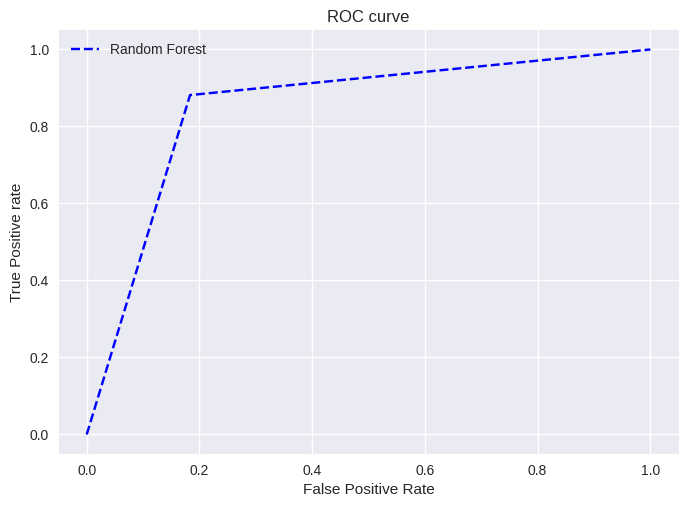

In [69]:
# plot roc curves
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='Random Forest')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### Random Forest - 2

In [109]:
RF = RandomForestClassifier(random_state=0)

In [113]:
param_grid = {'n_estimators': [5*n+50 for n in range(50)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}
param_grid

{'n_estimators': [50,
  55,
  60,
  65,
  70,
  75,
  80,
  85,
  90,
  95,
  100,
  105,
  110,
  115,
  120,
  125,
  130,
  135,
  140,
  145,
  150,
  155,
  160,
  165,
  170,
  175,
  180,
  185,
  190,
  195,
  200,
  205,
  210,
  215,
  220,
  225,
  230,
  235,
  240,
  245,
  250,
  255,
  260,
  265,
  270,
  275,
  280,
  285,
  290,
  295],
 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
 'max_features': ['auto', 'sqrt', 'log2']}

In [114]:
best2 = GridSearchCV(RF, param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=3, cv=5)
best2.fit(X_train, y_train)

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
[CV 1/5] END max_depth=1, max_features=auto, n_estimators=50;, score=nan total time=   0.0s
[CV 4/5] END max_depth=1, max_features=auto, n_estimators=55;, score=nan total time=   0.0s
[CV 5/5] END max_depth=1, max_features=auto, n_estimators=55;, score=nan total time=   0.0s
[CV 1/5] END max_depth=1, max_features=auto, n_estimators=60;, score=nan total time=   0.0s
[CV 2/5] END max_depth=1, max_features=auto, n_estimators=60;, score=nan total time=   0.0s
[CV 3/5] END max_depth=1, max_features=auto, n_estimators=60;, score=nan total time=   0.0s
[CV 4/5] END max_depth=1, max_features=auto, n_estimators=60;, score=nan total time=   0.0s
[CV 5/5] END max_depth=1, max_features=auto, n_estimators=60;, score=nan total time=   0.0s
[CV 1/5] END max_depth=1, max_features=auto, n_estimators=65;, score=nan total time=   0.0s
[CV 2/5] END max_depth=1, max_features=auto, n_estimators=65;, score=nan total time=   0.0s
[CV 3/5] END ma

[CV 1/5] END max_depth=1, max_features=auto, n_estimators=55;, score=nan total time=   0.0s
[CV 4/5] END max_depth=1, max_features=auto, n_estimators=75;, score=nan total time=   0.0s
[CV 1/5] END max_depth=1, max_features=auto, n_estimators=80;, score=nan total time=   0.0s
[CV 3/5] END max_depth=1, max_features=auto, n_estimators=80;, score=nan total time=   0.0s
[CV 5/5] END max_depth=1, max_features=auto, n_estimators=80;, score=nan total time=   0.0s
[CV 3/5] END max_depth=1, max_features=auto, n_estimators=90;, score=nan total time=   0.0s
[CV 1/5] END max_depth=1, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END max_depth=1, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END max_depth=1, max_features=auto, n_estimators=110;, score=nan total time=   0.0s
[CV 1/5] END max_depth=1, max_features=auto, n_estimators=115;, score=nan total time=   0.0s
[CV 1/5] END max_depth=1, max_features=auto, n_estimators=130;, score=nan to

[CV 4/5] END max_depth=1, max_features=auto, n_estimators=50;, score=nan total time=   0.0s
[CV 4/5] END max_depth=1, max_features=auto, n_estimators=70;, score=nan total time=   0.0s
[CV 1/5] END max_depth=1, max_features=auto, n_estimators=75;, score=nan total time=   0.0s
[CV 3/5] END max_depth=1, max_features=auto, n_estimators=75;, score=nan total time=   0.0s
[CV 2/5] END max_depth=1, max_features=auto, n_estimators=80;, score=nan total time=   0.0s
[CV 4/5] END max_depth=1, max_features=auto, n_estimators=80;, score=nan total time=   0.0s
[CV 1/5] END max_depth=1, max_features=auto, n_estimators=90;, score=nan total time=   0.0s
[CV 3/5] END max_depth=1, max_features=auto, n_estimators=95;, score=nan total time=   0.0s
[CV 1/5] END max_depth=1, max_features=auto, n_estimators=110;, score=nan total time=   0.0s
[CV 2/5] END max_depth=1, max_features=auto, n_estimators=110;, score=nan total time=   0.0s
[CV 2/5] END max_depth=1, max_features=auto, n_estimators=125;, score=nan tota

[CV 3/5] END max_depth=1, max_features=auto, n_estimators=50;, score=nan total time=   0.0s
[CV 1/5] END max_depth=1, max_features=auto, n_estimators=85;, score=nan total time=   0.0s
[CV 4/5] END max_depth=1, max_features=auto, n_estimators=85;, score=nan total time=   0.0s
[CV 5/5] END max_depth=1, max_features=auto, n_estimators=90;, score=nan total time=   0.0s
[CV 5/5] END max_depth=1, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END max_depth=1, max_features=auto, n_estimators=105;, score=nan total time=   0.0s
[CV 1/5] END max_depth=1, max_features=auto, n_estimators=120;, score=nan total time=   0.0s
[CV 2/5] END max_depth=1, max_features=auto, n_estimators=120;, score=nan total time=   0.0s
[CV 3/5] END max_depth=1, max_features=auto, n_estimators=140;, score=nan total time=   0.0s
[CV 4/5] END max_depth=1, max_features=auto, n_estimators=140;, score=nan total time=   0.0s
[CV 5/5] END max_depth=1, max_features=auto, n_estimators=140;, score=nan 

[CV 1/5] END max_depth=3, max_features=auto, n_estimators=50;, score=nan total time=   0.0s
[CV 2/5] END max_depth=3, max_features=auto, n_estimators=50;, score=nan total time=   0.0s
[CV 3/5] END max_depth=3, max_features=auto, n_estimators=50;, score=nan total time=   0.0s
[CV 4/5] END max_depth=3, max_features=auto, n_estimators=50;, score=nan total time=   0.0s
[CV 1/5] END max_depth=3, max_features=auto, n_estimators=55;, score=nan total time=   0.0s
[CV 3/5] END max_depth=3, max_features=auto, n_estimators=55;, score=nan total time=   0.0s
[CV 5/5] END max_depth=3, max_features=auto, n_estimators=55;, score=nan total time=   0.0s
[CV 2/5] END max_depth=3, max_features=auto, n_estimators=60;, score=nan total time=   0.0s
[CV 4/5] END max_depth=3, max_features=auto, n_estimators=60;, score=nan total time=   0.0s
[CV 1/5] END max_depth=3, max_features=auto, n_estimators=65;, score=nan total time=   0.0s
[CV 3/5] END max_depth=3, max_features=auto, n_estimators=65;, score=nan total t

[CV 2/5] END max_depth=3, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END max_depth=3, max_features=auto, n_estimators=105;, score=nan total time=   0.0s
[CV 3/5] END max_depth=3, max_features=auto, n_estimators=105;, score=nan total time=   0.0s
[CV 2/5] END max_depth=3, max_features=auto, n_estimators=115;, score=nan total time=   0.0s
[CV 3/5] END max_depth=3, max_features=auto, n_estimators=115;, score=nan total time=   0.0s
[CV 4/5] END max_depth=3, max_features=auto, n_estimators=115;, score=nan total time=   0.0s
[CV 5/5] END max_depth=3, max_features=auto, n_estimators=115;, score=nan total time=   0.0s
[CV 5/5] END max_depth=3, max_features=auto, n_estimators=120;, score=nan total time=   0.0s
[CV 1/5] END max_depth=3, max_features=auto, n_estimators=125;, score=nan total time=   0.0s
[CV 2/5] END max_depth=3, max_features=auto, n_estimators=125;, score=nan total time=   0.0s
[CV 3/5] END max_depth=3, max_features=auto, n_estimators=125;, score=

[CV 5/5] END max_depth=3, max_features=sqrt, n_estimators=190;, score=0.787 total time=   0.8s
[CV 1/5] END max_depth=3, max_features=sqrt, n_estimators=195;, score=0.757 total time=   0.8s
[CV 2/5] END max_depth=3, max_features=sqrt, n_estimators=195;, score=0.768 total time=   0.8s
[CV 3/5] END max_depth=3, max_features=sqrt, n_estimators=195;, score=0.783 total time=   0.8s
[CV 4/5] END max_depth=3, max_features=sqrt, n_estimators=195;, score=0.801 total time=   0.9s
[CV 5/5] END max_depth=3, max_features=sqrt, n_estimators=195;, score=0.789 total time=   1.0s
[CV 1/5] END max_depth=3, max_features=sqrt, n_estimators=200;, score=0.757 total time=   1.0s
[CV 2/5] END max_depth=3, max_features=sqrt, n_estimators=200;, score=0.765 total time=   0.8s
[CV 3/5] END max_depth=3, max_features=sqrt, n_estimators=200;, score=0.784 total time=   0.8s
[CV 4/5] END max_depth=3, max_features=sqrt, n_estimators=200;, score=0.802 total time=   0.9s
[CV 5/5] END max_depth=3, max_features=sqrt, n_est

[CV 5/5] END max_depth=3, max_features=sqrt, n_estimators=85;, score=0.801 total time=   0.4s
[CV 1/5] END max_depth=3, max_features=sqrt, n_estimators=90;, score=0.762 total time=   0.5s
[CV 2/5] END max_depth=3, max_features=sqrt, n_estimators=90;, score=0.774 total time=   0.4s
[CV 3/5] END max_depth=3, max_features=sqrt, n_estimators=90;, score=0.777 total time=   0.4s
[CV 4/5] END max_depth=3, max_features=sqrt, n_estimators=90;, score=0.804 total time=   0.5s
[CV 5/5] END max_depth=3, max_features=sqrt, n_estimators=90;, score=0.789 total time=   0.4s
[CV 1/5] END max_depth=3, max_features=sqrt, n_estimators=95;, score=0.762 total time=   0.4s
[CV 2/5] END max_depth=3, max_features=sqrt, n_estimators=95;, score=0.776 total time=   0.4s
[CV 3/5] END max_depth=3, max_features=sqrt, n_estimators=95;, score=0.777 total time=   0.5s
[CV 1/5] END max_depth=3, max_features=sqrt, n_estimators=210;, score=0.756 total time=   0.9s
[CV 2/5] END max_depth=3, max_features=sqrt, n_estimators=2

[CV 4/5] END max_depth=1, max_features=log2, n_estimators=200;, score=0.705 total time=   0.7s
[CV 2/5] END max_depth=1, max_features=log2, n_estimators=210;, score=0.710 total time=   0.7s
[CV 5/5] END max_depth=1, max_features=log2, n_estimators=215;, score=0.713 total time=   0.8s
[CV 2/5] END max_depth=1, max_features=log2, n_estimators=225;, score=0.714 total time=   0.7s
[CV 4/5] END max_depth=1, max_features=log2, n_estimators=230;, score=0.712 total time=   0.8s
[CV 2/5] END max_depth=1, max_features=log2, n_estimators=240;, score=0.709 total time=   0.8s
[CV 5/5] END max_depth=1, max_features=log2, n_estimators=245;, score=0.711 total time=   0.8s
[CV 2/5] END max_depth=1, max_features=log2, n_estimators=255;, score=0.690 total time=   1.0s
[CV 1/5] END max_depth=1, max_features=log2, n_estimators=265;, score=0.716 total time=   1.0s
[CV 5/5] END max_depth=1, max_features=log2, n_estimators=270;, score=0.693 total time=   0.8s
[CV 1/5] END max_depth=1, max_features=log2, n_est

[CV 5/5] END max_depth=1, max_features=log2, n_estimators=260;, score=0.693 total time=   0.9s
[CV 2/5] END max_depth=1, max_features=log2, n_estimators=270;, score=0.687 total time=   0.8s
[CV 5/5] END max_depth=1, max_features=log2, n_estimators=275;, score=0.691 total time=   1.1s
[CV 1/5] END max_depth=1, max_features=log2, n_estimators=290;, score=0.712 total time=   1.0s
[CV 5/5] END max_depth=1, max_features=log2, n_estimators=295;, score=0.689 total time=   0.9s
[CV 3/5] END max_depth=3, max_features=sqrt, n_estimators=160;, score=0.781 total time=   0.7s
[CV 4/5] END max_depth=3, max_features=sqrt, n_estimators=160;, score=0.802 total time=   0.7s
[CV 5/5] END max_depth=3, max_features=sqrt, n_estimators=160;, score=0.783 total time=   0.7s
[CV 1/5] END max_depth=3, max_features=sqrt, n_estimators=165;, score=0.756 total time=   0.7s
[CV 2/5] END max_depth=3, max_features=sqrt, n_estimators=165;, score=0.766 total time=   0.8s
[CV 3/5] END max_depth=3, max_features=sqrt, n_est

[CV 4/5] END max_depth=5, max_features=auto, n_estimators=160;, score=nan total time=   0.0s
[CV 5/5] END max_depth=5, max_features=auto, n_estimators=160;, score=nan total time=   0.0s
[CV 1/5] END max_depth=5, max_features=auto, n_estimators=165;, score=nan total time=   0.0s
[CV 5/5] END max_depth=5, max_features=auto, n_estimators=170;, score=nan total time=   0.0s
[CV 1/5] END max_depth=5, max_features=auto, n_estimators=175;, score=nan total time=   0.0s
[CV 2/5] END max_depth=5, max_features=auto, n_estimators=175;, score=nan total time=   0.0s
[CV 3/5] END max_depth=5, max_features=auto, n_estimators=175;, score=nan total time=   0.0s
[CV 4/5] END max_depth=5, max_features=auto, n_estimators=195;, score=nan total time=   0.0s
[CV 5/5] END max_depth=5, max_features=auto, n_estimators=195;, score=nan total time=   0.0s
[CV 1/5] END max_depth=5, max_features=auto, n_estimators=200;, score=nan total time=   0.0s
[CV 2/5] END max_depth=5, max_features=auto, n_estimators=200;, score=

[CV 2/5] END max_depth=5, max_features=sqrt, n_estimators=260;, score=0.801 total time=   1.4s
[CV 3/5] END max_depth=5, max_features=sqrt, n_estimators=260;, score=0.816 total time=   1.4s
[CV 4/5] END max_depth=5, max_features=sqrt, n_estimators=260;, score=0.821 total time=   1.5s
[CV 5/5] END max_depth=5, max_features=sqrt, n_estimators=260;, score=0.818 total time=   1.4s
[CV 1/5] END max_depth=5, max_features=sqrt, n_estimators=265;, score=0.790 total time=   1.4s
[CV 2/5] END max_depth=5, max_features=sqrt, n_estimators=265;, score=0.799 total time=   1.4s
[CV 3/5] END max_depth=5, max_features=sqrt, n_estimators=265;, score=0.816 total time=   1.4s
[CV 5/5] END max_depth=5, max_features=log2, n_estimators=145;, score=0.809 total time=   0.7s
[CV 1/5] END max_depth=5, max_features=log2, n_estimators=155;, score=0.783 total time=   0.8s
[CV 3/5] END max_depth=5, max_features=log2, n_estimators=160;, score=0.802 total time=   0.8s
[CV 5/5] END max_depth=5, max_features=log2, n_est

[CV 2/5] END max_depth=5, max_features=auto, n_estimators=250;, score=nan total time=   0.0s
[CV 3/5] END max_depth=5, max_features=auto, n_estimators=250;, score=nan total time=   0.0s
[CV 4/5] END max_depth=5, max_features=auto, n_estimators=250;, score=nan total time=   0.0s
[CV 2/5] END max_depth=5, max_features=auto, n_estimators=285;, score=nan total time=   0.0s
[CV 3/5] END max_depth=5, max_features=auto, n_estimators=285;, score=nan total time=   0.0s
[CV 4/5] END max_depth=5, max_features=auto, n_estimators=285;, score=nan total time=   0.0s
[CV 5/5] END max_depth=5, max_features=auto, n_estimators=285;, score=nan total time=   0.0s
[CV 1/5] END max_depth=5, max_features=auto, n_estimators=290;, score=nan total time=   0.0s
[CV 2/5] END max_depth=5, max_features=auto, n_estimators=290;, score=nan total time=   0.0s
[CV 3/5] END max_depth=5, max_features=auto, n_estimators=290;, score=nan total time=   0.0s
[CV 4/5] END max_depth=5, max_features=auto, n_estimators=290;, score=

[CV 3/5] END max_depth=7, max_features=auto, n_estimators=85;, score=nan total time=   0.0s
[CV 4/5] END max_depth=7, max_features=auto, n_estimators=85;, score=nan total time=   0.0s
[CV 5/5] END max_depth=7, max_features=auto, n_estimators=85;, score=nan total time=   0.0s
[CV 1/5] END max_depth=7, max_features=auto, n_estimators=90;, score=nan total time=   0.0s
[CV 2/5] END max_depth=7, max_features=auto, n_estimators=90;, score=nan total time=   0.0s
[CV 5/5] END max_depth=7, max_features=auto, n_estimators=90;, score=nan total time=   0.0s
[CV 1/5] END max_depth=7, max_features=auto, n_estimators=95;, score=nan total time=   0.0s
[CV 1/5] END max_depth=7, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END max_depth=7, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END max_depth=7, max_features=auto, n_estimators=105;, score=nan total time=   0.0s
[CV 3/5] END max_depth=7, max_features=auto, n_estimators=105;, score=nan tot

[CV 5/5] END max_depth=5, max_features=sqrt, n_estimators=280;, score=0.817 total time=   1.4s
[CV 1/5] END max_depth=5, max_features=sqrt, n_estimators=285;, score=0.787 total time=   1.5s
[CV 2/5] END max_depth=5, max_features=sqrt, n_estimators=285;, score=0.800 total time=   1.5s
[CV 3/5] END max_depth=5, max_features=sqrt, n_estimators=285;, score=0.814 total time=   1.5s
[CV 4/5] END max_depth=5, max_features=sqrt, n_estimators=285;, score=0.822 total time=   1.5s
[CV 5/5] END max_depth=5, max_features=sqrt, n_estimators=285;, score=0.816 total time=   1.4s
[CV 1/5] END max_depth=5, max_features=sqrt, n_estimators=290;, score=0.788 total time=   1.5s
[CV 2/5] END max_depth=5, max_features=sqrt, n_estimators=290;, score=0.800 total time=   1.5s
[CV 3/5] END max_depth=5, max_features=sqrt, n_estimators=290;, score=0.813 total time=   1.7s
[CV 4/5] END max_depth=5, max_features=sqrt, n_estimators=290;, score=0.821 total time=   1.5s
[CV 5/5] END max_depth=5, max_features=sqrt, n_est

[CV 1/5] END max_depth=5, max_features=log2, n_estimators=85;, score=0.783 total time=   0.4s
[CV 4/5] END max_depth=5, max_features=log2, n_estimators=85;, score=0.830 total time=   0.4s
[CV 2/5] END max_depth=5, max_features=log2, n_estimators=90;, score=0.804 total time=   0.4s
[CV 5/5] END max_depth=5, max_features=log2, n_estimators=90;, score=0.802 total time=   0.5s
[CV 3/5] END max_depth=5, max_features=log2, n_estimators=95;, score=0.802 total time=   0.5s
[CV 2/5] END max_depth=5, max_features=log2, n_estimators=100;, score=0.804 total time=   0.5s
[CV 1/5] END max_depth=5, max_features=log2, n_estimators=105;, score=0.777 total time=   0.5s
[CV 5/5] END max_depth=5, max_features=log2, n_estimators=105;, score=0.802 total time=   0.5s
[CV 4/5] END max_depth=5, max_features=log2, n_estimators=110;, score=0.823 total time=   0.5s
[CV 3/5] END max_depth=5, max_features=log2, n_estimators=115;, score=0.800 total time=   0.6s
[CV 2/5] END max_depth=5, max_features=log2, n_estimato

[CV 5/5] END max_depth=7, max_features=sqrt, n_estimators=70;, score=0.826 total time=   0.5s
[CV 1/5] END max_depth=7, max_features=sqrt, n_estimators=75;, score=0.815 total time=   0.5s
[CV 2/5] END max_depth=7, max_features=sqrt, n_estimators=75;, score=0.818 total time=   0.5s
[CV 3/5] END max_depth=7, max_features=sqrt, n_estimators=75;, score=0.840 total time=   0.5s
[CV 4/5] END max_depth=7, max_features=sqrt, n_estimators=75;, score=0.844 total time=   0.5s
[CV 5/5] END max_depth=7, max_features=sqrt, n_estimators=75;, score=0.827 total time=   0.5s
[CV 1/5] END max_depth=7, max_features=sqrt, n_estimators=80;, score=0.816 total time=   0.5s
[CV 2/5] END max_depth=7, max_features=sqrt, n_estimators=80;, score=0.821 total time=   0.5s
[CV 3/5] END max_depth=7, max_features=sqrt, n_estimators=80;, score=0.839 total time=   0.5s
[CV 4/5] END max_depth=7, max_features=sqrt, n_estimators=80;, score=0.844 total time=   0.5s
[CV 5/5] END max_depth=7, max_features=sqrt, n_estimators=80

[CV 1/5] END max_depth=7, max_features=sqrt, n_estimators=130;, score=0.816 total time=   0.8s
[CV 2/5] END max_depth=7, max_features=sqrt, n_estimators=130;, score=0.820 total time=   0.9s
[CV 3/5] END max_depth=7, max_features=sqrt, n_estimators=130;, score=0.840 total time=   0.9s
[CV 4/5] END max_depth=7, max_features=sqrt, n_estimators=130;, score=0.846 total time=   0.9s
[CV 2/5] END max_depth=7, max_features=sqrt, n_estimators=245;, score=0.819 total time=   1.5s
[CV 3/5] END max_depth=7, max_features=sqrt, n_estimators=245;, score=0.840 total time=   1.5s
[CV 4/5] END max_depth=7, max_features=sqrt, n_estimators=245;, score=0.851 total time=   1.5s
[CV 5/5] END max_depth=7, max_features=sqrt, n_estimators=245;, score=0.826 total time=   1.5s
[CV 1/5] END max_depth=7, max_features=sqrt, n_estimators=250;, score=0.820 total time=   1.5s
[CV 2/5] END max_depth=7, max_features=sqrt, n_estimators=250;, score=0.820 total time=   1.6s
[CV 3/5] END max_depth=7, max_features=sqrt, n_est

[CV 2/5] END max_depth=7, max_features=sqrt, n_estimators=195;, score=0.816 total time=   1.2s
[CV 3/5] END max_depth=7, max_features=sqrt, n_estimators=195;, score=0.841 total time=   1.3s
[CV 1/5] END max_depth=7, max_features=log2, n_estimators=60;, score=0.812 total time=   0.4s
[CV 2/5] END max_depth=7, max_features=log2, n_estimators=60;, score=0.820 total time=   0.4s
[CV 3/5] END max_depth=7, max_features=log2, n_estimators=60;, score=0.833 total time=   0.4s
[CV 4/5] END max_depth=7, max_features=log2, n_estimators=60;, score=0.851 total time=   0.4s
[CV 5/5] END max_depth=7, max_features=log2, n_estimators=60;, score=0.825 total time=   0.4s
[CV 1/5] END max_depth=7, max_features=log2, n_estimators=65;, score=0.809 total time=   0.4s
[CV 3/5] END max_depth=7, max_features=log2, n_estimators=65;, score=0.834 total time=   0.4s
[CV 5/5] END max_depth=7, max_features=log2, n_estimators=65;, score=0.825 total time=   0.4s
[CV 2/5] END max_depth=7, max_features=log2, n_estimators=

[CV 2/5] END max_depth=9, max_features=sqrt, n_estimators=90;, score=0.826 total time=   0.7s
[CV 3/5] END max_depth=9, max_features=sqrt, n_estimators=90;, score=0.848 total time=   0.7s
[CV 4/5] END max_depth=9, max_features=sqrt, n_estimators=90;, score=0.852 total time=   0.7s
[CV 5/5] END max_depth=9, max_features=sqrt, n_estimators=90;, score=0.832 total time=   0.7s
[CV 1/5] END max_depth=9, max_features=sqrt, n_estimators=95;, score=0.826 total time=   0.7s
[CV 2/5] END max_depth=9, max_features=sqrt, n_estimators=95;, score=0.826 total time=   0.7s
[CV 3/5] END max_depth=9, max_features=sqrt, n_estimators=95;, score=0.849 total time=   0.7s
[CV 4/5] END max_depth=9, max_features=sqrt, n_estimators=95;, score=0.851 total time=   0.7s
[CV 5/5] END max_depth=9, max_features=sqrt, n_estimators=95;, score=0.835 total time=   0.7s
[CV 1/5] END max_depth=9, max_features=sqrt, n_estimators=100;, score=0.829 total time=   0.7s
[CV 2/5] END max_depth=9, max_features=sqrt, n_estimators=1

[CV 5/5] END max_depth=11, max_features=auto, n_estimators=175;, score=nan total time=   0.0s
[CV 1/5] END max_depth=11, max_features=auto, n_estimators=180;, score=nan total time=   0.0s
[CV 2/5] END max_depth=11, max_features=auto, n_estimators=180;, score=nan total time=   0.0s
[CV 3/5] END max_depth=11, max_features=auto, n_estimators=180;, score=nan total time=   0.0s
[CV 4/5] END max_depth=11, max_features=auto, n_estimators=180;, score=nan total time=   0.0s
[CV 5/5] END max_depth=11, max_features=auto, n_estimators=180;, score=nan total time=   0.0s
[CV 1/5] END max_depth=11, max_features=auto, n_estimators=185;, score=nan total time=   0.0s
[CV 2/5] END max_depth=11, max_features=auto, n_estimators=185;, score=nan total time=   0.0s
[CV 3/5] END max_depth=11, max_features=auto, n_estimators=185;, score=nan total time=   0.0s
[CV 2/5] END max_depth=11, max_features=auto, n_estimators=195;, score=nan total time=   0.0s
[CV 3/5] END max_depth=11, max_features=auto, n_estimators=1

[CV 2/5] END max_depth=9, max_features=log2, n_estimators=75;, score=0.823 total time=   0.5s
[CV 5/5] END max_depth=9, max_features=log2, n_estimators=75;, score=0.832 total time=   0.6s
[CV 2/5] END max_depth=9, max_features=log2, n_estimators=80;, score=0.823 total time=   0.8s
[CV 5/5] END max_depth=9, max_features=log2, n_estimators=80;, score=0.834 total time=   0.6s
[CV 3/5] END max_depth=9, max_features=log2, n_estimators=85;, score=0.848 total time=   0.7s
[CV 2/5] END max_depth=9, max_features=log2, n_estimators=90;, score=0.826 total time=   0.7s
[CV 1/5] END max_depth=9, max_features=log2, n_estimators=95;, score=0.828 total time=   0.7s
[CV 5/5] END max_depth=9, max_features=log2, n_estimators=95;, score=0.834 total time=   0.7s
[CV 4/5] END max_depth=9, max_features=log2, n_estimators=100;, score=0.853 total time=   0.7s
[CV 3/5] END max_depth=9, max_features=log2, n_estimators=105;, score=0.846 total time=   0.8s
[CV 2/5] END max_depth=9, max_features=log2, n_estimators=

[CV 1/5] END max_depth=11, max_features=auto, n_estimators=290;, score=nan total time=   0.0s
[CV 2/5] END max_depth=11, max_features=auto, n_estimators=290;, score=nan total time=   0.0s
[CV 4/5] END max_depth=11, max_features=sqrt, n_estimators=55;, score=0.864 total time=   0.5s
[CV 5/5] END max_depth=11, max_features=sqrt, n_estimators=55;, score=0.839 total time=   0.5s
[CV 1/5] END max_depth=11, max_features=sqrt, n_estimators=60;, score=0.832 total time=   0.5s
[CV 2/5] END max_depth=11, max_features=sqrt, n_estimators=60;, score=0.829 total time=   0.5s
[CV 3/5] END max_depth=11, max_features=sqrt, n_estimators=60;, score=0.853 total time=   0.5s
[CV 4/5] END max_depth=11, max_features=sqrt, n_estimators=60;, score=0.860 total time=   0.5s
[CV 5/5] END max_depth=11, max_features=sqrt, n_estimators=60;, score=0.837 total time=   0.5s
[CV 1/5] END max_depth=11, max_features=sqrt, n_estimators=65;, score=0.832 total time=   0.5s
[CV 2/5] END max_depth=11, max_features=sqrt, n_esti

[CV 2/5] END max_depth=13, max_features=auto, n_estimators=85;, score=nan total time=   0.0s
[CV 3/5] END max_depth=13, max_features=auto, n_estimators=85;, score=nan total time=   0.0s
[CV 3/5] END max_depth=13, max_features=auto, n_estimators=90;, score=nan total time=   0.0s
[CV 4/5] END max_depth=13, max_features=auto, n_estimators=90;, score=nan total time=   0.0s
[CV 4/5] END max_depth=13, max_features=auto, n_estimators=95;, score=nan total time=   0.0s
[CV 5/5] END max_depth=13, max_features=auto, n_estimators=95;, score=nan total time=   0.0s
[CV 5/5] END max_depth=13, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END max_depth=13, max_features=auto, n_estimators=105;, score=nan total time=   0.0s
[CV 4/5] END max_depth=13, max_features=auto, n_estimators=105;, score=nan total time=   0.0s
[CV 5/5] END max_depth=13, max_features=auto, n_estimators=105;, score=nan total time=   0.0s
[CV 3/5] END max_depth=13, max_features=auto, n_estimators=110;, s

[CV 2/5] END max_depth=11, max_features=log2, n_estimators=280;, score=0.829 total time=   2.3s
[CV 5/5] END max_depth=11, max_features=log2, n_estimators=285;, score=0.839 total time=   2.3s
[CV 3/5] END max_depth=11, max_features=log2, n_estimators=295;, score=0.860 total time=   2.4s
[CV 4/5] END max_depth=13, max_features=sqrt, n_estimators=105;, score=0.864 total time=   1.1s
[CV 5/5] END max_depth=13, max_features=sqrt, n_estimators=105;, score=0.843 total time=   1.0s
[CV 1/5] END max_depth=13, max_features=sqrt, n_estimators=110;, score=0.835 total time=   1.0s
[CV 2/5] END max_depth=13, max_features=sqrt, n_estimators=110;, score=0.836 total time=   1.1s
[CV 3/5] END max_depth=13, max_features=sqrt, n_estimators=110;, score=0.863 total time=   1.0s
[CV 4/5] END max_depth=13, max_features=sqrt, n_estimators=110;, score=0.864 total time=   1.3s
[CV 5/5] END max_depth=13, max_features=sqrt, n_estimators=110;, score=0.843 total time=   1.1s
[CV 1/5] END max_depth=13, max_features=

[CV 2/5] END max_depth=9, max_features=log2, n_estimators=290;, score=0.824 total time=   2.0s
[CV 5/5] END max_depth=9, max_features=log2, n_estimators=295;, score=0.830 total time=   2.0s
[CV 5/5] END max_depth=11, max_features=sqrt, n_estimators=150;, score=0.840 total time=   1.3s
[CV 1/5] END max_depth=11, max_features=sqrt, n_estimators=155;, score=0.830 total time=   1.3s
[CV 2/5] END max_depth=11, max_features=sqrt, n_estimators=155;, score=0.833 total time=   1.3s
[CV 3/5] END max_depth=11, max_features=sqrt, n_estimators=155;, score=0.861 total time=   1.3s
[CV 4/5] END max_depth=11, max_features=sqrt, n_estimators=155;, score=0.861 total time=   1.3s
[CV 5/5] END max_depth=11, max_features=sqrt, n_estimators=155;, score=0.839 total time=   1.3s
[CV 1/5] END max_depth=11, max_features=sqrt, n_estimators=160;, score=0.830 total time=   1.4s
[CV 2/5] END max_depth=11, max_features=sqrt, n_estimators=160;, score=0.834 total time=   1.4s
[CV 3/5] END max_depth=11, max_features=sq

[CV 3/5] END max_depth=11, max_features=log2, n_estimators=225;, score=0.861 total time=   1.9s
[CV 1/5] END max_depth=11, max_features=log2, n_estimators=235;, score=0.835 total time=   1.9s
[CV 4/5] END max_depth=11, max_features=log2, n_estimators=240;, score=0.862 total time=   2.1s
[CV 2/5] END max_depth=11, max_features=log2, n_estimators=250;, score=0.831 total time=   2.0s
[CV 5/5] END max_depth=11, max_features=log2, n_estimators=255;, score=0.836 total time=   2.1s
[CV 2/5] END max_depth=11, max_features=log2, n_estimators=265;, score=0.829 total time=   2.2s
[CV 1/5] END max_depth=11, max_features=log2, n_estimators=275;, score=0.834 total time=   2.2s
[CV 4/5] END max_depth=11, max_features=log2, n_estimators=280;, score=0.861 total time=   2.3s
[CV 2/5] END max_depth=11, max_features=log2, n_estimators=290;, score=0.830 total time=   2.4s
[CV 5/5] END max_depth=11, max_features=log2, n_estimators=295;, score=0.838 total time=   2.4s
[CV 2/5] END max_depth=13, max_features=

[CV 4/5] END max_depth=15, max_features=auto, n_estimators=130;, score=nan total time=   0.0s
[CV 5/5] END max_depth=15, max_features=auto, n_estimators=130;, score=nan total time=   0.0s
[CV 1/5] END max_depth=15, max_features=auto, n_estimators=135;, score=nan total time=   0.0s
[CV 1/5] END max_depth=15, max_features=auto, n_estimators=140;, score=nan total time=   0.0s
[CV 2/5] END max_depth=15, max_features=auto, n_estimators=140;, score=nan total time=   0.0s
[CV 3/5] END max_depth=15, max_features=auto, n_estimators=140;, score=nan total time=   0.0s
[CV 4/5] END max_depth=15, max_features=auto, n_estimators=140;, score=nan total time=   0.0s
[CV 5/5] END max_depth=15, max_features=auto, n_estimators=140;, score=nan total time=   0.0s
[CV 1/5] END max_depth=15, max_features=auto, n_estimators=145;, score=nan total time=   0.0s
[CV 2/5] END max_depth=15, max_features=auto, n_estimators=145;, score=nan total time=   0.0s
[CV 3/5] END max_depth=15, max_features=auto, n_estimators=1

[CV 5/5] END max_depth=15, max_features=auto, n_estimators=170;, score=nan total time=   0.0s
[CV 1/5] END max_depth=15, max_features=auto, n_estimators=175;, score=nan total time=   0.0s
[CV 5/5] END max_depth=15, max_features=auto, n_estimators=180;, score=nan total time=   0.0s
[CV 1/5] END max_depth=15, max_features=auto, n_estimators=185;, score=nan total time=   0.0s
[CV 2/5] END max_depth=15, max_features=auto, n_estimators=185;, score=nan total time=   0.0s
[CV 3/5] END max_depth=15, max_features=auto, n_estimators=185;, score=nan total time=   0.0s
[CV 4/5] END max_depth=15, max_features=auto, n_estimators=185;, score=nan total time=   0.0s
[CV 5/5] END max_depth=15, max_features=auto, n_estimators=185;, score=nan total time=   0.0s
[CV 1/5] END max_depth=15, max_features=auto, n_estimators=190;, score=nan total time=   0.0s
[CV 2/5] END max_depth=15, max_features=auto, n_estimators=190;, score=nan total time=   0.0s
[CV 1/5] END max_depth=15, max_features=auto, n_estimators=2

[CV 2/5] END max_depth=15, max_features=sqrt, n_estimators=165;, score=0.841 total time=   1.7s
[CV 3/5] END max_depth=15, max_features=sqrt, n_estimators=165;, score=0.868 total time=   1.7s
[CV 4/5] END max_depth=15, max_features=sqrt, n_estimators=165;, score=0.866 total time=   1.9s
[CV 5/5] END max_depth=15, max_features=sqrt, n_estimators=165;, score=0.839 total time=   1.9s
[CV 1/5] END max_depth=15, max_features=sqrt, n_estimators=170;, score=0.835 total time=   1.8s
[CV 2/5] END max_depth=15, max_features=sqrt, n_estimators=170;, score=0.843 total time=   1.8s
[CV 3/5] END max_depth=15, max_features=sqrt, n_estimators=170;, score=0.868 total time=   1.8s
[CV 4/5] END max_depth=15, max_features=sqrt, n_estimators=170;, score=0.866 total time=   2.3s
[CV 5/5] END max_depth=15, max_features=sqrt, n_estimators=170;, score=0.839 total time=   2.0s
[CV 1/5] END max_depth=15, max_features=sqrt, n_estimators=175;, score=0.834 total time=   1.9s
[CV 2/5] END max_depth=15, max_features=

[CV 2/5] END max_depth=15, max_features=sqrt, n_estimators=100;, score=0.838 total time=   1.1s
[CV 5/5] END max_depth=15, max_features=sqrt, n_estimators=210;, score=0.839 total time=   2.3s
[CV 1/5] END max_depth=15, max_features=sqrt, n_estimators=215;, score=0.836 total time=   2.5s
[CV 2/5] END max_depth=15, max_features=sqrt, n_estimators=215;, score=0.839 total time=   2.3s
[CV 3/5] END max_depth=15, max_features=sqrt, n_estimators=215;, score=0.868 total time=   2.4s
[CV 4/5] END max_depth=15, max_features=sqrt, n_estimators=215;, score=0.865 total time=   2.4s
[CV 5/5] END max_depth=15, max_features=sqrt, n_estimators=215;, score=0.839 total time=   2.2s
[CV 1/5] END max_depth=15, max_features=sqrt, n_estimators=220;, score=0.836 total time=   2.6s
[CV 2/5] END max_depth=15, max_features=sqrt, n_estimators=220;, score=0.838 total time=   2.5s
[CV 3/5] END max_depth=15, max_features=sqrt, n_estimators=220;, score=0.868 total time=   2.4s
[CV 4/5] END max_depth=15, max_features=

[CV 4/5] END max_depth=13, max_features=log2, n_estimators=165;, score=0.862 total time=   1.5s
[CV 1/5] END max_depth=13, max_features=log2, n_estimators=180;, score=0.839 total time=   1.6s
[CV 3/5] END max_depth=13, max_features=log2, n_estimators=185;, score=0.867 total time=   1.7s
[CV 1/5] END max_depth=13, max_features=log2, n_estimators=195;, score=0.837 total time=   1.9s
[CV 2/5] END max_depth=13, max_features=log2, n_estimators=200;, score=0.833 total time=   1.9s
[CV 5/5] END max_depth=13, max_features=log2, n_estimators=205;, score=0.837 total time=   1.8s
[CV 3/5] END max_depth=13, max_features=log2, n_estimators=215;, score=0.866 total time=   1.9s
[CV 2/5] END max_depth=13, max_features=log2, n_estimators=225;, score=0.836 total time=   2.0s
[CV 5/5] END max_depth=13, max_features=log2, n_estimators=230;, score=0.837 total time=   2.0s
[CV 3/5] END max_depth=13, max_features=log2, n_estimators=240;, score=0.862 total time=   2.2s
[CV 1/5] END max_depth=13, max_features=

[CV 1/5] END max_depth=17, max_features=auto, n_estimators=95;, score=nan total time=   0.0s
[CV 2/5] END max_depth=17, max_features=auto, n_estimators=95;, score=nan total time=   0.0s
[CV 3/5] END max_depth=17, max_features=auto, n_estimators=95;, score=nan total time=   0.0s
[CV 4/5] END max_depth=17, max_features=auto, n_estimators=95;, score=nan total time=   0.0s
[CV 5/5] END max_depth=17, max_features=auto, n_estimators=95;, score=nan total time=   0.0s
[CV 1/5] END max_depth=17, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END max_depth=17, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END max_depth=17, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END max_depth=17, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END max_depth=17, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END max_depth=17, max_features=auto, n_estimators=105;, 

[CV 5/5] END max_depth=15, max_features=sqrt, n_estimators=290;, score=0.839 total time=   3.5s
[CV 1/5] END max_depth=15, max_features=sqrt, n_estimators=295;, score=0.836 total time=   3.2s
[CV 2/5] END max_depth=15, max_features=sqrt, n_estimators=295;, score=0.839 total time=   3.1s
[CV 3/5] END max_depth=15, max_features=sqrt, n_estimators=295;, score=0.866 total time=   3.2s
[CV 4/5] END max_depth=15, max_features=sqrt, n_estimators=295;, score=0.864 total time=   3.1s
[CV 5/5] END max_depth=15, max_features=sqrt, n_estimators=295;, score=0.840 total time=   3.1s
[CV 1/5] END max_depth=15, max_features=log2, n_estimators=50;, score=0.841 total time=   0.5s
[CV 2/5] END max_depth=15, max_features=log2, n_estimators=50;, score=0.835 total time=   0.5s
[CV 3/5] END max_depth=15, max_features=log2, n_estimators=50;, score=0.855 total time=   0.5s
[CV 4/5] END max_depth=15, max_features=log2, n_estimators=50;, score=0.870 total time=   0.5s
[CV 5/5] END max_depth=15, max_features=log2

[CV 3/5] END max_depth=15, max_features=log2, n_estimators=105;, score=0.861 total time=   1.0s
[CV 1/5] END max_depth=15, max_features=log2, n_estimators=115;, score=0.837 total time=   1.1s
[CV 1/5] END max_depth=15, max_features=log2, n_estimators=120;, score=0.839 total time=   1.1s
[CV 1/5] END max_depth=15, max_features=log2, n_estimators=125;, score=0.837 total time=   1.2s
[CV 2/5] END max_depth=15, max_features=log2, n_estimators=130;, score=0.836 total time=   1.3s
[CV 2/5] END max_depth=15, max_features=log2, n_estimators=135;, score=0.836 total time=   1.3s
[CV 3/5] END max_depth=15, max_features=log2, n_estimators=140;, score=0.865 total time=   1.3s
[CV 4/5] END max_depth=15, max_features=log2, n_estimators=145;, score=0.867 total time=   1.4s
[CV 5/5] END max_depth=15, max_features=log2, n_estimators=150;, score=0.843 total time=   1.4s
[CV 2/5] END max_depth=15, max_features=log2, n_estimators=160;, score=0.839 total time=   1.5s
[CV 3/5] END max_depth=15, max_features=

[CV 5/5] END max_depth=15, max_features=log2, n_estimators=125;, score=0.843 total time=   1.2s
[CV 5/5] END max_depth=15, max_features=log2, n_estimators=135;, score=0.843 total time=   1.4s
[CV 1/5] END max_depth=15, max_features=log2, n_estimators=145;, score=0.837 total time=   1.4s
[CV 3/5] END max_depth=15, max_features=log2, n_estimators=150;, score=0.864 total time=   1.4s
[CV 4/5] END max_depth=15, max_features=log2, n_estimators=155;, score=0.867 total time=   1.5s
[CV 5/5] END max_depth=15, max_features=log2, n_estimators=160;, score=0.845 total time=   1.5s
[CV 5/5] END max_depth=15, max_features=log2, n_estimators=165;, score=0.844 total time=   1.6s
[CV 2/5] END max_depth=15, max_features=log2, n_estimators=175;, score=0.838 total time=   1.6s
[CV 4/5] END max_depth=15, max_features=log2, n_estimators=180;, score=0.867 total time=   1.7s
[CV 1/5] END max_depth=15, max_features=log2, n_estimators=190;, score=0.839 total time=   1.8s
[CV 3/5] END max_depth=15, max_features=

[CV 1/5] END max_depth=15, max_features=log2, n_estimators=60;, score=0.841 total time=   0.6s
[CV 2/5] END max_depth=15, max_features=log2, n_estimators=60;, score=0.834 total time=   0.6s
[CV 3/5] END max_depth=15, max_features=log2, n_estimators=60;, score=0.859 total time=   0.6s
[CV 4/5] END max_depth=15, max_features=log2, n_estimators=60;, score=0.870 total time=   0.6s
[CV 5/5] END max_depth=15, max_features=log2, n_estimators=60;, score=0.842 total time=   0.6s
[CV 1/5] END max_depth=15, max_features=log2, n_estimators=65;, score=0.839 total time=   0.6s
[CV 2/5] END max_depth=15, max_features=log2, n_estimators=65;, score=0.834 total time=   0.6s
[CV 3/5] END max_depth=15, max_features=log2, n_estimators=65;, score=0.859 total time=   0.6s
[CV 5/5] END max_depth=15, max_features=log2, n_estimators=65;, score=0.842 total time=   0.6s
[CV 1/5] END max_depth=15, max_features=log2, n_estimators=70;, score=0.838 total time=   0.7s
[CV 2/5] END max_depth=15, max_features=log2, n_es

[CV 1/5] END max_depth=17, max_features=sqrt, n_estimators=280;, score=0.836 total time=   3.2s
[CV 2/5] END max_depth=17, max_features=sqrt, n_estimators=280;, score=0.843 total time=   3.1s
[CV 3/5] END max_depth=17, max_features=sqrt, n_estimators=280;, score=0.868 total time=   3.3s
[CV 4/5] END max_depth=17, max_features=sqrt, n_estimators=280;, score=0.867 total time=   3.1s
[CV 5/5] END max_depth=17, max_features=sqrt, n_estimators=280;, score=0.844 total time=   3.1s
[CV 1/5] END max_depth=17, max_features=sqrt, n_estimators=285;, score=0.838 total time=   3.3s
[CV 2/5] END max_depth=17, max_features=sqrt, n_estimators=285;, score=0.846 total time=   3.2s
[CV 3/5] END max_depth=17, max_features=sqrt, n_estimators=285;, score=0.868 total time=   3.2s
[CV 4/5] END max_depth=17, max_features=sqrt, n_estimators=285;, score=0.869 total time=   3.2s
[CV 5/5] END max_depth=17, max_features=sqrt, n_estimators=285;, score=0.843 total time=   3.1s
[CV 1/5] END max_depth=17, max_features=

[CV 2/5] END max_depth=17, max_features=log2, n_estimators=110;, score=0.841 total time=   1.1s
[CV 1/5] END max_depth=17, max_features=log2, n_estimators=120;, score=0.835 total time=   1.2s
[CV 1/5] END max_depth=17, max_features=log2, n_estimators=125;, score=0.837 total time=   1.3s
[CV 1/5] END max_depth=17, max_features=log2, n_estimators=130;, score=0.836 total time=   1.3s
[CV 1/5] END max_depth=17, max_features=log2, n_estimators=135;, score=0.836 total time=   1.4s
[CV 2/5] END max_depth=17, max_features=log2, n_estimators=140;, score=0.839 total time=   1.4s
[CV 3/5] END max_depth=17, max_features=log2, n_estimators=145;, score=0.866 total time=   1.4s
[CV 4/5] END max_depth=17, max_features=log2, n_estimators=150;, score=0.868 total time=   1.5s
[CV 5/5] END max_depth=17, max_features=log2, n_estimators=155;, score=0.841 total time=   1.6s
[CV 2/5] END max_depth=17, max_features=log2, n_estimators=165;, score=0.839 total time=   1.7s
[CV 4/5] END max_depth=17, max_features=

[CV 1/5] END max_depth=17, max_features=sqrt, n_estimators=175;, score=0.834 total time=   1.9s
[CV 2/5] END max_depth=17, max_features=sqrt, n_estimators=175;, score=0.843 total time=   2.0s
[CV 3/5] END max_depth=17, max_features=sqrt, n_estimators=175;, score=0.867 total time=   1.9s
[CV 4/5] END max_depth=17, max_features=sqrt, n_estimators=175;, score=0.869 total time=   1.9s
[CV 5/5] END max_depth=17, max_features=sqrt, n_estimators=175;, score=0.843 total time=   1.9s
[CV 1/5] END max_depth=17, max_features=sqrt, n_estimators=180;, score=0.836 total time=   2.0s
[CV 2/5] END max_depth=17, max_features=sqrt, n_estimators=180;, score=0.843 total time=   2.0s
[CV 3/5] END max_depth=17, max_features=sqrt, n_estimators=180;, score=0.867 total time=   2.2s
[CV 4/5] END max_depth=17, max_features=sqrt, n_estimators=180;, score=0.869 total time=   2.0s
[CV 2/5] END max_depth=17, max_features=sqrt, n_estimators=295;, score=0.845 total time=   3.2s
[CV 3/5] END max_depth=17, max_features=

[CV 2/5] END max_depth=17, max_features=log2, n_estimators=70;, score=0.836 total time=   0.7s
[CV 5/5] END max_depth=17, max_features=log2, n_estimators=70;, score=0.838 total time=   0.7s
[CV 2/5] END max_depth=17, max_features=log2, n_estimators=75;, score=0.838 total time=   0.8s
[CV 5/5] END max_depth=17, max_features=log2, n_estimators=75;, score=0.839 total time=   0.8s
[CV 3/5] END max_depth=17, max_features=log2, n_estimators=80;, score=0.863 total time=   0.8s
[CV 1/5] END max_depth=17, max_features=log2, n_estimators=85;, score=0.832 total time=   0.9s
[CV 5/5] END max_depth=17, max_features=log2, n_estimators=85;, score=0.841 total time=   1.0s
[CV 3/5] END max_depth=17, max_features=log2, n_estimators=90;, score=0.865 total time=   0.9s
[CV 2/5] END max_depth=17, max_features=log2, n_estimators=95;, score=0.837 total time=   1.0s
[CV 1/5] END max_depth=17, max_features=log2, n_estimators=100;, score=0.834 total time=   1.0s
[CV 5/5] END max_depth=17, max_features=log2, n_e

[CV 2/5] END max_depth=19, max_features=auto, n_estimators=285;, score=nan total time=   0.0s
[CV 3/5] END max_depth=19, max_features=auto, n_estimators=285;, score=nan total time=   0.0s
[CV 4/5] END max_depth=19, max_features=auto, n_estimators=285;, score=nan total time=   0.0s
[CV 5/5] END max_depth=19, max_features=auto, n_estimators=285;, score=nan total time=   0.0s
[CV 1/5] END max_depth=19, max_features=auto, n_estimators=290;, score=nan total time=   0.0s
[CV 2/5] END max_depth=19, max_features=auto, n_estimators=290;, score=nan total time=   0.0s
[CV 4/5] END max_depth=19, max_features=sqrt, n_estimators=55;, score=0.861 total time=   0.7s
[CV 5/5] END max_depth=19, max_features=sqrt, n_estimators=55;, score=0.839 total time=   0.6s
[CV 1/5] END max_depth=19, max_features=sqrt, n_estimators=60;, score=0.843 total time=   0.7s
[CV 2/5] END max_depth=19, max_features=sqrt, n_estimators=60;, score=0.840 total time=   0.7s
[CV 3/5] END max_depth=19, max_features=sqrt, n_estimato

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 55, 60, 65, 70, 75, 80, 85, 90,
                                          95, 100, 105, 110, 115, 120, 125, 130,
                                          135, 140, 145, 150, 155, 160, 165,
                                          170, 175, 180, 185, 190, 195, ...]},
             scoring='accuracy', verbose=3)

In [115]:
y_pred = best2.predict(X_test)
best.score(X_train, y_train)

0.9008063483937028

[CV 2/5] END max_depth=19, max_features=log2, n_estimators=235;, score=0.841 total time=   2.4s
[CV 5/5] END max_depth=19, max_features=log2, n_estimators=240;, score=0.844 total time=   2.5s
[CV 3/5] END max_depth=19, max_features=log2, n_estimators=250;, score=0.866 total time=   2.6s
[CV 1/5] END max_depth=19, max_features=log2, n_estimators=260;, score=0.841 total time=   2.7s
[CV 4/5] END max_depth=19, max_features=log2, n_estimators=265;, score=0.870 total time=   3.0s
[CV 2/5] END max_depth=19, max_features=log2, n_estimators=275;, score=0.841 total time=   2.9s
[CV 5/5] END max_depth=19, max_features=log2, n_estimators=280;, score=0.842 total time=   2.9s
[CV 3/5] END max_depth=19, max_features=log2, n_estimators=290;, score=0.864 total time=   3.2s
[CV 1/5] END max_depth=19, max_features=log2, n_estimators=285;, score=0.840 total time=   3.0s
[CV 4/5] END max_depth=19, max_features=log2, n_estimators=290;, score=0.869 total time=   2.9s
[CV 1/5] END max_depth=19, max_features=

[CV 3/5] END max_depth=19, max_features=sqrt, n_estimators=280;, score=0.866 total time=   3.2s
[CV 4/5] END max_depth=19, max_features=sqrt, n_estimators=280;, score=0.870 total time=   3.5s
[CV 5/5] END max_depth=19, max_features=sqrt, n_estimators=280;, score=0.844 total time=   3.3s
[CV 1/5] END max_depth=19, max_features=sqrt, n_estimators=285;, score=0.836 total time=   3.3s
[CV 2/5] END max_depth=19, max_features=sqrt, n_estimators=285;, score=0.839 total time=   3.3s
[CV 3/5] END max_depth=19, max_features=sqrt, n_estimators=285;, score=0.866 total time=   3.3s
[CV 4/5] END max_depth=19, max_features=sqrt, n_estimators=285;, score=0.872 total time=   3.4s
[CV 5/5] END max_depth=19, max_features=sqrt, n_estimators=285;, score=0.845 total time=   3.3s
[CV 1/5] END max_depth=19, max_features=sqrt, n_estimators=290;, score=0.836 total time=   3.6s
[CV 2/5] END max_depth=19, max_features=sqrt, n_estimators=290;, score=0.837 total time=   3.3s
[CV 3/5] END max_depth=19, max_features=

In [157]:
best2.best_params_

{'max_depth': 19, 'max_features': 'log2', 'n_estimators': 105}

In [118]:
y_pred = best2.predict(X_test)
best2.score(X_train, y_train)

0.9897606553180597

In [119]:
best2.score(X_test, y_test)

0.8501045088085996

In [120]:
metrics_score(y_test, y_pred)

The accuracy score is:  0.8501045088085996
The precision score is:  0.8134026574234546
The r2 score is:  0.39877638045212704
The f1 score is:  0.8487040385774562


In [125]:
fpr6, tpr6, thresh6 = roc_curve(y_test, y_pred, pos_label=1)
auc_score1 = roc_auc_score(y_test, y_pred)

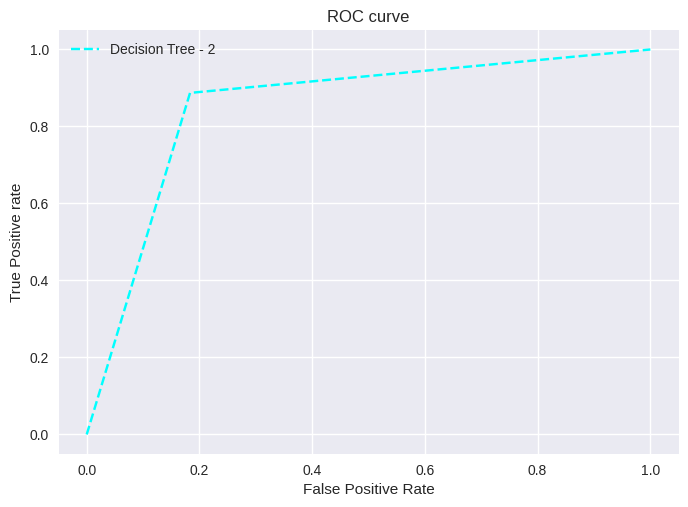

In [126]:
# plot roc curves
plt.plot(fpr6, tpr6, linestyle='--',color='cyan', label='Decision Tree - 2')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### XGBoost Classifier - 1

In [70]:
xgb = XGBClassifier()

In [73]:
param_grid = {'learning_rate': [0.1*(n+1) for n in range(5)],
              'n_estimators' : [2*n+1 for n in range(5)]}

param_grid 

{'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5],
 'n_estimators': [1, 3, 5, 7, 9]}

In [74]:
best = GridSearchCV(xgb, param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=3, cv=5)
best.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[CV 4/5] END max_depth=19, max_features=log2, n_estimators=5;, score=0.820 total time=   0.1s
[CV 5/5] END max_depth=19, max_features=log2, n_estimators=5;, score=0.802 total time=   0.1s
[CV 1/5] END max_depth=19, max_features=log2, n_estimators=7;, score=0.810 total time=   0.1s
[CV 2/5] END max_depth=19, max_features=log2, n_estimators=7;, score=0.813 total time=   0.1s
[CV 3/5] END max_depth=19, max_features=log2, n_estimators=7;, score=0.846 total time=   0.1s
[CV 4/5] END max_depth=19, max_features=log2, n_estimators=7;, score=0.824 total time=   0.1s
[CV 5/5] END max_depth=19, max_features=log2, n_estimators=7;, score=0.812 total time=   0.1s
[CV 2/5] END max_depth=19, max_features=log2, n_estimators=15;, score=0.818 total time=   0.2s
[CV 3/5] END max_depth=19, max_features=log2, n_estimators=15;, score=0.845 total time=   0.2s
[CV 4/5] END max_depth=19, max_features=log2, n_estimators=15;, score=0.851 total time=   0.2s
[CV 5/5] END max_depth=19, max_features=log2, n_estimator

[CV 2/5] END max_depth=19, max_features=sqrt, n_estimators=37;, score=0.837 total time=   0.5s
[CV 3/5] END max_depth=19, max_features=sqrt, n_estimators=37;, score=0.862 total time=   0.5s
[CV 4/5] END max_depth=19, max_features=sqrt, n_estimators=37;, score=0.861 total time=   0.5s
[CV 5/5] END max_depth=19, max_features=sqrt, n_estimators=37;, score=0.838 total time=   0.5s
[CV 1/5] END max_depth=19, max_features=sqrt, n_estimators=39;, score=0.838 total time=   0.5s
[CV 5/5] END max_depth=19, max_features=log2, n_estimators=33;, score=0.834 total time=   0.4s
[CV 3/5] END max_depth=19, max_features=log2, n_estimators=37;, score=0.859 total time=   0.4s
[CV 1/5] END .learning_rate=0.1, n_estimators=1;, score=0.779 total time=   0.8s
[CV 5/5] END max_depth=19, max_features=log2, n_estimators=3;, score=0.782 total time=   0.1s
[CV 1/5] END max_depth=19, max_features=log2, n_estimators=5;, score=0.807 total time=   0.1s
[CV 2/5] END max_depth=19, max_features=log2, n_estimators=5;, sco

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[CV 3/5] END max_depth=15, max_features=log2, n_estimators=13;, score=0.845 total time=   0.1s
[CV 4/5] END max_depth=15, max_features=log2, n_estimators=13;, score=0.855 total time=   0.1s
[CV 5/5] END max_depth=15, max_features=log2, n_estimators=13;, score=0.829 total time=   0.2s
[CV 1/5] END max_depth=15, max_features=log2, n_estimators=15;, score=0.843 total time=   0.2s
[CV 5/5] END max_depth=15, max_features=log2, n_estimators=33;, score=0.843 total time=   0.3s
[CV 1/5] END max_depth=15, max_features=log2, n_estimators=35;, score=0.843 total time=   0.3s
[CV 2/5] END max_depth=15, max_features=log2, n_estimators=35;, score=0.830 total time=   0.4s
[CV 3/5] END max_depth=15, max_features=log2, n_estimators=35;, score=0.851 total time=   0.3s
[CV 4/5] END max_depth=15, max_features=log2, n_estimators=35;, score=0.869 total time=   0.3s
[CV 5/5] END max_depth=15, max_features=log2, n_estimators=35;, score=0.845 total time=   0.4s
[CV 1/5] END max_depth=15, max_features=log2, n_es

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[CV 4/5] END max_depth=19, max_features=auto, n_estimators=33;, score=nan total time=   0.0s
[CV 4/5] END max_depth=19, max_features=auto, n_estimators=35;, score=nan total time=   0.0s
[CV 5/5] END max_depth=19, max_features=auto, n_estimators=35;, score=nan total time=   0.0s
[CV 1/5] END max_depth=19, max_features=auto, n_estimators=37;, score=nan total time=   0.0s
[CV 2/5] END max_depth=19, max_features=auto, n_estimators=37;, score=nan total time=   0.0s
[CV 4/5] END max_depth=19, max_features=sqrt, n_estimators=3;, score=0.807 total time=   0.0s
[CV 5/5] END max_depth=19, max_features=sqrt, n_estimators=3;, score=0.788 total time=   0.0s
[CV 1/5] END max_depth=19, max_features=sqrt, n_estimators=5;, score=0.813 total time=   0.1s
[CV 2/5] END max_depth=19, max_features=sqrt, n_estimators=5;, score=0.798 total time=   0.1s
[CV 5/5] END max_depth=19, max_features=sqrt, n_estimators=25;, score=0.835 total time=   0.3s
[CV 1/5] END max_depth=19, max_features=sqrt, n_estimators=27;, 

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xg

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-p

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/an

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4,
                                           0.5],
                         'n_estimators': [1, 3, 5, 7, 9]},
             scoring='accuracy', verbose=3)

In [75]:
y_pred = best.predict(X_test)
best.score(X_train, y_train)

0.8754639703059004

In [76]:
best.score(X_test, y_test)

0.840250821140639

In [77]:
metrics_score(y_test, y_pred)

The accuracy score is:  0.840250821140639
The precision score is:  0.8116113744075829
The r2 score is:  0.3592537122348366
The f1 score is:  0.8366412213740458


In [80]:
fpr4, tpr4, thresh4 = roc_curve(y_test, y_pred, pos_label=1)
auc_score1 = roc_auc_score(y_test, y_pred)

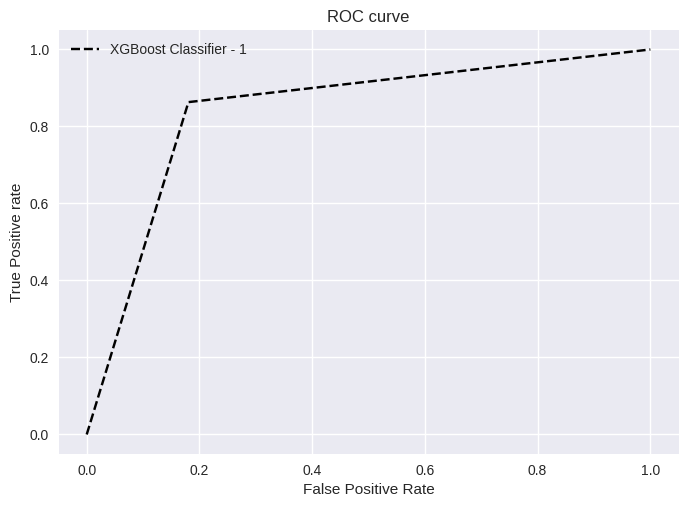

In [81]:
# plot roc curves
plt.plot(fpr4, tpr4, linestyle='--',color='black', label='XGBoost Classifier - 1')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### XGBoostClassifier - 2

In [82]:
learning_rate= .3 
max_depth = [1, 3, 5, 8, 10, 15, 20, 30, 50, 100]

In [83]:
xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 device='cuda')

In [84]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

[12:31:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.



In [85]:
xgb.score(X_train, y_train)

0.9980801228721362

In [86]:
xgb.score(X_test, y_test)

0.8492087190206031

Overfitting!

In [87]:
param_grid = {'learning_rate': [0.1, 0.3, 0.5],
 'n_estimators': [500, 1000, 1500],
 'max_depth': [3, 5, 7],
 'min_child_weight': [1,2,3],
 'subsample': [.8],
 'colsample_bytree': [.8],
 'objective':['binary:logistic'],
 'nthread': [4],
 'scale_pos_weight':[1],
 'seed':[27]}

In [88]:
param_grid = {'learning_rate': [0.1*(n+1) for n in range(5)],
             'n_estimators' : [2*n+1 for n in range(25)],
             'objective':['binary:logistic']}


param_grid

{'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5],
 'n_estimators': [1,
  3,
  5,
  7,
  9,
  11,
  13,
  15,
  17,
  19,
  21,
  23,
  25,
  27,
  29,
  31,
  33,
  35,
  37,
  39,
  41,
  43,
  45,
  47,
  49],
 'objective': ['binary:logistic']}

In [89]:
xgb2 = XGBClassifier(early_stopping_rounds=10, eval_metric='logloss')

In [90]:
best = GridSearchCV(xgb, param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=3, cv=5)
best.fit(X_train, y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data)

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categoric

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-p

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categ

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categori

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and

[CV 4/5] END .learning_rate=0.1, n_estimators=3;, score=0.818 total time=   0.6s
[CV 4/5] END .learning_rate=0.1, n_estimators=5;, score=0.819 total time=   0.1s
[CV 5/5] END .learning_rate=0.1, n_estimators=5;, score=0.805 total time=   0.2s
[CV 2/5] END .learning_rate=0.1, n_estimators=7;, score=0.816 total time=   0.2s
[CV 4/5] END .learning_rate=0.1, n_estimators=7;, score=0.824 total time=   0.2s
[CV 3/5] END .learning_rate=0.1, n_estimators=9;, score=0.833 total time=   0.2s
[CV 5/5] END .learning_rate=0.1, n_estimators=9;, score=0.811 total time=   0.2s
[CV 4/5] END .learning_rate=0.2, n_estimators=3;, score=0.818 total time=   0.1s
[CV 3/5] END .learning_rate=0.2, n_estimators=5;, score=0.830 total time=   0.1s
[CV 1/5] END .learning_rate=0.2, n_estimators=7;, score=0.820 total time=   0.2s
[CV 1/5] END .learning_rate=0.2, n_estimators=9;, score=0.821 total time=   0.2s
[CV 1/5] END learning_rate=0.30000000000000004, n_estimators=1;, score=0.779 total time=   0.1s
[CV 5/5] END 

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgb

[CV 1/5] END .learning_rate=0.1, n_estimators=5;, score=0.795 total time=   0.7s
[CV 4/5] END .learning_rate=0.1, n_estimators=9;, score=0.837 total time=   0.2s
[CV 2/5] END .learning_rate=0.2, n_estimators=1;, score=0.788 total time=   0.1s
[CV 5/5] END .learning_rate=0.2, n_estimators=1;, score=0.782 total time=   0.1s
[CV 3/5] END .learning_rate=0.2, n_estimators=3;, score=0.818 total time=   0.1s
[CV 2/5] END .learning_rate=0.2, n_estimators=5;, score=0.814 total time=   0.1s
[CV 2/5] END .learning_rate=0.2, n_estimators=7;, score=0.820 total time=   0.2s
[CV 2/5] END .learning_rate=0.2, n_estimators=9;, score=0.821 total time=   0.2s
[CV 2/5] END learning_rate=0.30000000000000004, n_estimators=1;, score=0.788 total time=   0.1s
[CV 2/5] END learning_rate=0.30000000000000004, n_estimators=3;, score=0.814 total time=   0.1s
[CV 4/5] END learning_rate=0.30000000000000004, n_estimators=5;, score=0.824 total time=   0.1s
[CV 5/5] END learning_rate=0.30000000000000004, n_estimators=7;,

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/li

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[CV 5/5] END .learning_rate=0.1, n_estimators=3;, score=0.800 total time=   0.6s
[CV 3/5] END .learning_rate=0.1, n_estimators=7;, score=0.822 total time=   0.2s
[CV 5/5] END .learning_rate=0.1, n_estimators=7;, score=0.812 total time=   0.2s
[CV 2/5] END .learning_rate=0.1, n_estimators=9;, score=0.813 total time=   0.3s
[CV 1/5] END .learning_rate=0.2, n_estimators=1;, score=0.779 total time=   0.1s
[CV 3/5] END .learning_rate=0.2, n_estimators=1;, score=0.803 total time=   0.1s
[CV 1/5] END .learning_rate=0.2, n_estimators=3;, score=0.796 total time=   0.1s
[CV 1/5] END .learning_rate=0.2, n_estimators=5;, score=0.807 total time=   0.1s
[CV 5/5] END .learning_rate=0.2, n_estimators=5;, score=0.809 total time=   0.1s
[CV 5/5] END .learning_rate=0.2, n_estimators=7;, score=0.821 total time=   0.2s
[CV 5/5] END .learning_rate=0.2, n_estimators=9;, score=0.823 total time=   0.2s
[CV 5/5] END learning_rate=0.30000000000000004, n_estimators=3;, score=0.805 total time=   0.1s
[CV 5/5] END 

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[CV 3/5] END .learning_rate=0.1, n_estimators=5;, score=0.818 total time=   0.6s
[CV 3/5] END .learning_rate=0.2, n_estimators=7;, score=0.836 total time=   0.2s
[CV 3/5] END .learning_rate=0.2, n_estimators=9;, score=0.839 total time=   0.2s
[CV 4/5] END learning_rate=0.30000000000000004, n_estimators=1;, score=0.801 total time=   0.1s
[CV 4/5] END learning_rate=0.30000000000000004, n_estimators=3;, score=0.814 total time=   0.1s
[CV 1/5] END learning_rate=0.30000000000000004, n_estimators=7;, score=0.824 total time=   0.2s
[CV 2/5] END learning_rate=0.30000000000000004, n_estimators=9;, score=0.827 total time=   0.2s
[CV 3/5] END .learning_rate=0.4, n_estimators=1;, score=0.803 total time=   0.1s
[CV 5/5] END .learning_rate=0.4, n_estimators=1;, score=0.782 total time=   0.1s
[CV 4/5] END .learning_rate=0.4, n_estimators=3;, score=0.828 total time=   0.1s
[CV 1/5] END .learning_rate=0.4, n_estimators=7;, score=0.831 total time=   0.2s
[CV 4/5] END .learning_rate=0.4, n_estimators=9;,

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_cate

[CV 4/5] END .learning_rate=0.2, n_estimators=1;, score=0.801 total time=   0.6s
[CV 2/5] END .learning_rate=0.4, n_estimators=7;, score=0.829 total time=   0.2s
[CV 5/5] END .learning_rate=0.4, n_estimators=9;, score=0.830 total time=   0.3s
[CV 4/5] END .learning_rate=0.5, n_estimators=5;, score=0.835 total time=   0.1s
[CV 2/5] END .learning_rate=0.5, n_estimators=9;, score=0.827 total time=   0.2s
[12:32:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 1/5] END learning_rate=0.1, n_estimators=3, objective=binary:logistic;, score=0.787 total time=   0.3s
[12:32:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 2/5] END learning_rate=0.1, n_estimators=7, objective=binary:logistic;, score=0.811 total time=   0.4s
[12:32:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgbo

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[CV 2/5] END .learning_rate=0.1, n_estimators=5;, score=0.798 total time=   0.7s
[CV 2/5] END .learning_rate=0.2, n_estimators=3;, score=0.806 total time=   0.1s
[CV 5/5] END .learning_rate=0.2, n_estimators=3;, score=0.803 total time=   0.1s
[CV 4/5] END .learning_rate=0.2, n_estimators=5;, score=0.837 total time=   0.1s
[CV 4/5] END .learning_rate=0.2, n_estimators=7;, score=0.839 total time=   0.2s
[CV 4/5] END .learning_rate=0.2, n_estimators=9;, score=0.840 total time=   0.2s
[CV 1/5] END learning_rate=0.30000000000000004, n_estimators=3;, score=0.809 total time=   0.1s
[CV 2/5] END learning_rate=0.30000000000000004, n_estimators=5;, score=0.825 total time=   0.1s
[CV 3/5] END learning_rate=0.30000000000000004, n_estimators=7;, score=0.854 total time=   0.2s
[CV 3/5] END learning_rate=0.30000000000000004, n_estimators=9;, score=0.855 total time=   0.3s
[CV 1/5] END .learning_rate=0.4, n_estimators=5;, score=0.820 total time=   0.1s
[CV 4/5] END .learning_rate=0.4, n_estimators=7;,

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[CV 1/5] END .learning_rate=0.1, n_estimators=9;, score=0.811 total time=   0.9s
[CV 2/5] END .learning_rate=0.4, n_estimators=5;, score=0.823 total time=   0.1s
[CV 5/5] END .learning_rate=0.4, n_estimators=7;, score=0.821 total time=   0.2s
[CV 2/5] END .learning_rate=0.5, n_estimators=1;, score=0.788 total time=   0.1s
[CV 5/5] END .learning_rate=0.5, n_estimators=1;, score=0.782 total time=   0.1s
[CV 4/5] END .learning_rate=0.5, n_estimators=3;, score=0.823 total time=   0.1s
[CV 3/5] END .learning_rate=0.5, n_estimators=7;, score=0.853 total time=   0.2s
[CV 5/5] END .learning_rate=0.5, n_estimators=9;, score=0.837 total time=   0.2s
[12:32:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 3/5] END learning_rate=0.1, n_estimators=3, objective=binary:logistic;, score=0.797 total time=   0.2s
[12:32:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_16971078409

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[CV 1/5] END .learning_rate=0.1, n_estimators=7;, score=0.805 total time=   0.7s
[CV 3/5] END learning_rate=0.30000000000000004, n_estimators=1;, score=0.803 total time=   0.1s
[CV 3/5] END learning_rate=0.30000000000000004, n_estimators=3;, score=0.823 total time=   0.1s
[CV 3/5] END learning_rate=0.30000000000000004, n_estimators=5;, score=0.843 total time=   0.1s
[CV 4/5] END learning_rate=0.30000000000000004, n_estimators=7;, score=0.843 total time=   0.3s
[CV 2/5] END .learning_rate=0.4, n_estimators=1;, score=0.788 total time=   0.1s
[CV 1/5] END .learning_rate=0.4, n_estimators=3;, score=0.810 total time=   0.1s
[CV 4/5] END .learning_rate=0.4, n_estimators=5;, score=0.839 total time=   0.1s
[CV 2/5] END .learning_rate=0.4, n_estimators=9;, score=0.832 total time=   0.2s
[CV 3/5] END .learning_rate=0.5, n_estimators=3;, score=0.834 total time=   0.1s
[CV 5/5] END .learning_rate=0.5, n_estimators=5;, score=0.828 total time=   0.2s
[CV 3/5] END .learning_rate=0.5, n_estimators=9;,

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgb

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) in

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_cat

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[12:32:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 3/5] END learning_rate=0.2, n_estimators=21, objective=binary:logistic;, score=0.854 total time=   1.0s
[12:32:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 2/5] END learning_rate=0.2, n_estimators=25, objective=binary:logistic;, score=0.834 total time=   1.1s
[12:32:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 2/5] END learning_rate=0.2, n_estimators=29, objective=binary:logistic;, score=0.839 total time=   1.4s
[12:32:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 1/5] END learning_rate=0.2, n_estimators=33,

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xg

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

[12:32:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 1/5] END learning_rate=0.2, n_estimators=39, objective=binary:logistic;, score=0.843 total time=   1.3s
[12:32:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 3/5] END learning_rate=0.2, n_estimators=41, objective=binary:logistic;, score=0.868 total time=   1.7s
[12:32:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 1/5] END learning_rate=0.2, n_estimators=45, objective=binary:logistic;, score=0.839 total time=   1.8s
[12:32:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 4/5] END learning_rate=0.2, n_estimators=47,

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) in

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  

[CV 3/5] END learning_rate=0.2, n_estimators=17, objective=binary:logistic;, score=0.847 total time=   0.5s
[12:32:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 3/5] END learning_rate=0.2, n_estimators=19, objective=binary:logistic;, score=0.851 total time=   0.8s
[12:32:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 1/5] END learning_rate=0.2, n_estimators=23, objective=binary:logistic;, score=0.831 total time=   0.9s
[12:32:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 4/5] END learning_rate=0.2, n_estimators=25, objective=binary:logistic;, score=0.850 total time=   1.0s
[12:32:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/s

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[CV 2/5] END learning_rate=0.2, n_estimators=39, objective=binary:logistic;, score=0.844 total time=   1.7s
[12:32:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 5/5] END learning_rate=0.2, n_estimators=41, objective=binary:logistic;, score=0.843 total time=   1.7s
[12:32:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 3/5] END learning_rate=0.2, n_estimators=45, objective=binary:logistic;, score=0.871 total time=   2.0s
[12:32:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 1/5] END learning_rate=0.2, n_estimators=49, objective=binary:logistic;, score=0.841 total time=   1.8s
[12:32:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/s

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  

[12:32:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 2/5] END learning_rate=0.2, n_estimators=27, objective=binary:logistic;, score=0.837 total time=   1.4s
[12:32:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 1/5] END learning_rate=0.2, n_estimators=31, objective=binary:logistic;, score=0.839 total time=   1.4s
[12:32:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 4/5] END learning_rate=0.2, n_estimators=33, objective=binary:logistic;, score=0.859 total time=   1.4s
[12:32:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 3/5] END learning_rate=0.2, n_estimators=37,

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[12:32:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 4/5] END learning_rate=0.2, n_estimators=43, objective=binary:logistic;, score=0.869 total time=   2.0s
[12:32:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 3/5] END learning_rate=0.2, n_estimators=47, objective=binary:logistic;, score=0.872 total time=   1.9s
[12:32:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 5/5] END learning_rate=0.2, n_estimators=49, objective=binary:logistic;, score=0.844 total time=   1.8s
[12:32:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 1/5] END learning_rate=0.30000000000000004, 

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[12:32:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 1/5] END learning_rate=0.2, n_estimators=41, objective=binary:logistic;, score=0.841 total time=   1.3s
[12:32:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 1/5] END learning_rate=0.2, n_estimators=43, objective=binary:logistic;, score=0.841 total time=   1.6s
[12:32:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 4/5] END learning_rate=0.2, n_estimators=45, objective=binary:logistic;, score=0.867 total time=   2.0s
[12:32:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 2/5] END learning_rate=0.2, n_estimators=49,

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[12:32:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 1/5] END learning_rate=0.2, n_estimators=47, objective=binary:logistic;, score=0.841 total time=   1.9s
[12:32:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 3/5] END learning_rate=0.2, n_estimators=49, objective=binary:logistic;, score=0.872 total time=   1.9s
[12:32:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 2/5] END learning_rate=0.30000000000000004, n_estimators=9, objective=binary:logistic;, score=0.816 total time=   0.5s
[12:32:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 1/5] END learning_rate=0.3000

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/an

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/an

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/li

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.1

[CV 3/5] END learning_rate=0.4, n_estimators=1, objective=binary:logistic;, score=0.779 total time=   0.1s
[12:32:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 5/5] END learning_rate=0.4, n_estimators=1, objective=binary:logistic;, score=0.782 total time=   0.2s
[12:32:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 3/5] END learning_rate=0.4, n_estimators=3, objective=binary:logistic;, score=0.806 total time=   0.3s
[12:32:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

[CV 1/5] END learning_rate=0.4, n_estimators=5, objective=binary:logistic;, score=0.809 total time=   0.4s
[12:32:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/l

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/andre/anaconda3/lib/python3.11/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_cate

[12:33:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1697107840900/work/src/learner.cc:767: 
Parameters: { "device" } are not used.



GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_...
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4,
                                           0.5],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39,
                                          41, 43, 45, 47, 49],
                         'objective': ['binary:logistic']},
             scoring='accuracy', verbose=3)

In [91]:
best.score(X_train, y_train)

0.9008063483937028

In [136]:
y_pred2 = best.predict(X_test)
best.score(X_test, y_test)

0.8515974917885936

In [137]:
best.score(X_test, y_test)

0.8515974917885936

In [94]:
metrics_score(y_test, y_pred2)

The accuracy score is:  0.8515974917885936
The precision score is:  0.8244047619047619
The r2 score is:  0.4047646635153529
The f1 score is:  0.8478726660544843


In [138]:
fpr5, tpr5, thresh5 = roc_curve(y_test, y_pred2, pos_label=1)
auc_score1 = roc_auc_score(y_test, y_pred2)

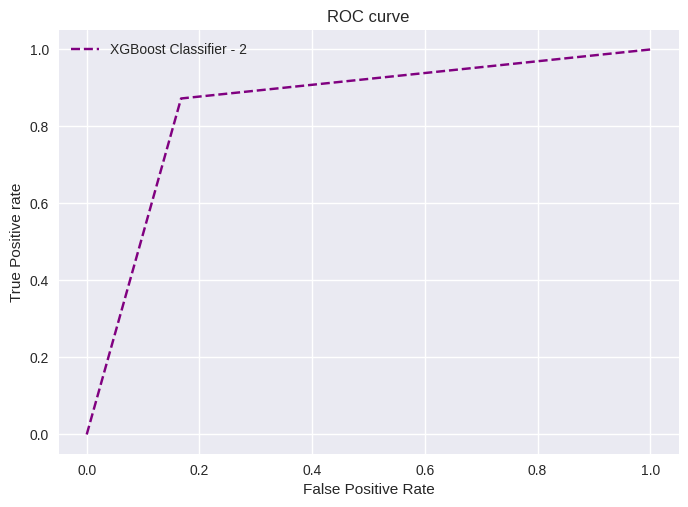

In [139]:
# plot roc curves
plt.plot(fpr5, tpr5, linestyle='--',color='purple', label='XGBoost Classifier - 2')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### Ploting ALL Results

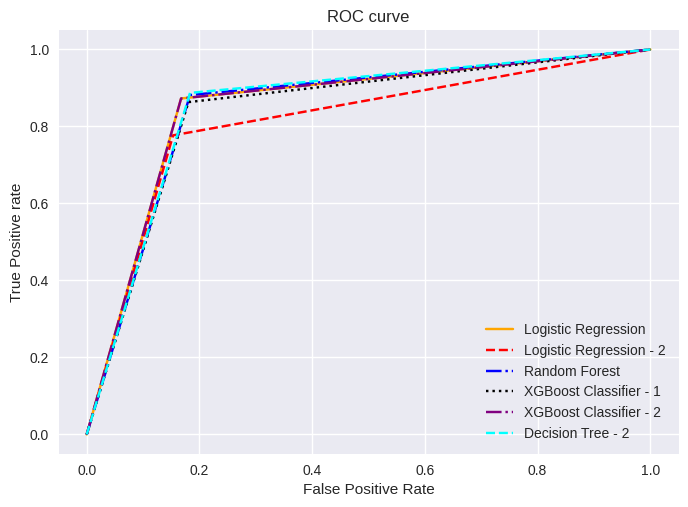

In [135]:
plt.plot(fpr1, tpr1, linestyle='-',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='red', label='Logistic Regression - 2')
plt.plot(fpr3, tpr3, linestyle='-.',color='blue', label='Random Forest')
plt.plot(fpr4, tpr4, linestyle=':',color='black', label='XGBoost Classifier - 1')
plt.plot(fpr5, tpr5, linestyle='dashdot',color='purple', label='XGBoost Classifier - 2')
plt.plot(fpr6, tpr6, linestyle='--',color='cyan', label='Decision Tree - 2')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();


### Confusion Matrix of best model

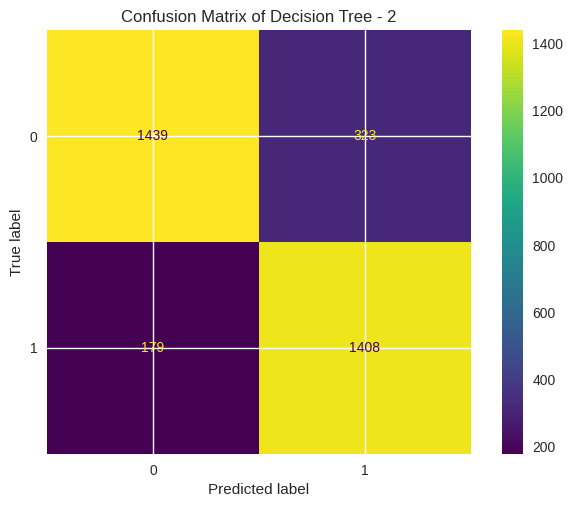

In [149]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best2.classes_)
disp.plot()

plt.title('Confusion Matrix of Decision Tree - 2')

plt.show()


Text(0.5, 0, 'Permutation Importance')

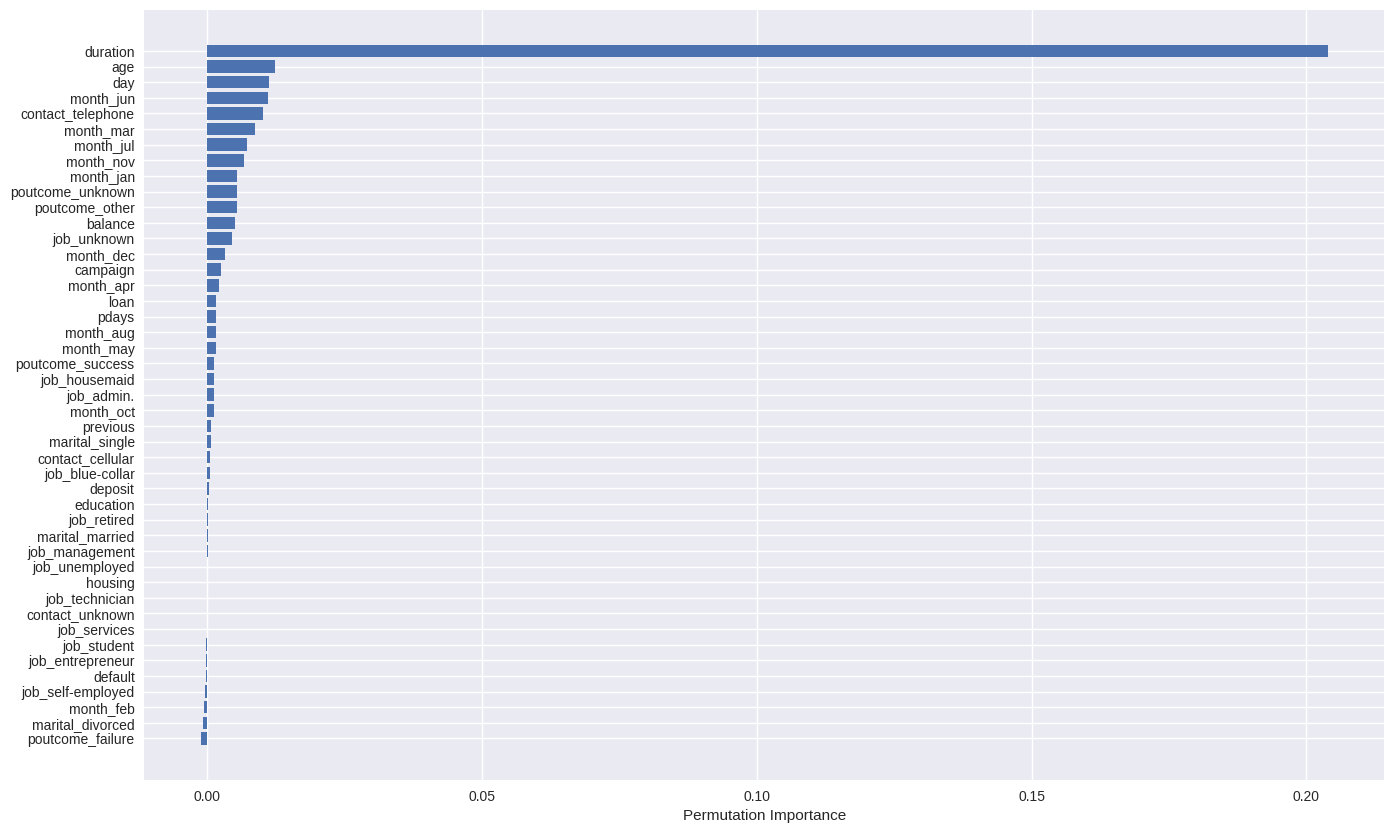

In [156]:
perm_importance = permutation_importance(best2, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(16,10))
plt.barh(df.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")


Using seven metrics, area of the receiver operating characteristic curve (AUC), accuracy, precision, recall, F1, R2 and Confusion Matrix.  The three models were tested on an evaluation set with 70% of the total data and 30% were left for testing with 5-fold cross validation. 
The best model was Random Forest with 'max_depth': 19, 'max_features': 'log2', 'n_estimators': 105

It is worth highlighting that most of the variables are not linked to the target and that the duration of the marketing campaign was the biggest predictor of success in customer conversion. For future work I see that it is important to focus on this aspect.

